## Controle Quântico Ótimo - Utilização do CG para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Heisenberg, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

Para analisar como o controle melhora o condicionamento da curva através da sua análise futura, esse arquivo estará analisando os ajustes no horizonte 3 ao 10.

Nesse projeto usa-se o gradiente devido a sua facilidade de reprodução, vide os projetos fora da biblioteca do python, além dos problemas do cálculo da Hessiana na otimização não linear utilizando o método de Newton e suas variantes.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
## Constantes

horizonte = 3
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.0)],[complex(0.0,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos3 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/10)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/10)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos3[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.56107706  6.26833584  0.37110349]
 Conferindo: (1.755618479444345+0j)
Iteração: 2
Mínimo: [ 3.14777804  6.2547356  -1.56107706]
 Conferindo: (1.7519740682866412+0j)
Iteração: 3
Mínimo: [3.12579934 6.22586167 3.14777804]
 Conferindo: (1.7457460778781484+0j)
Iteração: 4
Mínimo: [3.11620213 6.20540725 3.12579934]
 Conferindo: (1.739555569006418+0j)
Iteração: 5
Mínimo: [3.11337472 6.16647475 3.11620213]
 Conferindo: (1.7334001977421387+0j)
Iteração: 6
Mínimo: [3.09098857 6.13260889 3.11337472]
 Conferindo: (1.7272952875392158+0j)
Iteração: 7
Mínimo: [3.07648696 6.08971764 3.09098857]
 Conferindo: (1.721257034788651+0j)
Iteração: 8
Mínimo: [3.05650583 6.03776953 3.07648696]
 Conferindo: (1.7152912301448078+0j)
Iteração: 9
Mínimo: [3.03319043 5.98423869 3.05650583]
 Conferindo: (1.7094113744348234+0j)
Iteração: 10
Mínimo: [3.00409569 5.92801677 3.03319043]
 Conferindo: (1.7036276835533712+0j)
Iteração: 11
Mínimo: [2.97723517 5.8626405  3.00409569]
 Conferindo: (1.6979

Mínimo: [0.42424338 0.42519733 0.31823611]
 Conferindo: (1.562816956627827+0j)
Iteração: 97
Mínimo: [0.18449441 0.57493625 0.42424338]
 Conferindo: (1.5627623479384933+0j)
Iteração: 98
Mínimo: [0.41354917 0.37044788 0.18449441]
 Conferindo: (1.56271705128144+0j)
Iteração: 99
Mínimo: [0.1596119  0.5388001  0.41354917]
 Conferindo: (1.562669348170692+0j)
Iteração: 100
Mínimo: [0.38978825 0.34448248 0.1596119 ]
 Conferindo: (1.5626304715177426+0j)
Iteração: 101
Mínimo: [0.14696877 0.50695634 0.38978825]
 Conferindo: (1.5625885690209813+0j)
Iteração: 102
Mínimo: [0.36693691 0.32317361 0.14696877]
 Conferindo: (1.56255439852847+0j)
Iteração: 103
Mínimo: [0.23039555 0.31826792 0.36693691]
 Conferindo: (1.5625182983252393+0j)
Iteração: 104
Mínimo: [0.14740795 0.46260088 0.23039555]
 Conferindo: (1.562490209927553+0j)
Iteração: 105
Mínimo: [0.33235989 0.29770064 0.14740795]
 Conferindo: (1.562461064986078+0j)
Iteração: 106
Mínimo: [0.21151271 0.29031061 0.33235989]
 Conferindo: (1.562431047228

Mínimo: [ 0.02909621  0.01674179 -0.00869379]
 Conferindo: (1.5620442631821754+0j)
Iteração: 201
Mínimo: [0.02909621 0.02909621 0.02909621]
 Conferindo: (1.56204421045803+0j)
Iteração: 202
Mínimo: [-0.00374779  0.01121618  0.02909621]
 Conferindo: (1.562044114977649+0j)
Iteração: 203
Mínimo: [-0.00374779 -0.00374779 -0.00374779]
 Conferindo: (1.5620441686637885+0j)
Iteração: 204
Mínimo: [ 0.02407934  0.01510775 -0.00374779]
 Conferindo: (1.562043998114516+0j)
Iteração: 205
Mínimo: [0.02407934 0.02407934 0.02407934]
 Conferindo: (1.562043940180674+0j)
Iteração: 206
Mínimo: [0.02407934 0.02407934 0.02407934]
 Conferindo: (1.5620440312773654+0j)
Iteração: 207
Mínimo: [-0.01226927  0.00472389  0.02407934]
 Conferindo: (1.5620439497641547+0j)
Iteração: 208
Mínimo: [-0.01226927 -0.01226927 -0.01226927]
 Conferindo: (1.562044072551538+0j)
Iteração: 209
Mínimo: [ 0.02628743  0.01309399 -0.01226927]
 Conferindo: (1.5620438614094982+0j)
Iteração: 210
Mínimo: [0.02628743 0.02628743 0.02628743]
 C

Mínimo: [ 0.01535529  0.00311573 -0.01626992]
 Conferindo: (1.5620427227580573+0j)
Iteração: 296
Mínimo: [0.01535529 0.01535529 0.01535529]
 Conferindo: (1.5620427690357304+0j)
Iteração: 297
Mínimo: [-0.01202321 -0.0012551   0.01535529]
 Conferindo: (1.562042707073311+0j)
Iteração: 298
Mínimo: [-0.01202321 -0.01202321 -0.01202321]
 Conferindo: (1.5620427458068291+0j)
Iteração: 299
Mínimo: [-0.01202321 -0.01202321 -0.01202321]
 Conferindo: (1.5620428431391977+0j)
Iteração: 300
Mínimo: [ 0.02174858  0.00765785 -0.01202321]
 Conferindo: (1.5620427172163707+0j)
Iteração: 301
Mínimo: [0.02174858 0.02174858 0.02174858]
 Conferindo: (1.5620427941552122+0j)
Iteração: 302
Mínimo: [-0.01589785 -0.00127235  0.02174858]
 Conferindo: (1.5620426789318653+0j)
Iteração: 303
Mínimo: [-0.01589785 -0.01589785 -0.01589785]
 Conferindo: (1.5620427471985767+0j)
Iteração: 304
Mínimo: [ 0.0153754   0.00319203 -0.01589785]
 Conferindo: (1.562042664754987+0j)
Iteração: 305
Mínimo: [0.0153754 0.0153754 0.0153754

Mínimo: [ 0.01646752  0.0018769  -0.02126948]
 Conferindo: (1.562042172340056+0j)
Iteração: 396
Mínimo: [0.01646752 0.01646752 0.01646752]
 Conferindo: (1.5620422422265454+0j)
Iteração: 397
Mínimo: [-0.01465682 -0.00240494  0.01646752]
 Conferindo: (1.5620421593886515+0j)
Iteração: 398
Mínimo: [-0.01465682 -0.01465682 -0.01465682]
 Conferindo: (1.5620422081253715+0j)
Iteração: 399
Mínimo: [ 0.01306984  0.00217307 -0.01465682]
 Conferindo: (1.5620421445999915+0j)
Iteração: 400
Mínimo: [0.01306984 0.01306984 0.01306984]
 Conferindo: (1.5620421879237907+0j)
Iteração: 401
Mínimo: [0.01306984 0.01306984 0.01306984]
 Conferindo: (1.5620422975862303+0j)
Iteração: 402
Mínimo: [-0.02233484 -0.00742358  0.01306984]
 Conferindo: (1.5620421646679965+0j)
Iteração: 403
Mínimo: [-0.02233484 -0.02233484 -0.02233484]
 Conferindo: (1.5620422546249948+0j)
Iteração: 404
Mínimo: [ 0.01725923  0.00196066 -0.02233484]
 Conferindo: (1.5620421247549245+0j)
Iteração: 405
Mínimo: [0.01725923 0.01725923 0.0172592

Mínimo: [ 0.01297141  0.00200102 -0.01509764]
 Conferindo: (1.5620415932187783+0j)
Iteração: 500
Mínimo: [0.01297141 0.01297141 0.01297141]
 Conferindo: (1.5620416298549933+0j)
Iteração: 501
Mínimo: [0.01297141 0.01297141 0.01297141]
 Conferindo: (1.562041733548223+0j)
Iteração: 502
Mínimo: [-0.02146721 -0.00704485  0.01297141]
 Conferindo: (1.562041607300176+0j)
Iteração: 503
Mínimo: [-0.02146721 -0.02146721 -0.02146721]
 Conferindo: (1.5620416870553995+0j)
Iteração: 504
Mínimo: [ 0.01615765  0.00168945 -0.02146721]
 Conferindo: (1.5620415689638998+0j)
Iteração: 505
Mínimo: [0.01615765 0.01615765 0.01615765]
 Conferindo: (1.562041631983313+0j)
Iteração: 506
Mínimo: [-0.01393211 -0.0021694   0.01615765]
 Conferindo: (1.5620415538687358+0j)
Iteração: 507
Mínimo: [-0.01393211 -0.01393211 -0.01393211]
 Conferindo: (1.5620415965755239+0j)
Iteração: 508
Mínimo: [ 0.01168085  0.00167816 -0.01393211]
 Conferindo: (1.5620415394106886+0j)
Iteração: 509
Mínimo: [0.01168085 0.01168085 0.01168085]

Mínimo: [-0.0157536  -0.00170525  0.02071882]
 Conferindo: (1.5620410522199304+0j)
Iteração: 598
Mínimo: [-0.0157536 -0.0157536 -0.0157536]
 Conferindo: (1.5620411145711595+0j)
Iteração: 599
Mínimo: [ 0.01429136  0.00246598 -0.0157536 ]
 Conferindo: (1.5620410392209474+0j)
Iteração: 600
Mínimo: [0.01429136 0.01429136 0.01429136]
 Conferindo: (1.562041089180776+0j)
Iteração: 601
Mínimo: [-0.01220474 -0.00184649  0.01429136]
 Conferindo: (1.5620410265090738+0j)
Iteração: 602
Mínimo: [-0.01220474 -0.01220474 -0.01220474]
 Conferindo: (1.5620410562184512+0j)
Iteração: 603
Mínimo: [-0.01220474 -0.01220474 -0.01220474]
 Conferindo: (1.5620411452204914+0j)
Iteração: 604
Mínimo: [ 0.01950545  0.0062235  -0.01220474]
 Conferindo: (1.5620410369580777+0j)
Iteração: 605
Mínimo: [0.01950545 0.01950545 0.01950545]
 Conferindo: (1.562041099894084+0j)
Iteração: 606
Mínimo: [-0.01480632 -0.0016916   0.01950545]
 Conferindo: (1.5620410020894062+0j)
Iteração: 607
Mínimo: [-0.01480632 -0.01480632 -0.01480

Mínimo: [ 0.01304726  0.00198345 -0.01531564]
 Conferindo: (1.562040562398496+0j)
Iteração: 686
Mínimo: [0.01304726 0.01304726 0.01304726]
 Conferindo: (1.5620406007480776+0j)
Iteração: 687
Mínimo: [0.01304726 0.01304726 0.01304726]
 Conferindo: (1.562040706337195+0j)
Iteração: 688
Mínimo: [-0.02141117 -0.00698407  0.01304726]
 Conferindo: (1.5620405784330336+0j)
Iteração: 689
Mínimo: [-0.02141117 -0.02141117 -0.02141117]
 Conferindo: (1.562040655210882+0j)
Iteração: 690
Mínimo: [ 0.01605601  0.00163682 -0.02141117]
 Conferindo: (1.5620405383873734+0j)
Iteração: 691
Mínimo: [0.01605601 0.01605601 0.01605601]
 Conferindo: (1.5620406010518915+0j)
Iteração: 692
Mínimo: [-0.01404757 -0.00227288  0.01605601]
 Conferindo: (1.5620405240254827+0j)
Iteração: 693
Mínimo: [-0.01404757 -0.01404757 -0.01404757]
 Conferindo: (1.5620405697615758+0j)
Iteração: 694
Mínimo: [ 0.01234743  0.00205069 -0.01404757]
 Conferindo: (1.5620405103159596+0j)
Iteração: 695
Mínimo: [0.01234743 0.01234743 0.01234743]

Mínimo: [-0.01672085 -0.00200845  0.02159983]
 Conferindo: (1.5620400737980722+0j)
Iteração: 775
Mínimo: [-0.01672085 -0.01672085 -0.01672085]
 Conferindo: (1.5620401418210146+0j)
Iteração: 776
Mínimo: [ 0.01434277  0.00215277 -0.01672085]
 Conferindo: (1.5620400595446116+0j)
Iteração: 777
Mínimo: [0.01434277 0.01434277 0.01434277]
 Conferindo: (1.562040106858773+0j)
Iteração: 778
Mínimo: [-0.01217095 -0.00187472  0.01434277]
 Conferindo: (1.5620400446332683+0j)
Iteração: 779
Mínimo: [-0.01217095 -0.01217095 -0.01217095]
 Conferindo: (1.5620400747992695+0j)
Iteração: 780
Mínimo: [-0.01217095 -0.01217095 -0.01217095]
 Conferindo: (1.562040163244583+0j)
Iteração: 781
Mínimo: [ 0.01942654  0.00613823 -0.01217095]
 Conferindo: (1.5620400565439985+0j)
Iteração: 782
Mínimo: [0.01942654 0.01942654 0.01942654]
 Conferindo: (1.562040120848509+0j)
Iteração: 783
Mínimo: [-0.01504121 -0.00178731  0.01942654]
 Conferindo: (1.5620400222125093+0j)
Iteração: 784
Mínimo: [-0.01504121 -0.01504121 -0.015

Mínimo: [ 0.02183731  0.00723375 -0.01287543]
 Conferindo: (1.562039614546118+0j)
Iteração: 864
Mínimo: [0.02183731 0.02183731 0.02183731]
 Conferindo: (1.5620397120391343+0j)
Iteração: 865
Mínimo: [-0.01850269 -0.00290094  0.02183731]
 Conferindo: (1.56203958170768+0j)
Iteração: 866
Mínimo: [-0.01850269 -0.01850269 -0.01850269]
 Conferindo: (1.562039672159876+0j)
Iteração: 867
Mínimo: [ 0.01621754  0.00259362 -0.01850269]
 Conferindo: (1.5620395688282236+0j)
Iteração: 868
Mínimo: [0.01621754 0.01621754 0.01621754]
 Conferindo: (1.5620396275597153+0j)
Iteração: 869
Mínimo: [-0.0136851  -0.00207316  0.01621754]
 Conferindo: (1.5620395507061473+0j)
Iteração: 870
Mínimo: [-0.0136851 -0.0136851 -0.0136851]
 Conferindo: (1.562039592159131+0j)
Iteração: 871
Mínimo: [-0.0136851 -0.0136851 -0.0136851]
 Conferindo: (1.5620397069863468+0j)
Iteração: 872
Mínimo: [ 0.02253878  0.00733087 -0.0136851 ]
 Conferindo: (1.5620395703737033+0j)
Iteração: 873
Mínimo: [0.02253878 0.02253878 0.02253878]
 Con

Mínimo: [0.01315266 0.01315266 0.01315266]
 Conferindo: (1.5620390696000577+0j)
Iteração: 964
Mínimo: [0.01315266 0.01315266 0.01315266]
 Conferindo: (1.5620391737768846+0j)
Iteração: 965
Mínimo: [-0.02109248 -0.0067133   0.01315266]
 Conferindo: (1.5620390489499356+0j)
Iteração: 966
Mínimo: [-0.02109248 -0.02109248 -0.02109248]
 Conferindo: (1.5620391250419718+0j)
Iteração: 967
Mínimo: [ 0.0159829   0.00170566 -0.02109248]
 Conferindo: (1.5620390101078403+0j)
Iteração: 968
Mínimo: [0.0159829 0.0159829 0.0159829]
 Conferindo: (1.5620390709065828+0j)
Iteração: 969
Mínimo: [-0.01361295 -0.00207816  0.0159829 ]
 Conferindo: (1.5620389957095902+0j)
Iteração: 970
Mínimo: [-0.01361295 -0.01361295 -0.01361295]
 Conferindo: (1.5620390375760038+0j)
Iteração: 971
Mínimo: [-0.01361295 -0.01361295 -0.01361295]
 Conferindo: (1.5620391530515674+0j)
Iteração: 972
Mínimo: [ 0.02232836  0.00725863 -0.01361295]
 Conferindo: (1.5620390132840334+0j)
Iteração: 973
Mínimo: [0.02232836 0.02232836 0.02232836]

Mínimo: [ 0.01498577  0.00189913 -0.01913986]
 Conferindo: (1.5620384511220688+0j)
Iteração: 1068
Mínimo: [0.01498577 0.01498577 0.01498577]
 Conferindo: (1.5620385110504618+0j)
Iteração: 1069
Mínimo: [-0.01336317 -0.00223555  0.01498577]
 Conferindo: (1.5620384406381405+0j)
Iteração: 1070
Mínimo: [-0.01336317 -0.01336317 -0.01336317]
 Conferindo: (1.5620384787886847+0j)
Iteração: 1071
Mínimo: [-0.01336317 -0.01336317 -0.01336317]
 Conferindo: (1.5620385880455374+0j)
Iteração: 1072
Mínimo: [ 0.02171844  0.00699703 -0.01336317]
 Conferindo: (1.562038456106313+0j)
Iteração: 1073
Mínimo: [0.02171844 0.02171844 0.02171844]
 Conferindo: (1.5620385352863264+0j)
Iteração: 1074
Mínimo: [-0.01632517 -0.00167554  0.02171844]
 Conferindo: (1.5620384153295237+0j)
Iteração: 1075
Mínimo: [-0.01632517 -0.01632517 -0.01632517]
 Conferindo: (1.562038480939891+0j)
Iteração: 1076
Mínimo: [ 0.01440765  0.00239009 -0.01632517]
 Conferindo: (1.5620384009875776+0j)
Iteração: 1077
Mínimo: [0.01440765 0.014407

Mínimo: [ 0.01610987  0.00180225 -0.02105965]
 Conferindo: (1.5620379525511963+0j)
Iteração: 1159
Mínimo: [0.01610987 0.01610987 0.01610987]
 Conferindo: (1.562038014361392+0j)
Iteração: 1160
Mínimo: [-0.01389501 -0.00213737  0.01610987]
 Conferindo: (1.5620379382512193+0j)
Iteração: 1161
Mínimo: [-0.01389501 -0.01389501 -0.01389501]
 Conferindo: (1.5620379840624685+0j)
Iteração: 1162
Mínimo: [ 0.01216818  0.00203249 -0.01389501]
 Conferindo: (1.5620379245835911+0j)
Iteração: 1163
Mínimo: [0.01216818 0.01216818 0.01216818]
 Conferindo: (1.5620379561971016+0j)
Iteração: 1164
Mínimo: [0.01216818 0.01216818 0.01216818]
 Conferindo: (1.562038045801994+0j)
Iteração: 1165
Mínimo: [-0.01962024 -0.00629938  0.01216818]
 Conferindo: (1.5620379375791742+0j)
Iteração: 1166
Mínimo: [-0.01962024 -0.01962024 -0.01962024]
 Conferindo: (1.5620380032709988+0j)
Iteração: 1167
Mínimo: [ 0.01489645  0.00164992 -0.01962024]
 Conferindo: (1.5620379027329023+0j)
Iteração: 1168
Mínimo: [0.01489645 0.01489645 

Mínimo: [ 0.01771669  0.00218323 -0.02255665]
 Conferindo: (1.5620373776429413+0j)
Iteração: 1264
Mínimo: [0.01771669 0.01771669 0.01771669]
 Conferindo: (1.562037453285304+0j)
Iteração: 1265
Mínimo: [-0.01577944 -0.00270589  0.01771669]
 Conferindo: (1.56203736109586+0j)
Iteração: 1266
Mínimo: [-0.01577944 -0.01577944 -0.01577944]
 Conferindo: (1.5620374237341623+0j)
Iteração: 1267
Mínimo: [ 0.01390778  0.00225308 -0.01577944]
 Conferindo: (1.562037347808968+0j)
Iteração: 1268
Mínimo: [0.01390778 0.01390778 0.01390778]
 Conferindo: (1.5620373908839227+0j)
Iteração: 1269
Mínimo: [-0.01176448 -0.00173862  0.01390778]
 Conferindo: (1.5620373334520958+0j)
Iteração: 1270
Mínimo: [-0.01176448 -0.01176448 -0.01176448]
 Conferindo: (1.5620373637665252+0j)
Iteração: 1271
Mínimo: [-0.01176448 -0.01176448 -0.01176448]
 Conferindo: (1.5620374486488822+0j)
Iteração: 1272
Mínimo: [ 0.01940258  0.00628961 -0.01176448]
 Conferindo: (1.5620373444041573+0j)
Iteração: 1273
Mínimo: [0.01940258 0.01940258

Mínimo: [ 0.02179272  0.00729748 -0.01277587]
 Conferindo: (1.5620368940698688+0j)
Iteração: 1355
Mínimo: [0.02179272 0.02179272 0.02179272]
 Conferindo: (1.562036993115737+0j)
Iteração: 1356
Mínimo: [-0.01827418 -0.0027545   0.02179272]
 Conferindo: (1.5620368624770418+0j)
Iteração: 1357
Mínimo: [-0.01827418 -0.01827418 -0.01827418]
 Conferindo: (1.5620369473098834+0j)
Iteração: 1358
Mínimo: [ 0.01584742  0.00251689 -0.01827418]
 Conferindo: (1.5620368478883333+0j)
Iteração: 1359
Mínimo: [0.01584742 0.01584742 0.01584742]
 Conferindo: (1.5620369045582696+0j)
Iteração: 1360
Mínimo: [-0.01364304 -0.00219155  0.01584742]
 Conferindo: (1.5620368308312613+0j)
Iteração: 1361
Mínimo: [-0.01364304 -0.01364304 -0.01364304]
 Conferindo: (1.562036874095317+0j)
Iteração: 1362
Mínimo: [-0.01364304 -0.01364304 -0.01364304]
 Conferindo: (1.56203699005285+0j)
Iteração: 1363
Mínimo: [ 0.02334182  0.00782451 -0.01364304]
 Conferindo: (1.5620368517461158+0j)
Iteração: 1364
Mínimo: [0.02334182 0.02334182

Mínimo: [ 0.01540635  0.00167892 -0.02039115]
 Conferindo: (1.5620362944467856+0j)
Iteração: 1459
Mínimo: [0.01540635 0.01540635 0.01540635]
 Conferindo: (1.5620363512948137+0j)
Iteração: 1460
Mínimo: [-0.01316535 -0.00198677  0.01540635]
 Conferindo: (1.562036280731662+0j)
Iteração: 1461
Mínimo: [-0.01316535 -0.01316535 -0.01316535]
 Conferindo: (1.5620363192229751+0j)
Iteração: 1462
Mínimo: [-0.01316535 -0.01316535 -0.01316535]
 Conferindo: (1.5620364265626043+0j)
Iteração: 1463
Mínimo: [ 0.02227094  0.00742549 -0.01316535]
 Conferindo: (1.562036296350689+0j)
Iteração: 1464
Mínimo: [0.02227094 0.02227094 0.02227094]
 Conferindo: (1.5620363891666122+0j)
Iteração: 1465
Mínimo: [-0.01717505 -0.00192512  0.02227094]
 Conferindo: (1.562036259118613+0j)
Iteração: 1466
Mínimo: [-0.01717505 -0.01717505 -0.01717505]
 Conferindo: (1.5620363292296078+0j)
Iteração: 1467
Mínimo: [ 0.014812    0.00233667 -0.01717505]
 Conferindo: (1.5620362423946421+0j)
Iteração: 1468
Mínimo: [0.014812 0.014812 0.

Mínimo: [ 0.02065002  0.00673685 -0.01252753]
 Conferindo: (1.5620357294408977+0j)
Iteração: 1564
Mínimo: [0.02065002 0.02065002 0.02065002]
 Conferindo: (1.562035806315067+0j)
Iteração: 1565
Mínimo: [-0.01591205 -0.00181766  0.02065002]
 Conferindo: (1.562035694553225+0j)
Iteração: 1566
Mínimo: [-0.01591205 -0.01591205 -0.01591205]
 Conferindo: (1.5620357549545305+0j)
Iteração: 1567
Mínimo: [ 0.01391823  0.00226218 -0.01591205]
 Conferindo: (1.5620356799245816+0j)
Iteração: 1568
Mínimo: [0.01391823 0.01391823 0.01391823]
 Conferindo: (1.5620357260191644+0j)
Iteração: 1569
Mínimo: [-0.01193338 -0.00183392  0.01391823]
 Conferindo: (1.5620356667967323+0j)
Iteração: 1570
Mínimo: [-0.01193338 -0.01193338 -0.01193338]
 Conferindo: (1.5620356961136062+0j)
Iteração: 1571
Mínimo: [-0.01193338 -0.01193338 -0.01193338]
 Conferindo: (1.5620357817894779+0j)
Iteração: 1572
Mínimo: [ 0.01939998  0.00622098 -0.01193338]
 Conferindo: (1.5620356772979131+0j)
Iteração: 1573
Mínimo: [0.01939998 0.019399

Mínimo: [ 0.0204885   0.00659922 -0.01280049]
 Conferindo: (1.5620352045825285+0j)
Iteração: 1659
Mínimo: [0.0204885 0.0204885 0.0204885]
 Conferindo: (1.5620352746056385+0j)
Iteração: 1660
Mínimo: [-0.01573097 -0.00186213  0.0204885 ]
 Conferindo: (1.5620351668266625+0j)
Iteração: 1661
Mínimo: [-0.01573097 -0.01573097 -0.01573097]
 Conferindo: (1.5620352293282735+0j)
Iteração: 1662
Mínimo: [ 0.01382689  0.00216331 -0.01573097]
 Conferindo: (1.5620351543435629+0j)
Iteração: 1663
Mínimo: [0.01382689 0.01382689 0.01382689]
 Conferindo: (1.5620351976946183+0j)
Iteração: 1664
Mínimo: [-0.0117658  -0.00181731  0.01382689]
 Conferindo: (1.56203514003458+0j)
Iteração: 1665
Mínimo: [-0.0117658 -0.0117658 -0.0117658]
 Conferindo: (1.5620351691446805+0j)
Iteração: 1666
Mínimo: [-0.0117658 -0.0117658 -0.0117658]
 Conferindo: (1.5620352527157666+0j)
Iteração: 1667
Mínimo: [ 0.01894295  0.00605658 -0.0117658 ]
 Conferindo: (1.562035150837515+0j)
Iteração: 1668
Mínimo: [0.01894295 0.01894295 0.01894

Mínimo: [-0.01580808 -0.00180306  0.02056712]
 Conferindo: (1.5620346965234557+0j)
Iteração: 1747
Mínimo: [-0.01580808 -0.01580808 -0.01580808]
 Conferindo: (1.5620347553064167+0j)
Iteração: 1748
Mínimo: [ 0.01325922  0.00189655 -0.01580808]
 Conferindo: (1.562034682227511+0j)
Iteração: 1749
Mínimo: [0.01325922 0.01325922 0.01325922]
 Conferindo: (1.5620347211524699+0j)
Iteração: 1750
Mínimo: [0.01325922 0.01325922 0.01325922]
 Conferindo: (1.5620348302495357+0j)
Iteração: 1751
Mínimo: [-0.02179678 -0.00712393  0.01325922]
 Conferindo: (1.5620346973807355+0j)
Iteração: 1752
Mínimo: [-0.02179678 -0.02179678 -0.02179678]
 Conferindo: (1.5620347755431507+0j)
Iteração: 1753
Mínimo: [ 0.01629306  0.00161973 -0.02179678]
 Conferindo: (1.5620346560795766+0j)
Iteração: 1754
Mínimo: [0.01629306 0.01629306 0.01629306]
 Conferindo: (1.5620347231784049+0j)
Iteração: 1755
Mínimo: [-0.01455252 -0.00251242  0.01629306]
 Conferindo: (1.5620346421400368+0j)
Iteração: 1756
Mínimo: [-0.01455252 -0.014552

Iteração: 1837
Mínimo: [-0.01196459 -0.01196459 -0.01196459]
 Conferindo: (1.5620342175601838+0j)
Iteração: 1838
Mínimo: [-0.01196459 -0.01196459 -0.01196459]
 Conferindo: (1.5620343045050618+0j)
Iteração: 1839
Mínimo: [ 0.01956881  0.00629359 -0.01196459]
 Conferindo: (1.5620341984477095+0j)
Iteração: 1840
Mínimo: [0.01956881 0.01956881 0.01956881]
 Conferindo: (1.562034264897896+0j)
Iteração: 1841
Mínimo: [-0.01525069 -0.00185858  0.01956881]
 Conferindo: (1.5620341649356242+0j)
Iteração: 1842
Mínimo: [-0.01525069 -0.01525069 -0.01525069]
 Conferindo: (1.5620342231328554+0j)
Iteração: 1843
Mínimo: [ 0.01344284  0.00222489 -0.01525069]
 Conferindo: (1.5620341525513208+0j)
Iteração: 1844
Mínimo: [0.01344284 0.01344284 0.01344284]
 Conferindo: (1.562034193808611+0j)
Iteração: 1845
Mínimo: [0.01344284 0.01344284 0.01344284]
 Conferindo: (1.562034306604998+0j)
Iteração: 1846
Mínimo: [-0.02214325 -0.00724323  0.01344284]
 Conferindo: (1.5620341701041744+0j)
Iteração: 1847
Mínimo: [-0.02214

Mínimo: [ 0.02160939  0.00696396 -0.01324447]
 Conferindo: (1.562033678630918+0j)
Iteração: 1935
Mínimo: [0.02160939 0.02160939 0.02160939]
 Conferindo: (1.5620337589761482+0j)
Iteração: 1936
Mínimo: [-0.01640045 -0.00176383  0.02160939]
 Conferindo: (1.562033638597051+0j)
Iteração: 1937
Mínimo: [-0.01640045 -0.01640045 -0.01640045]
 Conferindo: (1.5620337032802358+0j)
Iteração: 1938
Mínimo: [ 0.01424631  0.00220107 -0.01640045]
 Conferindo: (1.5620336239263162+0j)
Iteração: 1939
Mínimo: [0.01424631 0.01424631 0.01424631]
 Conferindo: (1.562033671895376+0j)
Iteração: 1940
Mínimo: [-0.0121849  -0.00186844  0.01424631]
 Conferindo: (1.5620336100868537+0j)
Iteração: 1941
Mínimo: [-0.0121849 -0.0121849 -0.0121849]
 Conferindo: (1.5620336405816486+0j)
Iteração: 1942
Mínimo: [-0.0121849 -0.0121849 -0.0121849]
 Conferindo: (1.5620337297041247+0j)
Iteração: 1943
Mínimo: [ 0.0207112   0.00692617 -0.0121849 ]
 Conferindo: (1.562033622037606+0j)
Iteração: 1944
Mínimo: [0.0207112 0.0207112 0.02071

In [4]:
## Constantes

horizonte = 4
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos4 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda4 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo4 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda4[0][iteracao] = ondaOrigem[0][0]
    valoresOnda4[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes4[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/10)
    constantes4[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/10)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos4[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo4[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

Iteração: 1
Mínimo: [-0.65951313  0.86352186  0.93049589 -0.64748687]
 Conferindo: (1.755618479444345+0j)
Iteração: 2
Mínimo: [ 0.46497526  0.91173242  0.81455146 -0.65951313]
 Conferindo: (1.7519740682866412+0j)
Iteração: 3
Mínimo: [0.4472751  0.84944572 0.87814811 0.46497526]
 Conferindo: (1.7457460778781484+0j)
Iteração: 4
Mínimo: [0.44853229 0.84851787 0.8747103  0.4472751 ]
 Conferindo: (1.739555569006418+0j)
Iteração: 5
Mínimo: [0.44692341 0.84624295 0.87270209 0.44853229]
 Conferindo: (1.7334001977421387+0j)
Iteração: 6
Mínimo: [0.44602408 0.8442434  0.87049061 0.44692341]
 Conferindo: (1.7272952875392158+0j)
Iteração: 7
Mínimo: [0.4446753  0.84203976 0.86825403 0.44602408]
 Conferindo: (1.721257034788651+0j)
Iteração: 8
Mínimo: [0.4438092  0.839967   0.86602657 0.4446753 ]
 Conferindo: (1.7152912301448078+0j)
Iteração: 9
Mínimo: [0.44193371 0.83735097 0.86357944 0.4438092 ]
 Conferindo: (1.7094113744348234+0j)
Iteração: 10
Mínimo: [0.44192415 0.83567746 0.86144536 0.44193371]
 

Mínimo: [0.40572463 0.64480238 0.64025959 0.30386243]
 Conferindo: (1.5643047874819638+0j)
Iteração: 82
Mínimo: [0.34924068 0.63360394 0.66352769 0.40572463]
 Conferindo: (1.5641526113028048+0j)
Iteração: 83
Mínimo: [0.30112319 0.6563313  0.68398086 0.34924068]
 Conferindo: (1.564008966564699+0j)
Iteração: 84
Mínimo: [0.40091778 0.63773189 0.63342143 0.30112319]
 Conferindo: (1.5638749488592445+0j)
Iteração: 85
Mínimo: [0.34550385 0.62667822 0.65617119 0.40091778]
 Conferindo: (1.5637485000719429+0j)
Iteração: 86
Mínimo: [0.2967461  0.64841    0.6761349  0.34550385]
 Conferindo: (1.5636291573867238+0j)
Iteração: 87
Mínimo: [0.39748289 0.6309933  0.62625623 0.2967461 ]
 Conferindo: (1.563518097468172+0j)
Iteração: 88
Mínimo: [0.34164319 0.61991291 0.64926448 0.39748289]
 Conferindo: (1.5634137413597784+0j)
Iteração: 89
Mínimo: [0.29422768 0.64173236 0.66883508 0.34164319]
 Conferindo: (1.56331567379759+0j)
Iteração: 90
Mínimo: [0.39266747 0.62401128 0.61955186 0.29422768]
 Conferindo: (

Mínimo: [0.25839791 0.46376127 0.47708419 0.25951407]
 Conferindo: (1.5620570027063954+0j)
Iteração: 161
Mínimo: [0.25731783 0.4617963  0.47505237 0.25839791]
 Conferindo: (1.5620560976437767+0j)
Iteração: 162
Mínimo: [0.2562141  0.4598862  0.47309297 0.25731783]
 Conferindo: (1.5620554518739351+0j)
Iteração: 163
Mínimo: [0.25511792 0.45788373 0.47102067 0.2562141 ]
 Conferindo: (1.5620550362744738+0j)
Iteração: 164
Mínimo: [0.25402797 0.45594338 0.46902964 0.25511792]
 Conferindo: (1.5620541486026283+0j)
Iteração: 165
Mínimo: [0.252916   0.45390869 0.46693137 0.25402797]
 Conferindo: (1.5620534505368986+0j)
Iteração: 166
Mínimo: [0.25185558 0.45193839 0.46489815 0.252916  ]
 Conferindo: (1.5620529473177915+0j)
Iteração: 167
Mínimo: [0.25076574 0.44999375 0.46289852 0.25185558]
 Conferindo: (1.562052617886395+0j)
Iteração: 168
Mínimo: [0.2496895  0.44808773 0.46092839 0.25076574]
 Conferindo: (1.5620521133257286+0j)
Iteração: 169
Mínimo: [0.24860073 0.4461354  0.45892415 0.2496895 ]
 C

Mínimo: [0.1796944  0.3223373  0.33144617 0.1805254 ]
 Conferindo: (1.5620430674238657+0j)
Iteração: 242
Mínimo: [0.17886146 0.32083242 0.32989306 0.1796944 ]
 Conferindo: (1.562043107859903+0j)
Iteração: 243
Mínimo: [0.1780234  0.31933588 0.32835845 0.17886146]
 Conferindo: (1.5620430145797637+0j)
Iteração: 244
Mínimo: [0.17719702 0.31784012 0.32681948 0.1780234 ]
 Conferindo: (1.5620430779222887+0j)
Iteração: 245
Mínimo: [0.17637552 0.31638122 0.3253192  0.17719702]
 Conferindo: (1.562042994661831+0j)
Iteração: 246
Mínimo: [0.17555746 0.31489348 0.32379032 0.17637552]
 Conferindo: (1.562043017757394+0j)
Iteração: 247
Mínimo: [0.1747352  0.31351432 0.32237269 0.17555746]
 Conferindo: (1.5620431293752948+0j)
Iteração: 248
Mínimo: [0.1739113  0.31195042 0.32076769 0.1747352 ]
 Conferindo: (1.5620430235889597+0j)
Iteração: 249
Mínimo: [0.17311522 0.31057022 0.31933754 0.1739113 ]
 Conferindo: (1.5620431277716107+0j)
Iteração: 250
Mínimo: [0.17229187 0.3091146  0.31784714 0.17311522]
 Con

Mínimo: [0.12102516 0.21712476 0.22321197 0.12161722]
 Conferindo: (1.5620425631956727+0j)
Iteração: 325
Mínimo: [0.12044447 0.21602882 0.22208479 0.12102516]
 Conferindo: (1.562042600370606+0j)
Iteração: 326
Mínimo: [0.11985961 0.21495143 0.22097976 0.12044447]
 Conferindo: (1.5620427007737874+0j)
Iteração: 327
Mínimo: [0.11928176 0.21389982 0.21989696 0.11985961]
 Conferindo: (1.5620425754154228+0j)
Iteração: 328
Mínimo: [0.11870203 0.21288025 0.21884424 0.11928176]
 Conferindo: (1.5620426468007838+0j)
Iteração: 329
Mínimo: [0.11813523 0.21182895 0.21776689 0.11870203]
 Conferindo: (1.562042535927187+0j)
Iteração: 330
Mínimo: [0.11755934 0.21082694 0.21673813 0.11813523]
 Conferindo: (1.5620426092332562+0j)
Iteração: 331
Mínimo: [0.11699155 0.20978303 0.21566384 0.11755934]
 Conferindo: (1.562042524642282+0j)
Iteração: 332
Mínimo: [0.11642533 0.20878735 0.21463803 0.11699155]
 Conferindo: (1.5620425750587277+0j)
Iteração: 333
Mínimo: [0.11585981 0.20785069 0.21367225 0.11642533]
 Con

Mínimo: [0.07984588 0.10309981 0.11981645 0.13028258]
 Conferindo: (1.5620421595836556+0j)
Iteração: 408
Mínimo: [0.03466666 0.14413943 0.16042558 0.07984588]
 Conferindo: (1.5620420940657442+0j)
Iteração: 409
Mínimo: [0.12865099 0.12237963 0.09098035 0.03466666]
 Conferindo: (1.5620421268576232+0j)
Iteração: 410
Mínimo: [0.07876302 0.10171301 0.11825    0.12865099]
 Conferindo: (1.5620422211495144+0j)
Iteração: 411
Mínimo: [0.03421826 0.14219925 0.15825367 0.07876302]
 Conferindo: (1.5620421071081156+0j)
Iteração: 412
Mínimo: [0.12691688 0.12073267 0.0897621  0.03421826]
 Conferindo: (1.5620421884300368+0j)
Iteração: 413
Mínimo: [0.0776014  0.10028184 0.11662842 0.12691688]
 Conferindo: (1.5620420736067357+0j)
Iteração: 414
Mínimo: [0.03406815 0.13991239 0.15563045 0.0776014 ]
 Conferindo: (1.5620421352409692+0j)
Iteração: 415
Mínimo: [0.12497405 0.11898505 0.0886144  0.03406815]
 Conferindo: (1.5620420582404744+0j)
Iteração: 416
Mínimo: [0.07663416 0.09894331 0.11496495 0.12497405]
 

Mínimo: [0.01351533 0.09332289 0.10939977 0.0665394 ]
 Conferindo: (1.5620417858556248+0j)
Iteração: 488
Mínimo: [0.09193007 0.08535025 0.05916699 0.01351533]
 Conferindo: (1.5620416590853397+0j)
Iteração: 489
Mínimo: [0.05353803 0.070242   0.08297403 0.09193007]
 Conferindo: (1.5620417261251525+0j)
Iteração: 490
Mínimo: [0.06530955 0.0748652  0.07087868 0.05353803]
 Conferindo: (1.5620416428375523+0j)
Iteração: 491
Mínimo: [0.01311911 0.09186538 0.1076873  0.06530955]
 Conferindo: (1.562041687680385+0j)
Iteração: 492
Mínimo: [0.09039748 0.08387934 0.05807479 0.01311911]
 Conferindo: (1.5620416276734268+0j)
Iteração: 493
Mínimo: [0.05264826 0.06903977 0.08155774 0.09039748]
 Conferindo: (1.562041657622184+0j)
Iteração: 494
Mínimo: [0.06409272 0.07350579 0.06963001 0.05264826]
 Conferindo: (1.562041743628242+0j)
Iteração: 495
Mínimo: [0.01250061 0.09066486 0.10629485 0.06409272]
 Conferindo: (1.5620416390037648+0j)
Iteração: 496
Mínimo: [0.08908541 0.08252826 0.05695553 0.01250061]
 Con

Mínimo: [0.04318181 0.04923069 0.04481928 0.03005838]
 Conferindo: (1.5620411774635445+0j)
Iteração: 575
Mínimo: [0.04318181 0.04318181 0.04318181 0.04318181]
 Conferindo: (1.5620412209711843+0j)
Iteração: 576
Mínimo: [0.04318181 0.04318181 0.04318181 0.04318181]
 Conferindo: (1.562041162708721+0j)
Iteração: 577
Mínimo: [0.02625155 0.04090468 0.04650297 0.04318181]
 Conferindo: (1.5620411913653585+0j)
Iteração: 578
Mínimo: [0.04239494 0.04771291 0.04229856 0.02625155]
 Conferindo: (1.562041274357099+0j)
Iteração: 579
Mínimo: [0.04239494 0.04239494 0.04239494 0.04239494]
 Conferindo: (1.5620411733719866+0j)
Iteração: 580
Mínimo: [0.04239494 0.04239494 0.04239494 0.04239494]
 Conferindo: (1.5620412510587216+0j)
Iteração: 581
Mínimo: [0.02518787 0.03981302 0.04550253 0.04239494]
 Conferindo: (1.5620411441071855+0j)
Iteração: 582
Mínimo: [0.0416777  0.04679696 0.04126821 0.02518787]
 Conferindo: (1.5620412004811117+0j)
Iteração: 583
Mínimo: [0.0416777 0.0416777 0.0416777 0.0416777]
 Confer

Mínimo: [0.01539571 0.02711465 0.03239943 0.03134701]
 Conferindo: (1.5620407238585952+0j)
Iteração: 657
Mínimo: [0.03069726 0.03397524 0.0288527  0.01539571]
 Conferindo: (1.5620407739053896+0j)
Iteração: 658
Mínimo: [0.03069726 0.03069726 0.03069726 0.03069726]
 Conferindo: (1.5620407083925605+0j)
Iteração: 659
Mínimo: [0.03069726 0.03069726 0.03069726 0.03069726]
 Conferindo: (1.5620407488683736+0j)
Iteração: 660
Mínimo: [0.03069726 0.03069726 0.03069726 0.03069726]
 Conferindo: (1.5620408551319815+0j)
Iteração: 661
Mínimo: [0.01488065 0.02651595 0.03175533 0.03069726]
 Conferindo: (1.562040726673258+0j)
Iteração: 662
Mínimo: [0.03017217 0.03329248 0.02817316 0.01488065]
 Conferindo: (1.562040821506654+0j)
Iteração: 663
Mínimo: [0.03017217 0.03017217 0.03017217 0.03017217]
 Conferindo: (1.5620406898081087+0j)
Iteração: 664
Mínimo: [0.03017217 0.03017217 0.03017217 0.03017217]
 Conferindo: (1.562040762620806+0j)
Iteração: 665
Mínimo: [0.03017217 0.03017217 0.03017217 0.03017217]
 Con

Mínimo: [0.01931533 0.0215521  0.01755569 0.00736955]
 Conferindo: (1.562040208715073+0j)
Iteração: 760
Mínimo: [0.01931533 0.01931533 0.01931533 0.01931533]
 Conferindo: (1.562040142310718+0j)
Iteração: 761
Mínimo: [0.01931533 0.01931533 0.01931533 0.01931533]
 Conferindo: (1.5620401736046539+0j)
Iteração: 762
Mínimo: [0.01931533 0.01931533 0.01931533 0.01931533]
 Conferindo: (1.5620402663344304+0j)
Iteração: 763
Mínimo: [0.01931533 0.01931533 0.01931533 0.01931533]
 Conferindo: (1.5620401547923142+0j)
Iteração: 764
Mínimo: [0.01931533 0.01931533 0.01931533 0.01931533]
 Conferindo: (1.5620402341905983+0j)
Iteração: 765
Mínimo: [0.01931533 0.01931533 0.01931533 0.01931533]
 Conferindo: (1.5620401218747304+0j)
Iteração: 766
Mínimo: [0.01931533 0.01931533 0.01931533 0.01931533]
 Conferindo: (1.56204018262047+0j)
Iteração: 767
Mínimo: [0.01931533 0.01931533 0.01931533 0.01931533]
 Conferindo: (1.562040107125712+0j)
Iteração: 768
Mínimo: [0.01931533 0.01931533 0.01931533 0.01931533]
 Confe

Mínimo: [0.00213984 0.00841083 0.01220639 0.01355739]
 Conferindo: (1.5620395688282236+0j)
Iteração: 868
Mínimo: [0.0118998  0.01333477 0.01007388 0.00213984]
 Conferindo: (1.5620396275597153+0j)
Iteração: 869
Mínimo: [0.0118998 0.0118998 0.0118998 0.0118998]
 Conferindo: (1.5620395507061473+0j)
Iteração: 870
Mínimo: [0.0118998 0.0118998 0.0118998 0.0118998]
 Conferindo: (1.562039592159131+0j)
Iteração: 871
Mínimo: [0.0118998 0.0118998 0.0118998 0.0118998]
 Conferindo: (1.5620397069863468+0j)
Iteração: 872
Mínimo: [0.0118998 0.0118998 0.0118998 0.0118998]
 Conferindo: (1.5620395703737033+0j)
Iteração: 873
Mínimo: [0.0118998 0.0118998 0.0118998 0.0118998]
 Conferindo: (1.5620396640253302+0j)
Iteração: 874
Mínimo: [0.0118998 0.0118998 0.0118998 0.0118998]
 Conferindo: (1.5620395301559364+0j)
Iteração: 875
Mínimo: [0.0118998 0.0118998 0.0118998 0.0118998]
 Conferindo: (1.5620396011674487+0j)
Iteração: 876
Mínimo: [0.0118998 0.0118998 0.0118998 0.0118998]
 Conferindo: (1.5620395136531129+0

Mínimo: [-0.00066838  0.00452646  0.00809373  0.01004793]
 Conferindo: (1.562039079172085+0j)
Iteração: 954
Mínimo: [-0.00066838 -0.00066838 -0.00066838 -0.00066838]
 Conferindo: (1.5620391114375645+0j)
Iteração: 955
Mínimo: [ 0.01343673  0.0124068   0.00769811 -0.00066838]
 Conferindo: (1.5620392026428584+0j)
Iteração: 956
Mínimo: [0.01343673 0.01343673 0.01343673 0.01343673]
 Conferindo: (1.5620390919214238+0j)
Iteração: 957
Mínimo: [0.01343673 0.01343673 0.01343673 0.01343673]
 Conferindo: (1.5620391619539973+0j)
Iteração: 958
Mínimo: [0.00205876 0.00667184 0.01045608 0.01343673]
 Conferindo: (1.5620390572013207+0j)
Iteração: 959
Mínimo: [0.00205876 0.00205876 0.00205876 0.00205876]
 Conferindo: (1.5620391121843853+0j)
Iteração: 960
Mínimo: [0.01257801 0.01214184 0.00862855 0.00205876]
 Conferindo: (1.5620390435210063+0j)
Iteração: 961
Mínimo: [0.01257801 0.01257801 0.01257801 0.01257801]
 Conferindo: (1.562039100324149+0j)
Iteração: 962
Mínimo: [0.01257801 0.01257801 0.01257801 0.0

Mínimo: [0.00274493 0.00602731 0.00947865 0.0131224 ]
 Conferindo: (1.5620386288441672+0j)
Iteração: 1036
Mínimo: [0.00274493 0.00274493 0.00274493 0.00274493]
 Conferindo: (1.5620386764714518+0j)
Iteração: 1037
Mínimo: [0.00274493 0.00274493 0.00274493 0.00274493]
 Conferindo: (1.5620386133625006+0j)
Iteração: 1038
Mínimo: [0.00274493 0.00274493 0.00274493 0.00274493]
 Conferindo: (1.5620386497480772+0j)
Iteração: 1039
Mínimo: [0.0128174  0.01130708 0.00794273 0.00274493]
 Conferindo: (1.562038748060812+0j)
Iteração: 1040
Mínimo: [0.0128174 0.0128174 0.0128174 0.0128174]
 Conferindo: (1.56203862930663+0j)
Iteração: 1041
Mínimo: [0.00272771 0.00590646 0.00926294 0.0128174 ]
 Conferindo: (1.5620387066417858+0j)
Iteração: 1042
Mínimo: [0.00272771 0.00272771 0.00272771 0.00272771]
 Conferindo: (1.5620385926392306+0j)
Iteração: 1043
Mínimo: [0.00272771 0.00272771 0.00272771 0.00272771]
 Conferindo: (1.5620386512687063+0j)
Iteração: 1044
Mínimo: [0.00272771 0.00272771 0.00272771 0.00272771]

Mínimo: [0.00810561 0.00810561 0.00810561 0.00810561]
 Conferindo: (1.5620382949802738+0j)
Iteração: 1122
Mínimo: [-0.00353762  0.00038865  0.00426606  0.00810561]
 Conferindo: (1.5620381783293718+0j)
Iteração: 1123
Mínimo: [-0.00353762 -0.00353762 -0.00353762 -0.00353762]
 Conferindo: (1.5620382505070598+0j)
Iteração: 1124
Mínimo: [ 0.00802286  0.0065336   0.00267879 -0.00353762]
 Conferindo: (1.5620381420744223+0j)
Iteração: 1125
Mínimo: [0.00802286 0.00802286 0.00802286 0.00802286]
 Conferindo: (1.5620382007286948+0j)
Iteração: 1126
Mínimo: [0.00802286 0.00802286 0.00802286 0.00802286]
 Conferindo: (1.5620381280020865+0j)
Iteração: 1127
Mínimo: [0.00802286 0.00802286 0.00802286 0.00802286]
 Conferindo: (1.562038169373695+0j)
Iteração: 1128
Mínimo: [-0.00362708  0.00028417  0.00416531  0.00802286]
 Conferindo: (1.5620382833085285+0j)
Iteração: 1129
Mínimo: [-0.00362708 -0.00362708 -0.00362708 -0.00362708]
 Conferindo: (1.5620381468499143+0j)
Iteração: 1130
Mínimo: [ 0.00793191  0.006

Mínimo: [-0.00357067 -0.00018965  0.00324126  0.00672835]
 Conferindo: (1.5620377791215412+0j)
Iteração: 1201
Mínimo: [-0.00357067 -0.00357067 -0.00357067 -0.00357067]
 Conferindo: (1.5620377147848081+0j)
Iteração: 1202
Mínimo: [ 0.00660843  0.00521595  0.00182105 -0.00357067]
 Conferindo: (1.5620377504361007+0j)
Iteração: 1203
Mínimo: [0.00660843 0.00660843 0.00660843 0.00660843]
 Conferindo: (1.5620378486059918+0j)
Iteração: 1204
Mínimo: [0.00660843 0.00660843 0.00660843 0.00660843]
 Conferindo: (1.5620377280904094+0j)
Iteração: 1205
Mínimo: [0.00660843 0.00660843 0.00660843 0.00660843]
 Conferindo: (1.5620378056736315+0j)
Iteração: 1206
Mínimo: [-0.00357053 -0.00022918  0.00316147  0.00660843]
 Conferindo: (1.5620376918452215+0j)
Iteração: 1207
Mínimo: [-0.00357053 -0.00357053 -0.00357053 -0.00357053]
 Conferindo: (1.562037778479395+0j)
Iteração: 1208
Mínimo: [ 0.00654859  0.00515275  0.00177885 -0.00357053]
 Conferindo: (1.5620376824382893+0j)
Iteração: 1209
Mínimo: [0.00654859 0.0

Mínimo: [-0.00088345  0.00166399  0.00513137  0.00953348]
 Conferindo: (1.5620373192395194+0j)
Iteração: 1285
Mínimo: [-0.00088345 -0.00088345 -0.00088345 -0.00088345]
 Conferindo: (1.562037248708829+0j)
Iteração: 1286
Mínimo: [-0.00088345 -0.00088345 -0.00088345 -0.00088345]
 Conferindo: (1.5620372909946436+0j)
Iteração: 1287
Mínimo: [-0.00088345 -0.00088345 -0.00088345 -0.00088345]
 Conferindo: (1.5620374052934491+0j)
Iteração: 1288
Mínimo: [-0.00088345 -0.00088345 -0.00088345 -0.00088345]
 Conferindo: (1.562037267813607+0j)
Iteração: 1289
Mínimo: [ 0.01092319  0.00810852  0.00416965 -0.00088345]
 Conferindo: (1.5620373535750534+0j)
Iteração: 1290
Mínimo: [0.01092319 0.01092319 0.01092319 0.01092319]
 Conferindo: (1.5620372256894581+0j)
Iteração: 1291
Mínimo: [-0.00152304  0.00138198  0.00552695  0.01092319]
 Conferindo: (1.562037295415592+0j)
Iteração: 1292
Mínimo: [-0.00152304 -0.00152304 -0.00152304 -0.00152304]
 Conferindo: (1.5620372106480622+0j)
Iteração: 1293
Mínimo: [-0.00152

Mínimo: [ 0.0055582   0.00354886 -0.00038375 -0.00624265]
 Conferindo: (1.5620368607790889+0j)
Iteração: 1369
Mínimo: [0.0055582 0.0055582 0.0055582 0.0055582]
 Conferindo: (1.562036780748912+0j)
Iteração: 1370
Mínimo: [0.0055582 0.0055582 0.0055582 0.0055582]
 Conferindo: (1.5620368252568453+0j)
Iteração: 1371
Mínimo: [0.0055582 0.0055582 0.0055582 0.0055582]
 Conferindo: (1.5620367668031323+0j)
Iteração: 1372
Mínimo: [-0.00596149 -0.00256067  0.00127915  0.0055582 ]
 Conferindo: (1.5620368002009508+0j)
Iteração: 1373
Mínimo: [-0.00596149 -0.00596149 -0.00596149 -0.00596149]
 Conferindo: (1.5620368904811308+0j)
Iteração: 1374
Mínimo: [ 0.0053889   0.00346257 -0.00032066 -0.00596149]
 Conferindo: (1.5620367789895853+0j)
Iteração: 1375
Mínimo: [0.0053889 0.0053889 0.0053889 0.0053889]
 Conferindo: (1.5620368474506439+0j)
Iteração: 1376
Mínimo: [0.0053889 0.0053889 0.0053889 0.0053889]
 Conferindo: (1.5620367437267584+0j)
Iteração: 1377
Mínimo: [0.0053889 0.0053889 0.0053889 0.0053889]
 

Mínimo: [ 0.00476567  0.00303398 -0.00035492 -0.00539755]
 Conferindo: (1.5620363517019613+0j)
Iteração: 1455
Mínimo: [0.00476567 0.00476567 0.00476567 0.00476567]
 Conferindo: (1.5620364491762384+0j)
Iteração: 1456
Mínimo: [0.00476567 0.00476567 0.00476567 0.00476567]
 Conferindo: (1.5620363316786317+0j)
Iteração: 1457
Mínimo: [0.00476567 0.00476567 0.00476567 0.00476567]
 Conferindo: (1.5620364015591943+0j)
Iteração: 1458
Mínimo: [0.00476567 0.00476567 0.00476567 0.00476567]
 Conferindo: (1.5620362944467856+0j)
Iteração: 1459
Mínimo: [-0.00707012 -0.00350235  0.00044493  0.00476567]
 Conferindo: (1.5620363512948137+0j)
Iteração: 1460
Mínimo: [-0.00707012 -0.00707012 -0.00707012 -0.00707012]
 Conferindo: (1.562036280731662+0j)
Iteração: 1461
Mínimo: [ 0.00539145  0.00322383 -0.00092925 -0.00707012]
 Conferindo: (1.5620363192229751+0j)
Iteração: 1462
Mínimo: [0.00539145 0.00539145 0.00539145 0.00539145]
 Conferindo: (1.5620364265626043+0j)
Iteração: 1463
Mínimo: [0.00539145 0.00539145 

Mínimo: [-0.00203274 -0.00203274 -0.00203274 -0.00203274]
 Conferindo: (1.5620358964653787+0j)
Iteração: 1542
Mínimo: [ 0.00932183  0.00638783  0.0026012  -0.00203274]
 Conferindo: (1.5620358193878943+0j)
Iteração: 1543
Mínimo: [0.00932183 0.00932183 0.00932183 0.00932183]
 Conferindo: (1.5620358609717673+0j)
Iteração: 1544
Mínimo: [-2.62610344e-03 -6.46393216e-05  3.91514659e-03  9.32183193e-03]
 Conferindo: (1.562035978049718+0j)
Iteração: 1545
Mínimo: [-0.0026261 -0.0026261 -0.0026261 -0.0026261]
 Conferindo: (1.5620358379262336+0j)
Iteração: 1546
Mínimo: [-0.0026261 -0.0026261 -0.0026261 -0.0026261]
 Conferindo: (1.5620359359023577+0j)
Iteração: 1547
Mínimo: [-0.0026261 -0.0026261 -0.0026261 -0.0026261]
 Conferindo: (1.5620357978526913+0j)
Iteração: 1548
Mínimo: [ 0.00849692  0.00573553  0.00202654 -0.0026261 ]
 Conferindo: (1.562035888355312+0j)
Iteração: 1549
Mínimo: [0.00849692 0.00849692 0.00849692 0.00849692]
 Conferindo: (1.5620357845273047+0j)
Iteração: 1550
Mínimo: [-2.4486

Mínimo: [-0.00621369 -0.00323673  0.00029222  0.00437039]
 Conferindo: (1.5620354737037483+0j)
Iteração: 1626
Mínimo: [-0.00621369 -0.00621369 -0.00621369 -0.00621369]
 Conferindo: (1.562035357730031+0j)
Iteração: 1627
Mínimo: [ 0.0041956   0.00228386 -0.00118475 -0.00621369]
 Conferindo: (1.562035419727755+0j)
Iteração: 1628
Mínimo: [0.0041956 0.0041956 0.0041956 0.0041956]
 Conferindo: (1.5620353430966956+0j)
Iteração: 1629
Mínimo: [0.0041956 0.0041956 0.0041956 0.0041956]
 Conferindo: (1.562035388564703+0j)
Iteração: 1630
Mínimo: [0.0041956 0.0041956 0.0041956 0.0041956]
 Conferindo: (1.5620353294763114+0j)
Iteração: 1631
Mínimo: [-0.00585823 -0.00302279  0.00032887  0.0041956 ]
 Conferindo: (1.562035362571288+0j)
Iteração: 1632
Mínimo: [-0.00585823 -0.00585823 -0.00585823 -0.00585823]
 Conferindo: (1.5620354536702612+0j)
Iteração: 1633
Mínimo: [-0.00585823 -0.00585823 -0.00585823 -0.00585823]
 Conferindo: (1.5620353425267095+0j)
Iteração: 1634
Mínimo: [ 0.00798096  0.00485561  0.00

Mínimo: [-7.01613719e-03 -3.84655537e-03  2.53864669e-07  4.52382730e-03]
 Conferindo: (1.5620350233680762+0j)
Iteração: 1710
Mínimo: [-0.00701614 -0.00701614 -0.00701614 -0.00701614]
 Conferindo: (1.562034894576143+0j)
Iteração: 1711
Mínimo: [ 0.00421405  0.00209151 -0.00164895 -0.00701614]
 Conferindo: (1.5620349648407839+0j)
Iteração: 1712
Mínimo: [0.00421405 0.00421405 0.00421405 0.00421405]
 Conferindo: (1.5620348788364342+0j)
Iteração: 1713
Mínimo: [0.00421405 0.00421405 0.00421405 0.00421405]
 Conferindo: (1.5620349270331655+0j)
Iteração: 1714
Mínimo: [0.00421405 0.00421405 0.00421405 0.00421405]
 Conferindo: (1.5620348636294628+0j)
Iteração: 1715
Mínimo: [-6.61170988e-03 -3.61632084e-03 -6.88514998e-06  4.21404831e-03]
 Conferindo: (1.562034897632253+0j)
Iteração: 1716
Mínimo: [-0.00661171 -0.00661171 -0.00661171 -0.00661171]
 Conferindo: (1.5620349925309978+0j)
Iteração: 1717
Mínimo: [ 0.0039999   0.00200526 -0.00153048 -0.00661171]
 Conferindo: (1.5620348778475577+0j)
Iteraçã

Mínimo: [ 0.00432541  0.00221418 -0.00154913 -0.00696799]
 Conferindo: (1.5620344827843144+0j)
Iteração: 1793
Mínimo: [0.00432541 0.00432541 0.00432541 0.00432541]
 Conferindo: (1.5620344256047636+0j)
Iteração: 1794
Mínimo: [0.00432541 0.00432541 0.00432541 0.00432541]
 Conferindo: (1.5620344542016804+0j)
Iteração: 1795
Mínimo: [0.00432541 0.00432541 0.00432541 0.00432541]
 Conferindo: (1.5620345362477925+0j)
Iteração: 1796
Mínimo: [-0.00652079 -0.00350003  0.00011599  0.00432541]
 Conferindo: (1.5620344357840077+0j)
Iteração: 1797
Mínimo: [-0.00652079 -0.00652079 -0.00652079 -0.00652079]
 Conferindo: (1.5620344926300325+0j)
Iteração: 1798
Mínimo: [ 0.00413156  0.00214953 -0.00140025 -0.00652079]
 Conferindo: (1.5620344023634316+0j)
Iteração: 1799
Mínimo: [0.00413156 0.00413156 0.00413156 0.00413156]
 Conferindo: (1.5620344482066442+0j)
Iteração: 1800
Mínimo: [0.00413156 0.00413156 0.00413156 0.00413156]
 Conferindo: (1.5620343896227336+0j)
Iteração: 1801
Mínimo: [0.00413156 0.00413156

Mínimo: [0.00439071 0.00439071 0.00439071 0.00439071]
 Conferindo: (1.562033978452542+0j)
Iteração: 1876
Mínimo: [0.00439071 0.00439071 0.00439071 0.00439071]
 Conferindo: (1.5620340353554898+0j)
Iteração: 1877
Mínimo: [-0.00642833 -0.00339958  0.00020731  0.00439071]
 Conferindo: (1.5620339644602483+0j)
Iteração: 1878
Mínimo: [-0.00642833 -0.00642833 -0.00642833 -0.00642833]
 Conferindo: (1.5620340054463435+0j)
Iteração: 1879
Mínimo: [ 0.00420902  0.00224433 -0.00129999 -0.00642833]
 Conferindo: (1.5620341172558327+0j)
Iteração: 1880
Mínimo: [0.00420902 0.00420902 0.00420902 0.00420902]
 Conferindo: (1.562033982333874+0j)
Iteração: 1881
Mínimo: [0.00420902 0.00420902 0.00420902 0.00420902]
 Conferindo: (1.562034065587596+0j)
Iteração: 1882
Mínimo: [0.00420902 0.00420902 0.00420902 0.00420902]
 Conferindo: (1.5620339411827548+0j)
Iteração: 1883
Mínimo: [-0.0061863  -0.00326765  0.00019722  0.00420902]
 Conferindo: (1.5620340310719802+0j)
Iteração: 1884
Mínimo: [-0.0061863 -0.0061863 -0

Mínimo: [-0.00304733 -0.00057826  0.00330825  0.0086196 ]
 Conferindo: (1.5620335259324327+0j)
Iteração: 1957
Mínimo: [-0.00304733 -0.00304733 -0.00304733 -0.00304733]
 Conferindo: (1.5620335603040587+0j)
Iteração: 1958
Mínimo: [-0.00304733 -0.00304733 -0.00304733 -0.00304733]
 Conferindo: (1.562033656555109+0j)
Iteração: 1959
Mínimo: [-0.00304733 -0.00304733 -0.00304733 -0.00304733]
 Conferindo: (1.5620335384820319+0j)
Iteração: 1960
Mínimo: [ 0.00815619  0.00531424  0.00157772 -0.00304733]
 Conferindo: (1.5620336134719779+0j)
Iteração: 1961
Mínimo: [0.00815619 0.00815619 0.00815619 0.00815619]
 Conferindo: (1.5620335023214444+0j)
Iteração: 1962
Mínimo: [-0.00285942 -0.00053602  0.00313345  0.00815619]
 Conferindo: (1.5620335621965171+0j)
Iteração: 1963
Mínimo: [-0.00285942 -0.00285942 -0.00285942 -0.00285942]
 Conferindo: (1.5620334878335616+0j)
Iteração: 1964
Mínimo: [-0.00285942 -0.00285942 -0.00285942 -0.00285942]
 Conferindo: (1.5620335347167922+0j)
Iteração: 1965
Mínimo: [-0.002

In [5]:
## Constantes

horizonte = 5
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos5 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda5 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo5 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda5[0][iteracao] = ondaOrigem[0][0]
    valoresOnda5[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes5[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes5[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos5[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo5[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo5[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.10493379  0.85863834  0.962671    0.82755465  0.65061923]
 Conferindo: (0.10008919430979515+0j)
Iteração: 2
Mínimo: [0.41522331 0.92111903 0.88325941 0.94367972 0.65061923]
 Conferindo: (0.09971082702429143+0j)
Iteração: 3
Mínimo: [0.4346285  0.92882187 0.88517647 0.93932752 0.65061923]
 Conferindo: (0.09902422313820007+0j)
Iteração: 4
Mínimo: [0.4346285  0.92882187 0.88517647 0.93932752 0.65061923]
 Conferindo: (0.09832790540058182+0j)
Iteração: 5
Mínimo: [0.45688691 0.93106818 0.88013085 0.92851168 0.65061923]
 Conferindo: (0.09762919085092922+0j)
Iteração: 6
Mínimo: [0.44935224 0.91781539 0.86846017 0.91893978 0.65061923]
 Conferindo: (0.09693066823945798+0j)
Iteração: 7
Mínimo: [0.44935224 0.91781539 0.86846017 0.91893978 0.65061923]
 Conferindo: (0.09624070997248503+0j)
Iteração: 8
Mínimo: [0.44439108 0.90730568 0.85911064 0.9105259  0.65061923]
 Conferindo: (0.0955569947427183+0j)
Iteração: 9
Mínimo: [0.44439108 0.90730568 0.85911064 0.9105259  0.65061923]

Mínimo: [0.32271316 0.66020468 0.62397628 0.68111844 0.65061923]
 Conferindo: (0.057712904746985656+0j)
Iteração: 83
Mínimo: [0.32271316 0.66020468 0.62397628 0.68111844 0.65061923]
 Conferindo: (0.05735065128438962+0j)
Iteração: 84
Mínimo: [0.32271316 0.66020468 0.62397628 0.68111844 0.65061923]
 Conferindo: (0.05699144053623766+0j)
Iteração: 85
Mínimo: [0.3180902  0.650962   0.61486791 0.67195014 0.65061923]
 Conferindo: (0.05663557812895651+0j)
Iteração: 86
Mínimo: [0.3180902  0.650962   0.61486791 0.67195014 0.65061923]
 Conferindo: (0.05628349357065961+0j)
Iteração: 87
Mínimo: [0.3180902  0.650962   0.61486791 0.67195014 0.65061923]
 Conferindo: (0.055934370390035834+0j)
Iteração: 88
Mínimo: [0.31354061 0.64180154 0.60582602 0.66281035 0.65061923]
 Conferindo: (0.05558850697181331+0j)
Iteração: 89
Mínimo: [0.31354061 0.64180154 0.60582602 0.66281035 0.65061923]
 Conferindo: (0.0552463263930511+0j)
Iteração: 90
Mínimo: [0.31354061 0.64180154 0.60582602 0.66281035 0.65061923]
 Confe

Mínimo: [0.22712151 0.4712491  0.43863027 0.49176223 0.65061923]
 Conferindo: (0.03891274679201453+0j)
Iteração: 155
Mínimo: [0.22204066 0.4618815  0.42942443 0.48284351 0.65061923]
 Conferindo: (0.03873560561878405+0j)
Iteração: 156
Mínimo: [0.22204066 0.4618815  0.42942443 0.48284351 0.65061923]
 Conferindo: (0.038560671329710985+0j)
Iteração: 157
Mínimo: [0.22204066 0.4618815  0.42942443 0.48284351 0.65061923]
 Conferindo: (0.03838714743192513+0j)
Iteração: 158
Mínimo: [0.22204066 0.4618815  0.42942443 0.48284351 0.65061923]
 Conferindo: (0.038215289971400106+0j)
Iteração: 159
Mínimo: [0.21770407 0.45280807 0.42025588 0.47372398 0.65061923]
 Conferindo: (0.03804518285902528+0j)
Iteração: 160
Mínimo: [0.21770407 0.45280807 0.42025588 0.47372398 0.65061923]
 Conferindo: (0.037877159707140694+0j)
Iteração: 161
Mínimo: [0.21770407 0.45280807 0.42025588 0.47372398 0.65061923]
 Conferindo: (0.03771057535452485+0j)
Iteração: 162
Mínimo: [0.21770407 0.45280807 0.42025588 0.47372398 0.650619

Mínimo: [0.13656636 0.29182411 0.26115542 0.31320649 0.65061923]
 Conferindo: (0.028772397449959613+0j)
Iteração: 243
Mínimo: [0.13656636 0.29182411 0.26115542 0.31320649 0.65061923]
 Conferindo: (0.02870434033424436+0j)
Iteração: 244
Mínimo: [0.13656636 0.29182411 0.26115542 0.31320649 0.65061923]
 Conferindo: (0.028636766647029188+0j)
Iteração: 245
Mínimo: [0.13656636 0.29182411 0.26115542 0.31320649 0.65061923]
 Conferindo: (0.02856977986990464+0j)
Iteração: 246
Mínimo: [0.13656636 0.29182411 0.26115542 0.31320649 0.65061923]
 Conferindo: (0.028503482937744826+0j)
Iteração: 247
Mínimo: [0.13656636 0.29182411 0.26115542 0.31320649 0.65061923]
 Conferindo: (0.028437978136740195+0j)
Iteração: 248
Mínimo: [0.13179562 0.2831001  0.25264825 0.30489192 0.65061923]
 Conferindo: (0.02837320672211391+0j)
Iteração: 249
Mínimo: [0.13179562 0.2831001  0.25264825 0.30489192 0.65061923]
 Conferindo: (0.02830942659492348+0j)
Iteração: 250
Mínimo: [0.13179562 0.2831001  0.25264825 0.30489192 0.65061

Mínimo: [0.08171783 0.18369656 0.15437078 0.2063224  0.65061923]
 Conferindo: (0.02493856096994853+0j)
Iteração: 330
Mínimo: [0.08171783 0.18369656 0.15437078 0.2063224  0.65061923]
 Conferindo: (0.024912852922311775+0j)
Iteração: 331
Mínimo: [0.08171783 0.18369656 0.15437078 0.2063224  0.65061923]
 Conferindo: (0.024887286250738373+0j)
Iteração: 332
Mínimo: [0.08171783 0.18369656 0.15437078 0.2063224  0.65061923]
 Conferindo: (0.024861899987046514+0j)
Iteração: 333
Mínimo: [0.08171783 0.18369656 0.15437078 0.2063224  0.65061923]
 Conferindo: (0.024836732989212913+0j)
Iteração: 334
Mínimo: [0.08171783 0.18369656 0.15437078 0.2063224  0.65061923]
 Conferindo: (0.02481182390297282+0j)
Iteração: 335
Mínimo: [0.08171783 0.18369656 0.15437078 0.2063224  0.65061923]
 Conferindo: (0.02478721112363062+0j)
Iteração: 336
Mínimo: [0.08171783 0.18369656 0.15437078 0.2063224  0.65061923]
 Conferindo: (0.024762932758116748+0j)
Iteração: 337
Mínimo: [0.08171783 0.18369656 0.15437078 0.2063224  0.6506

Iteração: 401
Mínimo: [0.05330418 0.12587857 0.09683573 0.14866343 0.65061923]
 Conferindo: (0.023654901210671774+0j)
Iteração: 402
Mínimo: [0.05330418 0.12587857 0.09683573 0.14866343 0.65061923]
 Conferindo: (0.02364355765780601+0j)
Iteração: 403
Mínimo: [0.05330418 0.12587857 0.09683573 0.14866343 0.65061923]
 Conferindo: (0.0236323099199783+0j)
Iteração: 404
Mínimo: [0.05330418 0.12587857 0.09683573 0.14866343 0.65061923]
 Conferindo: (0.023621175053751827+0j)
Iteração: 405
Mínimo: [0.05330418 0.12587857 0.09683573 0.14866343 0.65061923]
 Conferindo: (0.023610170005050994+0j)
Iteração: 406
Mínimo: [0.05330418 0.12587857 0.09683573 0.14866343 0.65061923]
 Conferindo: (0.023599311592426977+0j)
Iteração: 407
Mínimo: [0.05330418 0.12587857 0.09683573 0.14866343 0.65061923]
 Conferindo: (0.023588616490450402+0j)
Iteração: 408
Mínimo: [0.05330418 0.12587857 0.09683573 0.14866343 0.65061923]
 Conferindo: (0.023578101213246244+0j)
Iteração: 409
Mínimo: [0.05330418 0.12587857 0.09683573 0.1

Mínimo: [0.02965634 0.07675837 0.04993217 0.0973479  0.65061923]
 Conferindo: (0.023102827238128534+0j)
Iteração: 475
Mínimo: [0.02965634 0.07675837 0.04993217 0.0973479  0.65061923]
 Conferindo: (0.023098770582109664+0j)
Iteração: 476
Mínimo: [0.02965634 0.07675837 0.04993217 0.0973479  0.65061923]
 Conferindo: (0.02309462535885952+0j)
Iteração: 477
Mínimo: [0.03692624 0.08103618 0.05270261 0.09645593 0.65061923]
 Conferindo: (0.023090340841644047+0j)
Iteração: 478
Mínimo: [0.03692624 0.08103618 0.05270261 0.09645593 0.65061923]
 Conferindo: (0.02308602485098427+0j)
Iteração: 479
Mínimo: [0.03692624 0.08103618 0.05270261 0.09645593 0.65061923]
 Conferindo: (0.023081885253302778+0j)
Iteração: 480
Mínimo: [0.03692624 0.08103618 0.05270261 0.09645593 0.65061923]
 Conferindo: (0.02307792900916089+0j)
Iteração: 481
Mínimo: [0.02874961 0.0730219  0.04690144 0.09149176 0.65061923]
 Conferindo: (0.023074012501635613+0j)
Iteração: 482
Mínimo: [0.02874961 0.0730219  0.04690144 0.09149176 0.6506

Mínimo: [0.02610048 0.05925845 0.03474992 0.07125107 0.65061923]
 Conferindo: (0.022890354312699014+0j)
Iteração: 546
Mínimo: [0.02610048 0.05925845 0.03474992 0.07125107 0.65061923]
 Conferindo: (0.02288840284298722+0j)
Iteração: 547
Mínimo: [0.0201699  0.05285787 0.02991009 0.06701144 0.65061923]
 Conferindo: (0.02288648657462248+0j)
Iteração: 548
Mínimo: [0.0201699  0.05285787 0.02991009 0.06701144 0.65061923]
 Conferindo: (0.02288472617864864+0j)
Iteração: 549
Mínimo: [0.0201699  0.05285787 0.02991009 0.06701144 0.65061923]
 Conferindo: (0.022882952188593902+0j)
Iteração: 550
Mínimo: [0.0201699  0.05285787 0.02991009 0.06701144 0.65061923]
 Conferindo: (0.022881167214325277+0j)
Iteração: 551
Mínimo: [0.0201699  0.05285787 0.02991009 0.06701144 0.65061923]
 Conferindo: (0.02287937387656727+0j)
Iteração: 552
Mínimo: [0.0201699  0.05285787 0.02991009 0.06701144 0.65061923]
 Conferindo: (0.022877574804315487+0j)
Iteração: 553
Mínimo: [0.0201699  0.05285787 0.02991009 0.06701144 0.65061

Mínimo: [0.00972668 0.03261729 0.01308981 0.04507932 0.65061923]
 Conferindo: (0.022785210567444224+0j)
Iteração: 631
Mínimo: [0.00972668 0.03261729 0.01308981 0.04507932 0.65061923]
 Conferindo: (0.02278462690221576+0j)
Iteração: 632
Mínimo: [0.00972668 0.03261729 0.01308981 0.04507932 0.65061923]
 Conferindo: (0.022784020115176495+0j)
Iteração: 633
Mínimo: [0.00972668 0.03261729 0.01308981 0.04507932 0.65061923]
 Conferindo: (0.02278339100473835+0j)
Iteração: 634
Mínimo: [0.00972668 0.03261729 0.01308981 0.04507932 0.65061923]
 Conferindo: (0.02278274039134676+0j)
Iteração: 635
Mínimo: [0.01718335 0.03742565 0.01631383 0.04532023 0.65061923]
 Conferindo: (0.022781999983945575+0j)
Iteração: 636
Mínimo: [0.01718335 0.03742565 0.01631383 0.04532023 0.65061923]
 Conferindo: (0.022781276569779445+0j)
Iteração: 637
Mínimo: [0.01718335 0.03742565 0.01631383 0.04532023 0.65061923]
 Conferindo: (0.022780645658815168+0j)
Iteração: 638
Mínimo: [0.01024787 0.03071674 0.01152274 0.04155662 0.6506

Mínimo: [0.01266038 0.02386719 0.00840282 0.02725963 0.65061923]
 Conferindo: (0.02275190642331512+0j)
Iteração: 711
Mínimo: [0.01266038 0.02386719 0.00840282 0.02725963 0.65061923]
 Conferindo: (0.022751622967185355+0j)
Iteração: 712
Mínimo: [0.01266038 0.02386719 0.00840282 0.02725963 0.65061923]
 Conferindo: (0.02275140703955988+0j)
Iteração: 713
Mínimo: [0.00527682 0.01746067 0.00410866 0.02431635 0.65061923]
 Conferindo: (0.02275116344886821+0j)
Iteração: 714
Mínimo: [0.00527682 0.01746067 0.00410866 0.02431635 0.65061923]
 Conferindo: (0.022750993913828954+0j)
Iteração: 715
Mínimo: [0.00527682 0.01746067 0.00410866 0.02431635 0.65061923]
 Conferindo: (0.02275081454104467+0j)
Iteração: 716
Mínimo: [0.00527682 0.01746067 0.00410866 0.02431635 0.65061923]
 Conferindo: (0.0227506255658095+0j)
Iteração: 717
Mínimo: [0.00527682 0.01746067 0.00410866 0.02431635 0.65061923]
 Conferindo: (0.02275042723289459+0j)
Iteração: 718
Mínimo: [0.00527682 0.01746067 0.00410866 0.02431635 0.65061923

Mínimo: [0.00933745 0.01566737 0.00554855 0.01658997 0.65061923]
 Conferindo: (0.022740048999402702+0j)
Iteração: 791
Mínimo: [0.00933745 0.01566737 0.00554855 0.01658997 0.65061923]
 Conferindo: (0.02273993369120849+0j)
Iteração: 792
Mínimo: [0.00933745 0.01566737 0.00554855 0.01658997 0.65061923]
 Conferindo: (0.022739864304074965+0j)
Iteração: 793
Mínimo: [0.00238153 0.00977009 0.00155474 0.01410317 0.65061923]
 Conferindo: (0.022739758998319627+0j)
Iteração: 794
Mínimo: [0.00238153 0.00977009 0.00155474 0.01410317 0.65061923]
 Conferindo: (0.022739705571443246+0j)
Iteração: 795
Mínimo: [0.00238153 0.00977009 0.00155474 0.01410317 0.65061923]
 Conferindo: (0.02273964760437853+0j)
Iteração: 796
Mínimo: [0.00238153 0.00977009 0.00155474 0.01410317 0.65061923]
 Conferindo: (0.022739585165700064+0j)
Iteração: 797
Mínimo: [0.00238153 0.00977009 0.00155474 0.01410317 0.65061923]
 Conferindo: (0.02273951832839451+0j)
Iteração: 798
Mínimo: [0.00238153 0.00977009 0.00155474 0.01410317 0.6506

Mínimo: [0.00529654 0.01032862 0.00433668 0.01070008 0.65061923]
 Conferindo: (0.022736148785432862+0j)
Iteração: 866
Mínimo: [0.00529654 0.01032862 0.00433668 0.01070008 0.65061923]
 Conferindo: (0.02273615103189549+0j)
Iteração: 867
Mínimo: [-1.70041039e-03  4.57775305e-03  4.03759109e-04  8.42000069e-03
  6.50619228e-01]
 Conferindo: (0.022736086169812455+0j)
Iteração: 868
Mínimo: [-1.70041039e-03  4.57775305e-03  4.03759109e-04  8.42000069e-03
  6.50619228e-01]
 Conferindo: (0.02273607884398374+0j)
Iteração: 869
Mínimo: [-1.70041039e-03  4.57775305e-03  4.03759109e-04  8.42000069e-03
  6.50619228e-01]
 Conferindo: (0.022736079294668754+0j)
Iteração: 870
Mínimo: [0.00496719 0.00991635 0.00427464 0.01017721 0.65061923]
 Conferindo: (0.022736016403967954+0j)
Iteração: 871
Mínimo: [0.00496719 0.00991635 0.00427464 0.01017721 0.65061923]
 Conferindo: (0.022735971249374383+0j)
Iteração: 872
Mínimo: [0.00496719 0.00991635 0.00427464 0.01017721 0.65061923]
 Conferindo: (0.02273593706279654

Mínimo: [0.00692575 0.00867694 0.00391876 0.00711985 0.65061923]
 Conferindo: (0.02273442672746458+0j)
Iteração: 936
Mínimo: [0.00692575 0.00867694 0.00391876 0.00711985 0.65061923]
 Conferindo: (0.02273439748106106+0j)
Iteração: 937
Mínimo: [0.00692575 0.00867694 0.00391876 0.00711985 0.65061923]
 Conferindo: (0.02273440375923745+0j)
Iteração: 938
Mínimo: [-4.30992531e-04  2.54787315e-03 -3.49164995e-04  4.76221596e-03
  6.50619228e-01]
 Conferindo: (0.02273435566927362+0j)
Iteração: 939
Mínimo: [-4.30992531e-04  2.54787315e-03 -3.49164995e-04  4.76221596e-03
  6.50619228e-01]
 Conferindo: (0.022734351765631308+0j)
Iteração: 940
Mínimo: [-4.30992531e-04  2.54787315e-03 -3.49164995e-04  4.76221596e-03
  6.50619228e-01]
 Conferindo: (0.022734348828371973+0j)
Iteração: 941
Mínimo: [-4.30992531e-04  2.54787315e-03 -3.49164995e-04  4.76221596e-03
  6.50619228e-01]
 Conferindo: (0.022734346860154298+0j)
Iteração: 942
Mínimo: [-4.30992531e-04  2.54787315e-03 -3.49164995e-04  4.76221596e-03
 

Mínimo: [0.00591595 0.00608375 0.00284765 0.0045916  0.65061923]
 Conferindo: (0.022733583006580852+0j)
Iteração: 1013
Mínimo: [0.00591595 0.00608375 0.00284765 0.0045916  0.65061923]
 Conferindo: (0.02273357104690267+0j)
Iteração: 1014
Mínimo: [0.00591595 0.00608375 0.00284765 0.0045916  0.65061923]
 Conferindo: (0.02273358797647535+0j)
Iteração: 1015
Mínimo: [-1.15651913e-03  2.70255992e-04 -1.20385127e-03  2.40661013e-03
  6.50619228e-01]
 Conferindo: (0.022733551974189786+0j)
Iteração: 1016
Mínimo: [-1.15651913e-03  2.70255992e-04 -1.20385127e-03  2.40661013e-03
  6.50619228e-01]
 Conferindo: (0.022733552302786796+0j)
Iteração: 1017
Mínimo: [-1.15651913e-03  2.70255992e-04 -1.20385127e-03  2.40661013e-03
  6.50619228e-01]
 Conferindo: (0.022733555141960297+0j)
Iteração: 1018
Mínimo: [-1.15651913e-03  2.70255992e-04 -1.20385127e-03  2.40661013e-03
  6.50619228e-01]
 Conferindo: (0.022733560491090873+0j)
Iteração: 1019
Mínimo: [-1.15651913e-03  2.70255992e-04 -1.20385127e-03  2.40661

Mínimo: [0.00295064 0.0043651  0.00269094 0.00343844 0.65061923]
 Conferindo: (0.02273338899080788+0j)
Iteração: 1083
Mínimo: [0.00295064 0.0043651  0.00269094 0.00343844 0.65061923]
 Conferindo: (0.02273338182421573+0j)
Iteração: 1084
Mínimo: [0.00295064 0.0043651  0.00269094 0.00343844 0.65061923]
 Conferindo: (0.022733381146567075+0j)
Iteração: 1085
Mínimo: [0.00295064 0.0043651  0.00269094 0.00343844 0.65061923]
 Conferindo: (0.022733386976330976+0j)
Iteração: 1086
Mínimo: [0.00295064 0.0043651  0.00269094 0.00343844 0.65061923]
 Conferindo: (0.022733399325552305+0j)
Iteração: 1087
Mínimo: [0.00295064 0.0043651  0.00269094 0.00343844 0.65061923]
 Conferindo: (0.022733418199843758+0j)
Iteração: 1088
Mínimo: [-0.00349256 -0.00087305 -0.0009838   0.00147959  0.65061923]
 Conferindo: (0.022733376295493123+0j)
Iteração: 1089
Mínimo: [-0.00349256 -0.00087305 -0.0009838   0.00147959  0.65061923]
 Conferindo: (0.022733380409492174+0j)
Iteração: 1090
Mínimo: [-0.00349256 -0.00087305 -0.0009

Mínimo: [-1.82493134e-03 -1.37852313e-03 -1.67134843e-03  2.41192289e-04
  6.50619228e-01]
 Conferindo: (0.022733171527595603+0j)
Iteração: 1160
Mínimo: [-1.82493134e-03 -1.37852313e-03 -1.67134843e-03  2.41192289e-04
  6.50619228e-01]
 Conferindo: (0.02273317193038983+0j)
Iteração: 1161
Mínimo: [-1.82493134e-03 -1.37852313e-03 -1.67134843e-03  2.41192289e-04
  6.50619228e-01]
 Conferindo: (0.022733176364003682+0j)
Iteração: 1162
Mínimo: [-1.82493134e-03 -1.37852313e-03 -1.67134843e-03  2.41192289e-04
  6.50619228e-01]
 Conferindo: (0.022733184830487353+0j)
Iteração: 1163
Mínimo: [-1.82493134e-03 -1.37852313e-03 -1.67134843e-03  2.41192289e-04
  6.50619228e-01]
 Conferindo: (0.02273319732791067+0j)
Iteração: 1164
Mínimo: [-1.82493134e-03 -1.37852313e-03 -1.67134843e-03  2.41192289e-04
  6.50619228e-01]
 Conferindo: (0.022733213850365343+0j)
Iteração: 1165
Mínimo: [0.00466364 0.0038531  0.00203659 0.00212466 0.65061923]
 Conferindo: (0.022733166660841478+0j)
Iteração: 1166
Mínimo: [0.00

Mínimo: [-3.89090637e-03 -2.28814938e-03 -1.60597130e-03 -2.62595727e-05
  6.50619228e-01]
 Conferindo: (0.02273310661363795+0j)
Iteração: 1233
Mínimo: [-3.89090637e-03 -2.28814938e-03 -1.60597130e-03 -2.62595727e-05
  6.50619228e-01]
 Conferindo: (0.0227331086675613+0j)
Iteração: 1234
Mínimo: [-3.89090637e-03 -2.28814938e-03 -1.60597130e-03 -2.62595727e-05
  6.50619228e-01]
 Conferindo: (0.022733126975526555+0j)
Iteração: 1235
Mínimo: [-3.89090637e-03 -2.28814938e-03 -1.60597130e-03 -2.62595727e-05
  6.50619228e-01]
 Conferindo: (0.022733161550841433+0j)
Iteração: 1236
Mínimo: [0.00426268 0.00424985 0.00295738 0.00229108 0.65061923]
 Conferindo: (0.022733106633553466+0j)
Iteração: 1237
Mínimo: [0.00426268 0.00424985 0.00295738 0.00229108 0.65061923]
 Conferindo: (0.022733102836898597+0j)
Iteração: 1238
Mínimo: [0.00426268 0.00424985 0.00295738 0.00229108 0.65061923]
 Conferindo: (0.022733116028900557+0j)
Iteração: 1239
Mínimo: [0.00426268 0.00424985 0.00295738 0.00229108 0.65061923]
 

Mínimo: [0.00506692 0.00367262 0.00216416 0.00150032 0.65061923]
 Conferindo: (0.022733032934392865+0j)
Iteração: 1301
Mínimo: [0.00506692 0.00367262 0.00216416 0.00150032 0.65061923]
 Conferindo: (0.02273303285986674+0j)
Iteração: 1302
Mínimo: [0.00506692 0.00367262 0.00216416 0.00150032 0.65061923]
 Conferindo: (0.022733057936818415+0j)
Iteração: 1303
Mínimo: [-0.00214138 -0.00222466 -0.0019862  -0.00065611  0.65061923]
 Conferindo: (0.02273302347560053+0j)
Iteração: 1304
Mínimo: [-0.00214138 -0.00222466 -0.0019862  -0.00065611  0.65061923]
 Conferindo: (0.02273302284582161+0j)
Iteração: 1305
Mínimo: [-0.00214138 -0.00222466 -0.0019862  -0.00065611  0.65061923]
 Conferindo: (0.02273302700820061+0j)
Iteração: 1306
Mínimo: [-0.00214138 -0.00222466 -0.0019862  -0.00065611  0.65061923]
 Conferindo: (0.02273303596769903+0j)
Iteração: 1307
Mínimo: [-0.00214138 -0.00222466 -0.0019862  -0.00065611  0.65061923]
 Conferindo: (0.0227330497245449+0j)
Iteração: 1308
Mínimo: [-0.00214138 -0.002224

Mínimo: [0.00311111 0.00232405 0.0015717  0.00108805 0.65061923]
 Conferindo: (0.022732972936969686+0j)
Iteração: 1373
Mínimo: [0.00311111 0.00232405 0.0015717  0.00108805 0.65061923]
 Conferindo: (0.02273298224964295+0j)
Iteração: 1374
Mínimo: [0.00311111 0.00232405 0.0015717  0.00108805 0.65061923]
 Conferindo: (0.022733001141810323+0j)
Iteração: 1375
Mínimo: [0.00311111 0.00232405 0.0015717  0.00108805 0.65061923]
 Conferindo: (0.022733029614654655+0j)
Iteração: 1376
Mínimo: [-0.00445669 -0.00368847 -0.00260257 -0.00106055  0.65061923]
 Conferindo: (0.022732977428060186+0j)
Iteração: 1377
Mínimo: [-0.00445669 -0.00368847 -0.00260257 -0.00106055  0.65061923]
 Conferindo: (0.02273297689188321+0j)
Iteração: 1378
Mínimo: [-0.00445669 -0.00368847 -0.00260257 -0.00106055  0.65061923]
 Conferindo: (0.022732996409678668+0j)
Iteração: 1379
Mínimo: [0.00200884 0.00172044 0.00127657 0.00095121 0.65061923]
 Conferindo: (0.022732965792067027+0j)
Iteração: 1380
Mínimo: [0.00200884 0.00172044 0.00

Mínimo: [0.00415671 0.00296188 0.00185887 0.00104906 0.65061923]
 Conferindo: (0.022732926518242658+0j)
Iteração: 1444
Mínimo: [0.00415671 0.00296188 0.00185887 0.00104906 0.65061923]
 Conferindo: (0.02273292671233621+0j)
Iteração: 1445
Mínimo: [0.00415671 0.00296188 0.00185887 0.00104906 0.65061923]
 Conferindo: (0.02273294415518794+0j)
Iteração: 1446
Mínimo: [0.00415671 0.00296188 0.00185887 0.00104906 0.65061923]
 Conferindo: (0.022732978865557096+0j)
Iteração: 1447
Mínimo: [-0.00393773 -0.00353452 -0.00266897 -0.00127843  0.65061923]
 Conferindo: (0.022732926473131104+0j)
Iteração: 1448
Mínimo: [-0.00393773 -0.00353452 -0.00266897 -0.00127843  0.65061923]
 Conferindo: (0.022732925326951644+0j)
Iteração: 1449
Mínimo: [-0.00393773 -0.00353452 -0.00266897 -0.00127843  0.65061923]
 Conferindo: (0.022732939721371075+0j)
Iteração: 1450
Mínimo: [-0.00393773 -0.00353452 -0.00266897 -0.00127843  0.65061923]
 Conferindo: (0.022732969674329993+0j)
Iteração: 1451
Mínimo: [0.00369603 0.00273342

Mínimo: [0.0023621  0.00273966 0.0022091  0.00130767 0.65061923]
 Conferindo: (0.02273289071957959+0j)
Iteração: 1518
Mínimo: [0.0023621  0.00273966 0.0022091  0.00130767 0.65061923]
 Conferindo: (0.02273290510605368+0j)
Iteração: 1519
Mínimo: [0.0023621  0.00273966 0.0022091  0.00130767 0.65061923]
 Conferindo: (0.022732924851825695+0j)
Iteração: 1520
Mínimo: [-0.00428476 -0.00264446 -0.00159307 -0.00066162  0.65061923]
 Conferindo: (0.02273287856872378+0j)
Iteração: 1521
Mínimo: [-0.00428476 -0.00264446 -0.00159307 -0.00066162  0.65061923]
 Conferindo: (0.022732880273898238+0j)
Iteração: 1522
Mínimo: [-0.00428476 -0.00264446 -0.00159307 -0.00066162  0.65061923]
 Conferindo: (0.02273290076875993+0j)
Iteração: 1523
Mínimo: [0.00212669 0.00257266 0.00207182 0.00122402 0.65061923]
 Conferindo: (0.02273287353365836+0j)
Iteração: 1524
Mínimo: [0.00212669 0.00257266 0.00207182 0.00122402 0.65061923]
 Conferindo: (0.022732871851475447+0j)
Iteração: 1525
Mínimo: [0.00212669 0.00257266 0.00207

Mínimo: [0.002345   0.00298159 0.00231158 0.00132492 0.65061923]
 Conferindo: (0.022732836680429684+0j)
Iteração: 1591
Mínimo: [0.002345   0.00298159 0.00231158 0.00132492 0.65061923]
 Conferindo: (0.022732834535803974+0j)
Iteração: 1592
Mínimo: [0.002345   0.00298159 0.00231158 0.00132492 0.65061923]
 Conferindo: (0.02273283754621088+0j)
Iteração: 1593
Mínimo: [0.002345   0.00298159 0.00231158 0.00132492 0.65061923]
 Conferindo: (0.02273284571967331+0j)
Iteração: 1594
Mínimo: [0.002345   0.00298159 0.00231158 0.00132492 0.65061923]
 Conferindo: (0.022732859059121525+0j)
Iteração: 1595
Mínimo: [0.002345   0.00298159 0.00231158 0.00132492 0.65061923]
 Conferindo: (0.022732877562388166+0j)
Iteração: 1596
Mínimo: [-4.08370365e-03 -2.25002480e-03 -1.38606644e-03 -5.87401121e-04
  6.50619228e-01]
 Conferindo: (0.02273283412014056+0j)
Iteração: 1597
Mínimo: [-4.08370365e-03 -2.25002480e-03 -1.38606644e-03 -5.87401121e-04
  6.50619228e-01]
 Conferindo: (0.022732836198586844+0j)
Iteração: 1598

Mínimo: [-0.00440247 -0.00343102 -0.00246095 -0.00119247  0.65061923]
 Conferindo: (0.022732776966501306+0j)
Iteração: 1674
Mínimo: [-0.00440247 -0.00343102 -0.00246095 -0.00119247  0.65061923]
 Conferindo: (0.02273277676123173+0j)
Iteração: 1675
Mínimo: [-0.00440247 -0.00343102 -0.00246095 -0.00119247  0.65061923]
 Conferindo: (0.02273279617433196+0j)
Iteração: 1676
Mínimo: [0.00201449 0.00191643 0.00137238 0.00080581 0.65061923]
 Conferindo: (0.02273276633469926+0j)
Iteração: 1677
Mínimo: [0.00201449 0.00191643 0.00137238 0.00080581 0.65061923]
 Conferindo: (0.02273276564880884+0j)
Iteração: 1678
Mínimo: [0.00201449 0.00191643 0.00137238 0.00080581 0.65061923]
 Conferindo: (0.022732768900826567+0j)
Iteração: 1679
Mínimo: [0.00201449 0.00191643 0.00137238 0.00080581 0.65061923]
 Conferindo: (0.02273277609550098+0j)
Iteração: 1680
Mínimo: [0.00201449 0.00191643 0.00137238 0.00080581 0.65061923]
 Conferindo: (0.02273278723369372+0j)
Iteração: 1681
Mínimo: [0.00201449 0.00191643 0.001372

Mínimo: [0.00414657 0.00302088 0.00187917 0.00097165 0.65061923]
 Conferindo: (0.02273272646189147+0j)
Iteração: 1741
Mínimo: [0.00414657 0.00302088 0.00187917 0.00097165 0.65061923]
 Conferindo: (0.022732726592455184+0j)
Iteração: 1742
Mínimo: [0.00414657 0.00302088 0.00187917 0.00097165 0.65061923]
 Conferindo: (0.022732743874976456+0j)
Iteração: 1743
Mínimo: [0.00414657 0.00302088 0.00187917 0.00097165 0.65061923]
 Conferindo: (0.022732778328119714+0j)
Iteração: 1744
Mínimo: [-0.0039212  -0.00345856 -0.00263562 -0.00134395  0.65061923]
 Conferindo: (0.022732726223671874+0j)
Iteração: 1745
Mínimo: [-0.0039212  -0.00345856 -0.00263562 -0.00134395  0.65061923]
 Conferindo: (0.022732725142009115+0j)
Iteração: 1746
Mínimo: [-0.0039212  -0.00345856 -0.00263562 -0.00134395  0.65061923]
 Conferindo: (0.02273273948221622+0j)
Iteração: 1747
Mínimo: [-0.0039212  -0.00345856 -0.00263562 -0.00134395  0.65061923]
 Conferindo: (0.022732769262083556+0j)
Iteração: 1748
Mínimo: [0.00368661 0.00278445

Mínimo: [0.00374329 0.00252164 0.0016307  0.00085466 0.65061923]
 Conferindo: (0.022732692716432933+0j)
Iteração: 1814
Mínimo: [0.00374329 0.00252164 0.0016307  0.00085466 0.65061923]
 Conferindo: (0.02273272209410588+0j)
Iteração: 1815
Mínimo: [-0.00372507 -0.00346218 -0.00254039 -0.00128857  0.65061923]
 Conferindo: (0.022732676946513798+0j)
Iteração: 1816
Mínimo: [-0.00372507 -0.00346218 -0.00254039 -0.00128857  0.65061923]
 Conferindo: (0.02273267544738461+0j)
Iteração: 1817
Mínimo: [-0.00372507 -0.00346218 -0.00254039 -0.00128857  0.65061923]
 Conferindo: (0.022732687672848195+0j)
Iteração: 1818
Mínimo: [-0.00372507 -0.00346218 -0.00254039 -0.00128857  0.65061923]
 Conferindo: (0.022732713639555924+0j)
Iteração: 1819
Mínimo: [0.0033977  0.00239016 0.00161679 0.00086496 0.65061923]
 Conferindo: (0.02273267002437052+0j)
Iteração: 1820
Mínimo: [0.0033977  0.00239016 0.00161679 0.00086496 0.65061923]
 Conferindo: (0.022732670467221508+0j)
Iteração: 1821
Mínimo: [0.0033977  0.00239016 

Mínimo: [-0.00197352 -0.00175817 -0.00131011 -0.00068684  0.65061923]
 Conferindo: (0.022732677430535288+0j)
Iteração: 1890
Mínimo: [0.00486093 0.00363029 0.00241407 0.00121402 0.65061923]
 Conferindo: (0.022732627328018576+0j)
Iteração: 1891
Mínimo: [0.00486093 0.00363029 0.00241407 0.00121402 0.65061923]
 Conferindo: (0.022732627249608686+0j)
Iteração: 1892
Mínimo: [0.00486093 0.00363029 0.00241407 0.00121402 0.65061923]
 Conferindo: (0.022732650918687758+0j)
Iteração: 1893
Mínimo: [-0.0021724  -0.00218537 -0.00172252 -0.00093342  0.65061923]
 Conferindo: (0.02273261652760216+0j)
Iteração: 1894
Mínimo: [-0.0021724  -0.00218537 -0.00172252 -0.00093342  0.65061923]
 Conferindo: (0.022732615685073166+0j)
Iteração: 1895
Mínimo: [-0.0021724  -0.00218537 -0.00172252 -0.00093342  0.65061923]
 Conferindo: (0.022732619495740996+0j)
Iteração: 1896
Mínimo: [-0.0021724  -0.00218537 -0.00172252 -0.00093342  0.65061923]
 Conferindo: (0.022732627965192716+0j)
Iteração: 1897
Mínimo: [-0.0021724  -0.

Mínimo: [-0.0030223  -0.00232048 -0.00159524 -0.00081615  0.65061923]
 Conferindo: (0.02273256360556657+0j)
Iteração: 1972
Mínimo: [-0.0030223  -0.00232048 -0.00159524 -0.00081615  0.65061923]
 Conferindo: (0.022732563449163218+0j)
Iteração: 1973
Mínimo: [-0.0030223  -0.00232048 -0.00159524 -0.00081615  0.65061923]
 Conferindo: (0.022732572469314087+0j)
Iteração: 1974
Mínimo: [-0.0030223  -0.00232048 -0.00159524 -0.00081615  0.65061923]
 Conferindo: (0.02273259067583318+0j)
Iteração: 1975
Mínimo: [-0.0030223  -0.00232048 -0.00159524 -0.00081615  0.65061923]
 Conferindo: (0.02273261806946804+0j)
Iteração: 1976
Mínimo: [0.00443504 0.00361971 0.00253381 0.00129868 0.65061923]
 Conferindo: (0.022732566797381816+0j)
Iteração: 1977
Mínimo: [0.00443504 0.00361971 0.00253381 0.00129868 0.65061923]
 Conferindo: (0.022732566031514898+0j)
Iteração: 1978
Mínimo: [0.00443504 0.00361971 0.00253381 0.00129868 0.65061923]
 Conferindo: (0.0227325849093242+0j)
Iteração: 1979
Mínimo: [-0.00193815 -0.0016

In [6]:
## Constantes

horizonte = 6
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos6 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda6 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo6 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda6[0][iteracao] = ondaOrigem[0][0]
    valoresOnda6[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes6[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes6[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos6[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo6[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo6[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.54988351  0.85157871  0.94548638  0.8814352   0.87652948  0.72051308]
 Conferindo: (0.11979173528191703+0j)
Iteração: 2
Mínimo: [0.44759786 0.91687046 0.8360806  0.90368439 0.91208458 0.72051308]
 Conferindo: (0.11921974422562648+0j)
Iteração: 3
Mínimo: [0.44759786 0.91687046 0.8360806  0.90368439 0.91208458 0.72051308]
 Conferindo: (0.11816836197055683+0j)
Iteração: 4
Mínimo: [0.44759786 0.91687046 0.8360806  0.90368439 0.91208458 0.72051308]
 Conferindo: (0.11712231670601454+0j)
Iteração: 5
Mínimo: [0.44347629 0.91160973 0.83233886 0.89885557 0.90827996 0.72051308]
 Conferindo: (0.11608249509282702+0j)
Iteração: 6
Mínimo: [0.4417081  0.90671914 0.82907062 0.8924073  0.90246205 0.72051308]
 Conferindo: (0.1150497278085238+0j)
Iteração: 7
Mínimo: [0.4417081  0.90671914 0.82907062 0.8924073  0.90246205 0.72051308]
 Conferindo: (0.11402312063023903+0j)
Iteração: 8
Mínimo: [0.46508403 0.90057138 0.82730206 0.86264509 0.86959987 0.72051308]
 Conferindo: (0.113002589

Mínimo: [0.32320906 0.65145727 0.62374431 0.62726985 0.65476591 0.72051308]
 Conferindo: (0.06664481851476899+0j)
Iteração: 70
Mínimo: [0.31928694 0.64737317 0.62056914 0.62447609 0.65233165 0.72051308]
 Conferindo: (0.06610472155186206+0j)
Iteração: 71
Mínimo: [0.31928694 0.64737317 0.62056914 0.62447609 0.65233165 0.72051308]
 Conferindo: (0.06556897389560769+0j)
Iteração: 72
Mínimo: [0.31655955 0.64377149 0.61735236 0.62136665 0.64958775 0.72051308]
 Conferindo: (0.0650368705563023+0j)
Iteração: 73
Mínimo: [0.31655955 0.64377149 0.61735236 0.62136665 0.64958775 0.72051308]
 Conferindo: (0.0645089911146591+0j)
Iteração: 74
Mínimo: [0.3140713  0.63987858 0.6135325  0.61759125 0.6463697  0.72051308]
 Conferindo: (0.06398497401813961+0j)
Iteração: 75
Mínimo: [0.3140713  0.63987858 0.6135325  0.61759125 0.6463697  0.72051308]
 Conferindo: (0.06346545018925859+0j)
Iteração: 76
Mínimo: [0.31141283 0.63543562 0.60898092 0.613107   0.64267338 0.72051308]
 Conferindo: (0.0629500717465895+0j)


Mínimo: [0.22666178 0.44639268 0.41929136 0.41539426 0.44885099 0.72051308]
 Conferindo: (0.04053280200359403+0j)
Iteração: 138
Mínimo: [0.22173419 0.44170915 0.41594278 0.41287314 0.44661919 0.72051308]
 Conferindo: (0.040283168306122996+0j)
Iteração: 139
Mínimo: [0.2181857  0.43827579 0.41356982 0.41099639 0.44470005 0.72051308]
 Conferindo: (0.04003768981207084+0j)
Iteração: 140
Mínimo: [0.2181857  0.43827579 0.41356982 0.41099639 0.44470005 0.72051308]
 Conferindo: (0.039795488764382575+0j)
Iteração: 141
Mínimo: [0.213274   0.43343061 0.40984523 0.4080078  0.44212113 0.72051308]
 Conferindo: (0.039555997471049965+0j)
Iteração: 142
Mínimo: [0.213274   0.43343061 0.40984523 0.4080078  0.44212113 0.72051308]
 Conferindo: (0.03931944101681943+0j)
Iteração: 143
Mínimo: [0.20995416 0.42971364 0.40679565 0.40532614 0.43961494 0.72051308]
 Conferindo: (0.0390849718714039+0j)
Iteração: 144
Mínimo: [0.20995416 0.42971364 0.40679565 0.40532614 0.43961494 0.72051308]
 Conferindo: (0.0388528543

Mínimo: [0.14497002 0.30641671 0.27796082 0.27749987 0.32457615 0.72051308]
 Conferindo: (0.02865831940494544+0j)
Iteração: 206
Mínimo: [0.14497002 0.30641671 0.27796082 0.27749987 0.32457615 0.72051308]
 Conferindo: (0.028547053088794436+0j)
Iteração: 207
Mínimo: [0.1431425  0.30277731 0.27427085 0.27376869 0.320957   0.72051308]
 Conferindo: (0.028437042476810448+0j)
Iteração: 208
Mínimo: [0.1431425  0.30277731 0.27427085 0.27376869 0.320957   0.72051308]
 Conferindo: (0.028328553326867262+0j)
Iteração: 209
Mínimo: [0.14133475 0.2991738  0.2706274  0.27008388 0.31736658 0.72051308]
 Conferindo: (0.02822128940107424+0j)
Iteração: 210
Mínimo: [0.14133475 0.2991738  0.2706274  0.27008388 0.31736658 0.72051308]
 Conferindo: (0.02811551044463784+0j)
Iteração: 211
Mínimo: [0.13955019 0.29561229 0.26703517 0.26644758 0.31380626 0.72051308]
 Conferindo: (0.028010926724656562+0j)
Iteração: 212
Mínimo: [0.13955019 0.29561229 0.26703517 0.26644758 0.31380626 0.72051308]
 Conferindo: (0.02790779

Mínimo: [0.09575471 0.20903105 0.18635874 0.18468423 0.22463543 0.72051308]
 Conferindo: (0.02374943426877125+0j)
Iteração: 271
Mínimo: [0.09575471 0.20903105 0.18635874 0.18468423 0.22463543 0.72051308]
 Conferindo: (0.02369957340350897+0j)
Iteração: 272
Mínimo: [0.09575471 0.20903105 0.18635874 0.18468423 0.22463543 0.72051308]
 Conferindo: (0.023650309568487807+0j)
Iteração: 273
Mínimo: [0.09385494 0.20528756 0.1824475  0.18086714 0.2211811  0.72051308]
 Conferindo: (0.02360159517877749+0j)
Iteração: 274
Mínimo: [0.09385494 0.20528756 0.1824475  0.18086714 0.2211811  0.72051308]
 Conferindo: (0.023553654793705747+0j)
Iteração: 275
Mínimo: [0.09385494 0.20528756 0.1824475  0.18086714 0.2211811  0.72051308]
 Conferindo: (0.02350628482892629+0j)
Iteração: 276
Mínimo: [0.09198249 0.20159536 0.17860238 0.17710635 0.21775353 0.72051308]
 Conferindo: (0.02345943816352706+0j)
Iteração: 277
Mínimo: [0.09198249 0.20159536 0.17860238 0.17710635 0.21775353 0.72051308]
 Conferindo: (0.0234133335

 Conferindo: (0.02147117371000702+0j)
Iteração: 339
Mínimo: [0.0603727  0.13993011 0.11524204 0.11468056 0.15946757 0.72051308]
 Conferindo: (0.021450278447694638+0j)
Iteração: 340
Mínimo: [0.0603727  0.13993011 0.11524204 0.11468056 0.15946757 0.72051308]
 Conferindo: (0.02142977041996662+0j)
Iteração: 341
Mínimo: [0.0603727  0.13993011 0.11524204 0.11468056 0.15946757 0.72051308]
 Conferindo: (0.021409495005600274+0j)
Iteração: 342
Mínimo: [0.0603727  0.13993011 0.11524204 0.11468056 0.15946757 0.72051308]
 Conferindo: (0.02138948002514607+0j)
Iteração: 343
Mínimo: [0.0603727  0.13993011 0.11524204 0.11468056 0.15946757 0.72051308]
 Conferindo: (0.021369753043537193+0j)
Iteração: 344
Mínimo: [0.05773423 0.13569548 0.11110666 0.11074566 0.15587335 0.72051308]
 Conferindo: (0.021350209071867614+0j)
Iteração: 345
Mínimo: [0.05773423 0.13569548 0.11110666 0.11074566 0.15587335 0.72051308]
 Conferindo: (0.021331082323815007+0j)
Iteração: 346
Mínimo: [0.05773423 0.13569548 0.11110666 0.110

Mínimo: [0.03719174 0.09596419 0.07086287 0.07087471 0.11777641 0.72051308]
 Conferindo: (0.020504172400606237+0j)
Iteração: 409
Mínimo: [0.03719174 0.09596419 0.07086287 0.07087471 0.11777641 0.72051308]
 Conferindo: (0.020495743545189668+0j)
Iteração: 410
Mínimo: [0.03719174 0.09596419 0.07086287 0.07087471 0.11777641 0.72051308]
 Conferindo: (0.020487393864973696+0j)
Iteração: 411
Mínimo: [0.03719174 0.09596419 0.07086287 0.07087471 0.11777641 0.72051308]
 Conferindo: (0.020479134587445127+0j)
Iteração: 412
Mínimo: [0.03719174 0.09596419 0.07086287 0.07087471 0.11777641 0.72051308]
 Conferindo: (0.02047097685108653+0j)
Iteração: 413
Mínimo: [0.03719174 0.09596419 0.07086287 0.07087471 0.11777641 0.72051308]
 Conferindo: (0.020462931694379845+0j)
Iteração: 414
Mínimo: [0.03719174 0.09596419 0.07086287 0.07087471 0.11777641 0.72051308]
 Conferindo: (0.020455010044909936+0j)
Iteração: 415
Mínimo: [0.03529809 0.09227597 0.06711891 0.06716314 0.11423522 0.72051308]
 Conferindo: (0.020447

Mínimo: [0.02261311 0.06733323 0.04194879 0.04211458 0.08997227 0.72051308]
 Conferindo: (0.02010252668983977+0j)
Iteração: 483
Mínimo: [0.02261311 0.06733323 0.04194879 0.04211458 0.08997227 0.72051308]
 Conferindo: (0.02009936831050465+0j)
Iteração: 484
Mínimo: [0.02261311 0.06733323 0.04194879 0.04211458 0.08997227 0.72051308]
 Conferindo: (0.020096267188170782+0j)
Iteração: 485
Mínimo: [0.02083696 0.06382714 0.03842618 0.03860372 0.08654176 0.72051308]
 Conferindo: (0.020093125938566315+0j)
Iteração: 486
Mínimo: [0.02083696 0.06382714 0.03842618 0.03860372 0.08654176 0.72051308]
 Conferindo: (0.020090140657984045+0j)
Iteração: 487
Mínimo: [0.02083696 0.06382714 0.03842618 0.03860372 0.08654176 0.72051308]
 Conferindo: (0.020087175690344475+0j)
Iteração: 488
Mínimo: [0.02083696 0.06382714 0.03842618 0.03860372 0.08654176 0.72051308]
 Conferindo: (0.020084234901819195+0j)
Iteração: 489
Mínimo: [0.02083696 0.06382714 0.03842618 0.03860372 0.08654176 0.72051308]
 Conferindo: (0.0200813

Mínimo: [0.01346074 0.04959649 0.02420276 0.02448407 0.07277709 0.72051308]
 Conferindo: (0.019966594842186283+0j)
Iteração: 547
Mínimo: [0.01346074 0.04959649 0.02420276 0.02448407 0.07277709 0.72051308]
 Conferindo: (0.019965268668372078+0j)
Iteração: 548
Mínimo: [0.01346074 0.04959649 0.02420276 0.02448407 0.07277709 0.72051308]
 Conferindo: (0.019963963977353727+0j)
Iteração: 549
Mínimo: [0.01346074 0.04959649 0.02420276 0.02448407 0.07277709 0.72051308]
 Conferindo: (0.019962682448853433+0j)
Iteração: 550
Mínimo: [0.01346074 0.04959649 0.02420276 0.02448407 0.07277709 0.72051308]
 Conferindo: (0.01996142573973897+0j)
Iteração: 551
Mínimo: [0.01346074 0.04959649 0.02420276 0.02448407 0.07277709 0.72051308]
 Conferindo: (0.019960195482386815+0j)
Iteração: 552
Mínimo: [0.01346074 0.04959649 0.02420276 0.02448407 0.07277709 0.72051308]
 Conferindo: (0.019958993283072646+0j)
Iteração: 553
Mínimo: [0.01165458 0.04606912 0.02067253 0.0209721  0.06934174 0.72051308]
 Conferindo: (0.019957

Mínimo: [0.00600021 0.03527121 0.00990693 0.0103094  0.05896017 0.72051308]
 Conferindo: (0.019909149621262272+0j)
Iteração: 615
Mínimo: [0.00600021 0.03527121 0.00990693 0.0103094  0.05896017 0.72051308]
 Conferindo: (0.019908710882537296+0j)
Iteração: 616
Mínimo: [0.00600021 0.03527121 0.00990693 0.0103094  0.05896017 0.72051308]
 Conferindo: (0.019908271032223725+0j)
Iteração: 617
Mínimo: [0.00600021 0.03527121 0.00990693 0.0103094  0.05896017 0.72051308]
 Conferindo: (0.019907830581871996+0j)
Iteração: 618
Mínimo: [0.00600021 0.03527121 0.00990693 0.0103094  0.05896017 0.72051308]
 Conferindo: (0.019907390043625784+0j)
Iteração: 619
Mínimo: [0.00600021 0.03527121 0.00990693 0.0103094  0.05896017 0.72051308]
 Conferindo: (0.01990694992971665+0j)
Iteração: 620
Mínimo: [0.00600021 0.03527121 0.00990693 0.0103094  0.05896017 0.72051308]
 Conferindo: (0.01990651075195862+0j)
Iteração: 621
Mínimo: [0.00600021 0.03527121 0.00990693 0.0103094  0.05896017 0.72051308]
 Conferindo: (0.0199060

Mínimo: [0.00259892 0.0284013  0.00300677 0.00340534 0.05214465 0.72051308]
 Conferindo: (0.019887576778154708+0j)
Iteração: 699
Mínimo: [0.00259892 0.0284013  0.00300677 0.00340534 0.05214465 0.72051308]
 Conferindo: (0.019887474782240837+0j)
Iteração: 700
Mínimo: [0.00259892 0.0284013  0.00300677 0.00340534 0.05214465 0.72051308]
 Conferindo: (0.019887376760265883+0j)
Iteração: 701
Mínimo: [0.00259892 0.0284013  0.00300677 0.00340534 0.05214465 0.72051308]
 Conferindo: (0.01988728282294736+0j)
Iteração: 702
Mínimo: [0.00259892 0.0284013  0.00300677 0.00340534 0.05214465 0.72051308]
 Conferindo: (0.019887193076972624+0j)
Iteração: 703
Mínimo: [0.00259892 0.0284013  0.00300677 0.00340534 0.05214465 0.72051308]
 Conferindo: (0.01988710762489019+0j)
Iteração: 704
Mínimo: [0.00259892 0.0284013  0.00300677 0.00340534 0.05214465 0.72051308]
 Conferindo: (0.019887026565012587+0j)
Iteração: 705
Mínimo: [0.00259892 0.0284013  0.00300677 0.00340534 0.05214465 0.72051308]
 Conferindo: (0.0198869

Mínimo: [ 0.00569902  0.01974846 -0.00740017 -0.00951361  0.03592845  0.72051308]
 Conferindo: (0.019885316156759193+0j)
Iteração: 766
Mínimo: [ 0.00569902  0.01974846 -0.00740017 -0.00951361  0.03592845  0.72051308]
 Conferindo: (0.01988531977772084+0j)
Iteração: 767
Mínimo: [ 0.00159826  0.0153136  -0.01075533 -0.01221138  0.03332     0.72051308]
 Conferindo: (0.019885258763424427+0j)
Iteração: 768
Mínimo: [ 0.00159826  0.0153136  -0.01075533 -0.01221138  0.03332     0.72051308]
 Conferindo: (0.019885263281567627+0j)
Iteração: 769
Mínimo: [ 0.00159826  0.0153136  -0.01075533 -0.01221138  0.03332     0.72051308]
 Conferindo: (0.019885271965825665+0j)
Iteração: 770
Mínimo: [ 0.00159826  0.0153136  -0.01075533 -0.01221138  0.03332     0.72051308]
 Conferindo: (0.019885284812497+0j)
Iteração: 771
Mínimo: [ 0.00159826  0.0153136  -0.01075533 -0.01221138  0.03332     0.72051308]
 Conferindo: (0.019885301813772505+0j)
Iteração: 772
Mínimo: [-0.00234324  0.01148881 -0.01334719 -0.01421833  0

Mínimo: [-0.00216278  0.00876388 -0.0118806  -0.01410837  0.02327229  0.72051308]
 Conferindo: (0.01988530411437228+0j)
Iteração: 835
Mínimo: [-0.00216278  0.00876388 -0.0118806  -0.01410837  0.02327229  0.72051308]
 Conferindo: (0.019885312552907163+0j)
Iteração: 836
Mínimo: [-0.00216278  0.00876388 -0.0118806  -0.01410837  0.02327229  0.72051308]
 Conferindo: (0.01988532489461864+0j)
Iteração: 837
Mínimo: [-0.00216278  0.00876388 -0.0118806  -0.01410837  0.02327229  0.72051308]
 Conferindo: (0.01988534113679811+0j)
Iteração: 838
Mínimo: [-0.00216278  0.00876388 -0.0118806  -0.01410837  0.02327229  0.72051308]
 Conferindo: (0.019885361272885517+0j)
Iteração: 839
Mínimo: [ 0.00169988  0.01174843 -0.00909287 -0.01223099  0.02337328  0.72051308]
 Conferindo: (0.01988532445536233+0j)
Iteração: 840
Mínimo: [ 0.00169988  0.01174843 -0.00909287 -0.01223099  0.02337328  0.72051308]
 Conferindo: (0.019885321938627867+0j)
Iteração: 841
Mínimo: [ 0.00169988  0.01174843 -0.00909287 -0.01223099  0

Mínimo: [-0.00284415  0.00611709 -0.00950255 -0.01234738  0.01674544  0.72051308]
 Conferindo: (0.01988525416114537+0j)
Iteração: 905
Mínimo: [-0.00284415  0.00611709 -0.00950255 -0.01234738  0.01674544  0.72051308]
 Conferindo: (0.019885244120081344+0j)
Iteração: 906
Mínimo: [-0.00284415  0.00611709 -0.00950255 -0.01234738  0.01674544  0.72051308]
 Conferindo: (0.019885241766483368+0j)
Iteração: 907
Mínimo: [-0.00284415  0.00611709 -0.00950255 -0.01234738  0.01674544  0.72051308]
 Conferindo: (0.019885247119571275+0j)
Iteração: 908
Mínimo: [-0.00284415  0.00611709 -0.00950255 -0.01234738  0.01674544  0.72051308]
 Conferindo: (0.019885260190958008+0j)
Iteração: 909
Mínimo: [-0.00284415  0.00611709 -0.00950255 -0.01234738  0.01674544  0.72051308]
 Conferindo: (0.01988528098464082+0j)
Iteração: 910
Mínimo: [ 0.0009627   0.00916896 -0.00671483 -0.01038934  0.01711495  0.72051308]
 Conferindo: (0.01988524848034342+0j)
Iteração: 911
Mínimo: [ 0.0009627   0.00916896 -0.00671483 -0.01038934  

 Conferindo: (0.019885219889296837+0j)
Iteração: 983
Mínimo: [ 0.00140652  0.00786624 -0.00432463 -0.00820239  0.01286722  0.72051308]
 Conferindo: (0.019885185809813282+0j)
Iteração: 984
Mínimo: [ 0.00140652  0.00786624 -0.00432463 -0.00820239  0.01286722  0.72051308]
 Conferindo: (0.019885183100032885+0j)
Iteração: 985
Mínimo: [ 0.00140652  0.00786624 -0.00432463 -0.00820239  0.01286722  0.72051308]
 Conferindo: (0.019885183628550834+0j)
Iteração: 986
Mínimo: [ 0.00140652  0.00786624 -0.00432463 -0.00820239  0.01286722  0.72051308]
 Conferindo: (0.019885187398473256+0j)
Iteração: 987
Mínimo: [ 0.00140652  0.00786624 -0.00432463 -0.00820239  0.01286722  0.72051308]
 Conferindo: (0.01988519440970581+0j)
Iteração: 988
Mínimo: [ 0.00140652  0.00786624 -0.00432463 -0.00820239  0.01286722  0.72051308]
 Conferindo: (0.019885204658957475+0j)
Iteração: 989
Mínimo: [ 0.00140652  0.00786624 -0.00432463 -0.00820239  0.01286722  0.72051308]
 Conferindo: (0.01988521813974025+0j)
Iteração: 990
Míni

Mínimo: [-0.00228131  0.00345107 -0.00540758 -0.00835793  0.0091154   0.72051308]
 Conferindo: (0.019885126175149787+0j)
Iteração: 1049
Mínimo: [-0.00228131  0.00345107 -0.00540758 -0.00835793  0.0091154   0.72051308]
 Conferindo: (0.01988511842839277+0j)
Iteração: 1050
Mínimo: [-0.00228131  0.00345107 -0.00540758 -0.00835793  0.0091154   0.72051308]
 Conferindo: (0.01988511572798178+0j)
Iteração: 1051
Mínimo: [-0.00228131  0.00345107 -0.00540758 -0.00835793  0.0091154   0.72051308]
 Conferindo: (0.019885118087190273+0j)
Iteração: 1052
Mínimo: [-0.00228131  0.00345107 -0.00540758 -0.00835793  0.0091154   0.72051308]
 Conferindo: (0.019885125514298614+0j)
Iteração: 1053
Mínimo: [-0.00228131  0.00345107 -0.00540758 -0.00835793  0.0091154   0.72051308]
 Conferindo: (0.01988513801258587+0j)
Iteração: 1054
Mínimo: [-0.00228131  0.00345107 -0.00540758 -0.00835793  0.0091154   0.72051308]
 Conferindo: (0.0198851555803264+0j)
Iteração: 1055
Mínimo: [ 0.00133935  0.00636742 -0.00290449 -0.00657

Mínimo: [-0.00239032  0.00194518 -0.00464611 -0.00721543  0.00655022  0.72051308]
 Conferindo: (0.019885080383790416+0j)
Iteração: 1125
Mínimo: [-0.00239032  0.00194518 -0.00464611 -0.00721543  0.00655022  0.72051308]
 Conferindo: (0.019885088364709827+0j)
Iteração: 1126
Mínimo: [-0.00239032  0.00194518 -0.00464611 -0.00721543  0.00655022  0.72051308]
 Conferindo: (0.019885102054863418+0j)
Iteração: 1127
Mínimo: [-0.00239032  0.00194518 -0.00464611 -0.00721543  0.00655022  0.72051308]
 Conferindo: (0.019885121452495533+0j)
Iteração: 1128
Mínimo: [ 0.00148948  0.00513195 -0.00196834 -0.00530756  0.00725319  0.72051308]
 Conferindo: (0.01988508428678004+0j)
Iteração: 1129
Mínimo: [ 0.00148948  0.00513195 -0.00196834 -0.00530756  0.00725319  0.72051308]
 Conferindo: (0.01988508097179663+0j)
Iteração: 1130
Mínimo: [ 0.00148948  0.00513195 -0.00196834 -0.00530756  0.00725319  0.72051308]
 Conferindo: (0.01988508105234766+0j)
Iteração: 1131
Mínimo: [ 0.00148948  0.00513195 -0.00196834 -0.005

Mínimo: [ 0.00157341  0.00458674 -0.00106181 -0.0041422   0.00596111  0.72051308]
 Conferindo: (0.01988502556935771+0j)
Iteração: 1187
Mínimo: [ 0.00157341  0.00458674 -0.00106181 -0.0041422   0.00596111  0.72051308]
 Conferindo: (0.01988502179701771+0j)
Iteração: 1188
Mínimo: [ 0.00157341  0.00458674 -0.00106181 -0.0041422   0.00596111  0.72051308]
 Conferindo: (0.019885021623389686+0j)
Iteração: 1189
Mínimo: [ 0.00157341  0.00458674 -0.00106181 -0.0041422   0.00596111  0.72051308]
 Conferindo: (0.019885025053352216+0j)
Iteração: 1190
Mínimo: [ 0.00157341  0.00458674 -0.00106181 -0.0041422   0.00596111  0.72051308]
 Conferindo: (0.019885032088227318+0j)
Iteração: 1191
Mínimo: [ 0.00157341  0.00458674 -0.00106181 -0.0041422   0.00596111  0.72051308]
 Conferindo: (0.019885042725779296+0j)
Iteração: 1192
Mínimo: [ 0.00157341  0.00458674 -0.00106181 -0.0041422   0.00596111  0.72051308]
 Conferindo: (0.01988505696021746+0j)
Iteração: 1193
Mínimo: [-0.00213562  0.00135567 -0.00345843 -0.005

Mínimo: [-0.00209934  0.00082055 -0.00289353 -0.00488328  0.00389326  0.72051308]
 Conferindo: (0.01988496728709049+0j)
Iteração: 1252
Mínimo: [-0.00209934  0.00082055 -0.00289353 -0.00488328  0.00389326  0.72051308]
 Conferindo: (0.01988496041149156+0j)
Iteração: 1253
Mínimo: [-0.00209934  0.00082055 -0.00289353 -0.00488328  0.00389326  0.72051308]
 Conferindo: (0.019884958158895388+0j)
Iteração: 1254
Mínimo: [-0.00209934  0.00082055 -0.00289353 -0.00488328  0.00389326  0.72051308]
 Conferindo: (0.019884960540405908+0j)
Iteração: 1255
Mínimo: [-0.00209934  0.00082055 -0.00289353 -0.00488328  0.00389326  0.72051308]
 Conferindo: (0.01988496756255373+0j)
Iteração: 1256
Mínimo: [-0.00209934  0.00082055 -0.00289353 -0.00488328  0.00389326  0.72051308]
 Conferindo: (0.01988497922728949+0j)
Iteração: 1257
Mínimo: [-0.00209934  0.00082055 -0.00289353 -0.00488328  0.00389326  0.72051308]
 Conferindo: (0.019884995531983574+0j)
Iteração: 1258
Mínimo: [ 1.49639211e-03  3.78095943e-03 -4.79839427

Mínimo: [ 1.71202961e-03  3.26600184e-03 -2.41018517e-04 -2.66489349e-03
  3.67380997e-03  7.20513083e-01]
 Conferindo: (0.019884926105834835+0j)
Iteração: 1319
Mínimo: [ 1.71202961e-03  3.26600184e-03 -2.41018517e-04 -2.66489349e-03
  3.67380997e-03  7.20513083e-01]
 Conferindo: (0.01988492622421667+0j)
Iteração: 1320
Mínimo: [ 1.71202961e-03  3.26600184e-03 -2.41018517e-04 -2.66489349e-03
  3.67380997e-03  7.20513083e-01]
 Conferindo: (0.019884930410041416+0j)
Iteração: 1321
Mínimo: [ 1.71202961e-03  3.26600184e-03 -2.41018517e-04 -2.66489349e-03
  3.67380997e-03  7.20513083e-01]
 Conferindo: (0.019884938664866573+0j)
Iteração: 1322
Mínimo: [ 1.71202961e-03  3.26600184e-03 -2.41018517e-04 -2.66489349e-03
  3.67380997e-03  7.20513083e-01]
 Conferindo: (0.01988495098623413+0j)
Iteração: 1323
Mínimo: [ 1.71202961e-03  3.26600184e-03 -2.41018517e-04 -2.66489349e-03
  3.67380997e-03  7.20513083e-01]
 Conferindo: (0.01988496736767274+0j)
Iteração: 1324
Mínimo: [-2.22303714e-03 -9.81336689e

Mínimo: [-2.46360475e-03 -4.57476568e-04 -2.51815367e-03 -3.86487329e-03
  2.24588641e-03  7.20513083e-01]
 Conferindo: (0.01988491113715196+0j)
Iteração: 1374
Mínimo: [ 1.36078503e-03  2.75525220e-03  7.44982047e-05 -2.03878255e-03
  3.06881817e-03  7.20513083e-01]
 Conferindo: (0.01988487606684894+0j)
Iteração: 1375
Mínimo: [ 1.36078503e-03  2.75525220e-03  7.44982047e-05 -2.03878255e-03
  3.06881817e-03  7.20513083e-01]
 Conferindo: (0.019884872344525174+0j)
Iteração: 1376
Mínimo: [ 1.36078503e-03  2.75525220e-03  7.44982047e-05 -2.03878255e-03
  3.06881817e-03  7.20513083e-01]
 Conferindo: (0.019884871159966625+0j)
Iteração: 1377
Mínimo: [ 1.36078503e-03  2.75525220e-03  7.44982047e-05 -2.03878255e-03
  3.06881817e-03  7.20513083e-01]
 Conferindo: (0.01988487251769019+0j)
Iteração: 1378
Mínimo: [ 1.36078503e-03  2.75525220e-03  7.44982047e-05 -2.03878255e-03
  3.06881817e-03  7.20513083e-01]
 Conferindo: (0.019884876419707428+0j)
Iteração: 1379
Mínimo: [ 1.36078503e-03  2.75525220e

 Conferindo: (0.019884878529578244+0j)
Iteração: 1426
Mínimo: [-2.43256120e-03 -6.80656614e-04 -2.16833820e-03 -3.29767362e-03
  1.75943172e-03  7.20513083e-01]
 Conferindo: (0.019884836638593705+0j)
Iteração: 1427
Mínimo: [-2.43256120e-03 -6.80656614e-04 -2.16833820e-03 -3.29767362e-03
  1.75943172e-03  7.20513083e-01]
 Conferindo: (0.01988482910314924+0j)
Iteração: 1428
Mínimo: [-2.43256120e-03 -6.80656614e-04 -2.16833820e-03 -3.29767362e-03
  1.75943172e-03  7.20513083e-01]
 Conferindo: (0.01988482824763475+0j)
Iteração: 1429
Mínimo: [-2.43256120e-03 -6.80656614e-04 -2.16833820e-03 -3.29767362e-03
  1.75943172e-03  7.20513083e-01]
 Conferindo: (0.01988483408505229+0j)
Iteração: 1430
Mínimo: [-2.43256120e-03 -6.80656614e-04 -2.16833820e-03 -3.29767362e-03
  1.75943172e-03  7.20513083e-01]
 Conferindo: (0.019884846621798628+0j)
Iteração: 1431
Mínimo: [-2.43256120e-03 -6.80656614e-04 -2.16833820e-03 -3.29767362e-03
  1.75943172e-03  7.20513083e-01]
 Conferindo: (0.019884865857658685+0j

Mínimo: [ 1.48353008e-03  2.38392062e-03  6.69565600e-04 -1.04538919e-03
  2.20563302e-03  7.20513083e-01]
 Conferindo: (0.019884782020259117+0j)
Iteração: 1494
Mínimo: [ 1.48353008e-03  2.38392062e-03  6.69565600e-04 -1.04538919e-03
  2.20563302e-03  7.20513083e-01]
 Conferindo: (0.019884786122213977+0j)
Iteração: 1495
Mínimo: [ 1.48353008e-03  2.38392062e-03  6.69565600e-04 -1.04538919e-03
  2.20563302e-03  7.20513083e-01]
 Conferindo: (0.019884793074963096+0j)
Iteração: 1496
Mínimo: [ 1.48353008e-03  2.38392062e-03  6.69565600e-04 -1.04538919e-03
  2.20563302e-03  7.20513083e-01]
 Conferindo: (0.01988480287576561+0j)
Iteração: 1497
Mínimo: [ 1.48353008e-03  2.38392062e-03  6.69565600e-04 -1.04538919e-03
  2.20563302e-03  7.20513083e-01]
 Conferindo: (0.019884815519067824+0j)
Iteração: 1498
Mínimo: [-2.03614072e-03 -6.20951387e-04 -1.64202709e-03 -2.60240942e-03
  1.34617944e-03  7.20513083e-01]
 Conferindo: (0.019884779986844903+0j)
Iteração: 1499
Mínimo: [-2.03614072e-03 -6.2095138

Mínimo: [ 2.10932344e-03  2.52691146e-03  9.64677742e-04 -6.68341147e-04
  1.88297072e-03  7.20513083e-01]
 Conferindo: (0.01988475054030744+0j)
Iteração: 1550
Mínimo: [ 2.10932344e-03  2.52691146e-03  9.64677742e-04 -6.68341147e-04
  1.88297072e-03  7.20513083e-01]
 Conferindo: (0.019884745002453942+0j)
Iteração: 1551
Mínimo: [ 2.10932344e-03  2.52691146e-03  9.64677742e-04 -6.68341147e-04
  1.88297072e-03  7.20513083e-01]
 Conferindo: (0.01988474511878765+0j)
Iteração: 1552
Mínimo: [ 2.10932344e-03  2.52691146e-03  9.64677742e-04 -6.68341147e-04
  1.88297072e-03  7.20513083e-01]
 Conferindo: (0.019884750898164123+0j)
Iteração: 1553
Mínimo: [ 2.10932344e-03  2.52691146e-03  9.64677742e-04 -6.68341147e-04
  1.88297072e-03  7.20513083e-01]
 Conferindo: (0.019884762343851742+0j)
Iteração: 1554
Mínimo: [ 2.10932344e-03  2.52691146e-03  9.64677742e-04 -6.68341147e-04
  1.88297072e-03  7.20513083e-01]
 Conferindo: (0.01988477945352421+0j)
Iteração: 1555
Mínimo: [-1.64305484e-03 -6.93121669e

Mínimo: [ 1.61588196e-03  1.90524666e-03  7.08628062e-04 -6.44125596e-04
  1.48861452e-03  7.20513083e-01]
 Conferindo: (0.019884704972443417+0j)
Iteração: 1610
Mínimo: [ 1.61588196e-03  1.90524666e-03  7.08628062e-04 -6.44125596e-04
  1.48861452e-03  7.20513083e-01]
 Conferindo: (0.01988471083902797+0j)
Iteração: 1611
Mínimo: [ 1.61588196e-03  1.90524666e-03  7.08628062e-04 -6.44125596e-04
  1.48861452e-03  7.20513083e-01]
 Conferindo: (0.019884720059931495+0j)
Iteração: 1612
Mínimo: [ 1.61588196e-03  1.90524666e-03  7.08628062e-04 -6.44125596e-04
  1.48861452e-03  7.20513083e-01]
 Conferindo: (0.019884732631065532+0j)
Iteração: 1613
Mínimo: [ 1.61588196e-03  1.90524666e-03  7.08628062e-04 -6.44125596e-04
  1.48861452e-03  7.20513083e-01]
 Conferindo: (0.01988474854503565+0j)
Iteração: 1614
Mínimo: [-2.33768388e-03 -1.42141429e-03 -1.84583469e-03 -2.36366791e-03
  5.73187293e-04  7.20513083e-01]
 Conferindo: (0.019884704654346247+0j)
Iteração: 1615
Mínimo: [-2.33768388e-03 -1.42141429

 Conferindo: (0.019884664497738114+0j)
Iteração: 1661
Mínimo: [-1.88624249e-03 -1.05421126e-03 -1.37740272e-03 -1.89571231e-03
  5.70646645e-04  7.20513083e-01]
 Conferindo: (0.019884671204823953+0j)
Iteração: 1662
Mínimo: [-1.88624249e-03 -1.05421126e-03 -1.37740272e-03 -1.89571231e-03
  5.70646645e-04  7.20513083e-01]
 Conferindo: (0.019884682045395705+0j)
Iteração: 1663
Mínimo: [-1.88624249e-03 -1.05421126e-03 -1.37740272e-03 -1.89571231e-03
  5.70646645e-04  7.20513083e-01]
 Conferindo: (0.019884697015796083+0j)
Iteração: 1664
Mínimo: [ 1.67042650e-03  1.93200286e-03  9.73252429e-04 -2.65727837e-04
  1.36054998e-03  7.20513083e-01]
 Conferindo: (0.019884664334337204+0j)
Iteração: 1665
Mínimo: [ 1.67042650e-03  1.93200286e-03  9.73252429e-04 -2.65727837e-04
  1.36054998e-03  7.20513083e-01]
 Conferindo: (0.019884659736377933+0j)
Iteração: 1666
Mínimo: [ 1.67042650e-03  1.93200286e-03  9.73252429e-04 -2.65727837e-04
  1.36054998e-03  7.20513083e-01]
 Conferindo: (0.0198846586319621+0

Mínimo: [-1.88370184e-03 -1.10883519e-03 -1.25799227e-03 -1.66356060e-03
  4.16778651e-04  7.20513083e-01]
 Conferindo: (0.019884629966867406+0j)
Iteração: 1720
Mínimo: [-1.88370184e-03 -1.10883519e-03 -1.25799227e-03 -1.66356060e-03
  4.16778651e-04  7.20513083e-01]
 Conferindo: (0.01988464107351347+0j)
Iteração: 1721
Mínimo: [-1.88370184e-03 -1.10883519e-03 -1.25799227e-03 -1.66356060e-03
  4.16778651e-04  7.20513083e-01]
 Conferindo: (0.01988465635212704+0j)
Iteração: 1722
Mínimo: [ 1.71774607e-03  1.91286861e-03  1.11274988e-03 -2.41280925e-05
  1.21819430e-03  7.20513083e-01]
 Conferindo: (0.01988462287287538+0j)
Iteração: 1723
Mínimo: [ 1.71774607e-03  1.91286861e-03  1.11274988e-03 -2.41280925e-05
  1.21819430e-03  7.20513083e-01]
 Conferindo: (0.019884617981696693+0j)
Iteração: 1724
Mínimo: [ 1.71774607e-03  1.91286861e-03  1.11274988e-03 -2.41280925e-05
  1.21819430e-03  7.20513083e-01]
 Conferindo: (0.019884616733660564+0j)
Iteração: 1725
Mínimo: [ 1.71774607e-03  1.91286861e

Mínimo: [-1.70156914e-03 -1.25500185e-03 -1.37859365e-03 -1.67761356e-03
  1.66604220e-04  7.20513083e-01]
 Conferindo: (0.019884589923936838+0j)
Iteração: 1774
Mínimo: [-1.70156914e-03 -1.25500185e-03 -1.37859365e-03 -1.67761356e-03
  1.66604220e-04  7.20513083e-01]
 Conferindo: (0.01988458416883269+0j)
Iteração: 1775
Mínimo: [-1.70156914e-03 -1.25500185e-03 -1.37859365e-03 -1.67761356e-03
  1.66604220e-04  7.20513083e-01]
 Conferindo: (0.01988458174529762+0j)
Iteração: 1776
Mínimo: [-1.70156914e-03 -1.25500185e-03 -1.37859365e-03 -1.67761356e-03
  1.66604220e-04  7.20513083e-01]
 Conferindo: (0.0198845826613589+0j)
Iteração: 1777
Mínimo: [-1.70156914e-03 -1.25500185e-03 -1.37859365e-03 -1.67761356e-03
  1.66604220e-04  7.20513083e-01]
 Conferindo: (0.019884586921748715+0j)
Iteração: 1778
Mínimo: [-1.70156914e-03 -1.25500185e-03 -1.37859365e-03 -1.67761356e-03
  1.66604220e-04  7.20513083e-01]
 Conferindo: (0.019884594527898123+0j)
Iteração: 1779
Mínimo: [-1.70156914e-03 -1.25500185e-

Mínimo: [1.42001388e-03 1.43895836e-03 8.87664350e-04 1.25525128e-05
 8.74412869e-04 7.20513083e-01]
 Conferindo: (0.019884546456025966+0j)
Iteração: 1827
Mínimo: [1.42001388e-03 1.43895836e-03 8.87664350e-04 1.25525128e-05
 8.74412869e-04 7.20513083e-01]
 Conferindo: (0.019884549859117834+0j)
Iteração: 1828
Mínimo: [1.42001388e-03 1.43895836e-03 8.87664350e-04 1.25525128e-05
 8.74412869e-04 7.20513083e-01]
 Conferindo: (0.019884555769640003+0j)
Iteração: 1829
Mínimo: [1.42001388e-03 1.43895836e-03 8.87664350e-04 1.25525128e-05
 8.74412869e-04 7.20513083e-01]
 Conferindo: (0.019884564185489197+0j)
Iteração: 1830
Mínimo: [1.42001388e-03 1.43895836e-03 8.87664350e-04 1.25525128e-05
 8.74412869e-04 7.20513083e-01]
 Conferindo: (0.01988457510208995+0j)
Iteração: 1831
Mínimo: [1.42001388e-03 1.43895836e-03 8.87664350e-04 1.25525128e-05
 8.74412869e-04 7.20513083e-01]
 Conferindo: (0.019884588512396943+0j)
Iteração: 1832
Mínimo: [-2.31211861e-03 -1.68476833e-03 -1.52229905e-03 -1.61798773e-0

Mínimo: [1.45947332e-03 1.50541218e-03 1.05264768e-03 2.35732559e-04
 8.40828679e-04 7.20513083e-01]
 Conferindo: (0.01988450420824423+0j)
Iteração: 1884
Mínimo: [1.45947332e-03 1.50541218e-03 1.05264768e-03 2.35732559e-04
 8.40828679e-04 7.20513083e-01]
 Conferindo: (0.01988450499897848+0j)
Iteração: 1885
Mínimo: [1.45947332e-03 1.50541218e-03 1.05264768e-03 2.35732559e-04
 8.40828679e-04 7.20513083e-01]
 Conferindo: (0.019884508392339132+0j)
Iteração: 1886
Mínimo: [1.45947332e-03 1.50541218e-03 1.05264768e-03 2.35732559e-04
 8.40828679e-04 7.20513083e-01]
 Conferindo: (0.0198845143889497+0j)
Iteração: 1887
Mínimo: [1.45947332e-03 1.50541218e-03 1.05264768e-03 2.35732559e-04
 8.40828679e-04 7.20513083e-01]
 Conferindo: (0.019884522986862323+0j)
Iteração: 1888
Mínimo: [1.45947332e-03 1.50541218e-03 1.05264768e-03 2.35732559e-04
 8.40828679e-04 7.20513083e-01]
 Conferindo: (0.0198845341815603+0j)
Iteração: 1889
Mínimo: [1.45947332e-03 1.50541218e-03 1.05264768e-03 2.35732559e-04
 8.4082

Mínimo: [2.13901726e-03 1.99393116e-03 1.44589235e-03 5.61570663e-04
 8.76080169e-04 7.20513083e-01]
 Conferindo: (0.019884480626079552+0j)
Iteração: 1945
Mínimo: [2.13901726e-03 1.99393116e-03 1.44589235e-03 5.61570663e-04
 8.76080169e-04 7.20513083e-01]
 Conferindo: (0.019884496520815007+0j)
Iteração: 1946
Mínimo: [-1.43964421e-03 -1.07302794e-03 -9.67643840e-04 -1.09524940e-03
  1.70235699e-05  7.20513083e-01]
 Conferindo: (0.01988446429923565+0j)
Iteração: 1947
Mínimo: [-1.43964421e-03 -1.07302794e-03 -9.67643840e-04 -1.09524940e-03
  1.70235699e-05  7.20513083e-01]
 Conferindo: (0.019884460061983775+0j)
Iteração: 1948
Mínimo: [-1.43964421e-03 -1.07302794e-03 -9.67643840e-04 -1.09524940e-03
  1.70235699e-05  7.20513083e-01]
 Conferindo: (0.019884458273472492+0j)
Iteração: 1949
Mínimo: [-1.43964421e-03 -1.07302794e-03 -9.67643840e-04 -1.09524940e-03
  1.70235699e-05  7.20513083e-01]
 Conferindo: (0.019884458939319498+0j)
Iteração: 1950
Mínimo: [-1.43964421e-03 -1.07302794e-03 -9.676

In [7]:
## Constantes

horizonte = 7
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos7 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda7 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo7 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda7[0][iteracao] = ondaOrigem[0][0]
    valoresOnda7[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes7[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes7[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos7[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo7[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo7[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-1.94514586  0.77639034  0.96407147  0.87579624  0.91919022  0.85833137
 -0.94650428]
 Conferindo: (0.13930227098273334+0j)
Iteração: 2
Mínimo: [ 0.4207145   0.9130721   0.82936611  0.89851379  0.89717429  0.86188836
 -0.94650428]
 Conferindo: (0.1385049057434776+0j)
Iteração: 3
Mínimo: [ 0.42895198  0.91934874  0.83555042  0.90156411  0.89846863  0.86285436
 -0.94650428]
 Conferindo: (0.1370401673562223+0j)
Iteração: 4
Mínimo: [ 0.43552273  0.92258744  0.83825685  0.90113665  0.89695631  0.86225286
 -0.94650428]
 Conferindo: (0.1355689718673191+0j)
Iteração: 5
Mínimo: [ 0.4690748   0.92440242  0.83484749  0.87593248  0.86849821  0.84808899
 -0.94650428]
 Conferindo: (0.13409715805934522+0j)
Iteração: 6
Mínimo: [ 0.45867035  0.91366129  0.82706903  0.86936474  0.86396713  0.84611756
 -0.94650428]
 Conferindo: (0.13263285304864963+0j)
Iteração: 7
Mínimo: [ 0.45045522  0.90518974  0.82127355  0.86431589  0.86038066  0.84453166
 -0.94650428]
 Conferindo: (0.1311939934

Mínimo: [ 0.3157228   0.64382079  0.60995545  0.61558296  0.61318741  0.64663294
 -0.94650428]
 Conferindo: (0.07226009534299804+0j)
Iteração: 64
Mínimo: [ 0.3157228   0.64382079  0.60995545  0.61558296  0.61318741  0.64663294
 -0.94650428]
 Conferindo: (0.07152348326824555+0j)
Iteração: 65
Mínimo: [ 0.33825363  0.64276881  0.60157881  0.59739731  0.58872122  0.62036851
 -0.94650428]
 Conferindo: (0.07079344667906279+0j)
Iteração: 66
Mínimo: [ 0.32621292  0.63135209  0.59270571  0.59083127  0.584218    0.61737996
 -0.94650428]
 Conferindo: (0.07007268075766519+0j)
Iteração: 67
Mínimo: [ 0.31764849  0.62348075  0.58701646  0.58678585  0.58140503  0.61520395
 -0.94650428]
 Conferindo: (0.06936928279855578+0j)
Iteração: 68
Mínimo: [ 0.31125192  0.61766124  0.58303387  0.58398054  0.57934638  0.61334946
 -0.94650428]
 Conferindo: (0.06867894192662907+0j)
Iteração: 69
Mínimo: [ 0.30654019  0.61327176  0.58011374  0.58185011  0.57762824  0.61159924
 -0.94650428]
 Conferindo: (0.0679988711817

Mínimo: [ 0.23948765  0.44603922  0.4128786   0.40443917  0.39590792  0.43026786
 -0.94650428]
 Conferindo: (0.04148650402953678+0j)
Iteração: 124
Mínimo: [ 0.22788704  0.43516051  0.40439989  0.3983067   0.39177415  0.42745808
 -0.94650428]
 Conferindo: (0.04114664613957096+0j)
Iteração: 125
Mínimo: [ 0.21979593  0.42794271  0.39928358  0.3948956   0.38951063  0.42557049
 -0.94650428]
 Conferindo: (0.040817482806408116+0j)
Iteração: 126
Mínimo: [ 0.21379084  0.42277985  0.3959476   0.39283493  0.38811243  0.42407307
 -0.94650428]
 Conferindo: (0.04049599571510976+0j)
Iteração: 127
Mínimo: [ 0.20944314  0.4190871   0.39376666  0.39156124  0.38715906  0.42274098
 -0.94650428]
 Conferindo: (0.04018025005561609+0j)
Iteração: 128
Mínimo: [ 0.20944314  0.4190871   0.39376666  0.39156124  0.38715906  0.42274098
 -0.94650428]
 Conferindo: (0.03986898075343351+0j)
Iteração: 129
Mínimo: [ 0.20382962  0.41388581  0.3898876   0.38862398  0.38485137  0.42066261
 -0.94650428]
 Conferindo: (0.039561

Mínimo: [ 0.14235368  0.29597707  0.2737336   0.27250305  0.27029502  0.30751864
 -0.94650428]
 Conferindo: (0.027378759316406074+0j)
Iteração: 186
Mínimo: [ 0.14065113  0.29227805  0.26962974  0.26824651  0.26622816  0.30398285
 -0.94650428]
 Conferindo: (0.027231843925772742+0j)
Iteração: 187
Mínimo: [ 0.14065113  0.29227805  0.26962974  0.26824651  0.26622816  0.30398285
 -0.94650428]
 Conferindo: (0.027087129049977718+0j)
Iteração: 188
Mínimo: [ 0.13868634  0.28838466  0.26540996  0.26393384  0.26213367  0.30042674
 -0.94650428]
 Conferindo: (0.02694433790654796+0j)
Iteração: 189
Mínimo: [ 0.13868634  0.28838466  0.26540996  0.26393384  0.26213367  0.30042674
 -0.94650428]
 Conferindo: (0.026803739969304182+0j)
Iteração: 190
Mínimo: [ 0.13672789  0.28455067  0.26129427  0.25974011  0.2581331   0.29691326
 -0.94650428]
 Conferindo: (0.026665019014255425+0j)
Iteração: 191
Mínimo: [ 0.13672789  0.28455067  0.26129427  0.25974011  0.2581331   0.29691326
 -0.94650428]
 Conferindo: (0.02

Mínimo: [ 0.09426694  0.20578394  0.17933148  0.17722738  0.17819028  0.22464896
 -0.94650428]
 Conferindo: (0.02159073723838973+0j)
Iteração: 243
Mínimo: [ 0.09426694  0.20578394  0.17933148  0.17722738  0.17819028  0.22464896
 -0.94650428]
 Conferindo: (0.021524888733299437+0j)
Iteração: 244
Mínimo: [ 0.09223593  0.20182395  0.17522651  0.17308501  0.17409531  0.22085093
 -0.94650428]
 Conferindo: (0.021459889559582737+0j)
Iteração: 245
Mínimo: [ 0.09223593  0.20182395  0.17522651  0.17308501  0.17409531  0.22085093
 -0.94650428]
 Conferindo: (0.021395973825285436+0j)
Iteração: 246
Mínimo: [ 0.09223593  0.20182395  0.17522651  0.17308501  0.17409531  0.22085093
 -0.94650428]
 Conferindo: (0.021332920046508205+0j)
Iteração: 247
Mínimo: [ 0.09023985  0.19792747  0.17120649  0.16903403  0.17007585  0.21709164
 -0.94650428]
 Conferindo: (0.021270680498530745+0j)
Iteração: 248
Mínimo: [ 0.09023985  0.19792747  0.17120649  0.16903403  0.17007585  0.21709164
 -0.94650428]
 Conferindo: (0.02

Mínimo: [ 0.05896562  0.13787044  0.11065009  0.10861989  0.1096803   0.1590093
 -0.94650428]
 Conferindo: (0.01886912244807209+0j)
Iteração: 305
Mínimo: [ 0.05896562  0.13787044  0.11065009  0.10861989  0.1096803   0.1590093
 -0.94650428]
 Conferindo: (0.01884213883236639+0j)
Iteração: 306
Mínimo: [ 0.05896562  0.13787044  0.11065009  0.10861989  0.1096803   0.1590093
 -0.94650428]
 Conferindo: (0.018815499600455313+0j)
Iteração: 307
Mínimo: [ 0.05896562  0.13787044  0.11065009  0.10861989  0.1096803   0.1590093
 -0.94650428]
 Conferindo: (0.018789238495337604+0j)
Iteração: 308
Mínimo: [ 0.05737558  0.13449924  0.10726365  0.10521828  0.10620192  0.15552647
 -0.94650428]
 Conferindo: (0.0187632911335968+0j)
Iteração: 309
Mínimo: [ 0.05737558  0.13449924  0.10726365  0.10521828  0.10620192  0.15552647
 -0.94650428]
 Conferindo: (0.018737829985323595+0j)
Iteração: 310
Mínimo: [ 0.05737558  0.13449924  0.10726365  0.10521828  0.10620192  0.15552647
 -0.94650428]
 Conferindo: (0.018712706

Mínimo: [ 0.03589285  0.09377433  0.06686691  0.06531766  0.06629729  0.11639945
 -0.94650428]
 Conferindo: (0.017743305263730098+0j)
Iteração: 368
Mínimo: [ 0.03589285  0.09377433  0.06686691  0.06531766  0.06629729  0.11639945
 -0.94650428]
 Conferindo: (0.017732529184165104+0j)
Iteração: 369
Mínimo: [ 0.03589285  0.09377433  0.06686691  0.06531766  0.06629729  0.11639945
 -0.94650428]
 Conferindo: (0.017721861419401953+0j)
Iteração: 370
Mínimo: [ 0.03589285  0.09377433  0.06686691  0.06531766  0.06629729  0.11639945
 -0.94650428]
 Conferindo: (0.01771131527893665+0j)
Iteração: 371
Mínimo: [ 0.03589285  0.09377433  0.06686691  0.06531766  0.06629729  0.11639945
 -0.94650428]
 Conferindo: (0.017700903952443656+0j)
Iteração: 372
Mínimo: [ 0.03589285  0.09377433  0.06686691  0.06531766  0.06629729  0.11639945
 -0.94650428]
 Conferindo: (0.017690640496756258+0j)
Iteração: 373
Mínimo: [ 0.03589285  0.09377433  0.06686691  0.06531766  0.06629729  0.11639945
 -0.94650428]
 Conferindo: (0.01

Mínimo: [ 0.02062292  0.06439936  0.03772171  0.03651743  0.03749421  0.08799739
 -0.94650428]
 Conferindo: (0.017285498012451318+0j)
Iteração: 433
Mínimo: [ 0.02062292  0.06439936  0.03772171  0.03651743  0.03749421  0.08799739
 -0.94650428]
 Conferindo: (0.017281455728388784+0j)
Iteração: 434
Mínimo: [ 0.02062292  0.06439936  0.03772171  0.03651743  0.03749421  0.08799739
 -0.94650428]
 Conferindo: (0.01727743647252291+0j)
Iteração: 435
Mínimo: [ 0.02062292  0.06439936  0.03772171  0.03651743  0.03749421  0.08799739
 -0.94650428]
 Conferindo: (0.017273445132059244+0j)
Iteração: 436
Mínimo: [ 0.02062292  0.06439936  0.03772171  0.03651743  0.03749421  0.08799739
 -0.94650428]
 Conferindo: (0.017269486566679017+0j)
Iteração: 437
Mínimo: [ 0.02062292  0.06439936  0.03772171  0.03651743  0.03749421  0.08799739
 -0.94650428]
 Conferindo: (0.017265565603742827+0j)
Iteração: 438
Mínimo: [ 0.02062292  0.06439936  0.03772171  0.03651743  0.03749421  0.08799739
 -0.94650428]
 Conferindo: (0.01

 Conferindo: (0.017127853030731638+0j)
Iteração: 489
Mínimo: [ 0.01373761  0.05040348  0.02376427  0.02263224  0.02349428  0.07401795
 -0.94650428]
 Conferindo: (0.017126101685114768+0j)
Iteração: 490
Mínimo: [ 0.01373761  0.05040348  0.02376427  0.02263224  0.02349428  0.07401795
 -0.94650428]
 Conferindo: (0.017124383777834595+0j)
Iteração: 491
Mínimo: [ 0.01373761  0.05040348  0.02376427  0.02263224  0.02349428  0.07401795
 -0.94650428]
 Conferindo: (0.017122701412702196+0j)
Iteração: 492
Mínimo: [ 0.01373761  0.05040348  0.02376427  0.02263224  0.02349428  0.07401795
 -0.94650428]
 Conferindo: (0.01712105665845235+0j)
Iteração: 493
Mínimo: [ 0.01373761  0.05040348  0.02376427  0.02263224  0.02349428  0.07401795
 -0.94650428]
 Conferindo: (0.01711945154670235+0j)
Iteração: 494
Mínimo: [ 0.01173121  0.04673876  0.02020506  0.01915957  0.02003336  0.07056394
 -0.94650428]
 Conferindo: (0.017117787080372246+0j)
Iteração: 495
Mínimo: [ 0.01173121  0.04673876  0.02020506  0.01915957  0.0

Mínimo: [ 0.00638513  0.03614537  0.00970091  0.00875609  0.00958686  0.06013474
 -0.94650428]
 Conferindo: (0.01705597492755069+0j)
Iteração: 555
Mínimo: [ 0.00638513  0.03614537  0.00970091  0.00875609  0.00958686  0.06013474
 -0.94650428]
 Conferindo: (0.01705541030008062+0j)
Iteração: 556
Mínimo: [ 0.00638513  0.03614537  0.00970091  0.00875609  0.00958686  0.06013474
 -0.94650428]
 Conferindo: (0.01705485019104585+0j)
Iteração: 557
Mínimo: [ 0.00638513  0.03614537  0.00970091  0.00875609  0.00958686  0.06013474
 -0.94650428]
 Conferindo: (0.017054295240904196+0j)
Iteração: 558
Mínimo: [ 0.00638513  0.03614537  0.00970091  0.00875609  0.00958686  0.06013474
 -0.94650428]
 Conferindo: (0.01705374608502323+0j)
Iteração: 559
Mínimo: [ 0.00638513  0.03614537  0.00970091  0.00875609  0.00958686  0.06013474
 -0.94650428]
 Conferindo: (0.01705320335305282+0j)
Iteração: 560
Mínimo: [ 0.00638513  0.03614537  0.00970091  0.00875609  0.00958686  0.06013474
 -0.94650428]
 Conferindo: (0.017052

Mínimo: [ 2.31132886e-03  2.33896840e-02 -7.06169375e-04 -1.32495814e-03
 -2.72674774e-03  4.29354233e-02 -9.46504279e-01]
 Conferindo: (0.017037098721789178+0j)
Iteração: 617
Mínimo: [ 2.31132886e-03  2.33896840e-02 -7.06169375e-04 -1.32495814e-03
 -2.72674774e-03  4.29354233e-02 -9.46504279e-01]
 Conferindo: (0.017036969494230454+0j)
Iteração: 618
Mínimo: [ 2.31132886e-03  2.33896840e-02 -7.06169375e-04 -1.32495814e-03
 -2.72674774e-03  4.29354233e-02 -9.46504279e-01]
 Conferindo: (0.017036838119894156+0j)
Iteração: 619
Mínimo: [ 2.31132886e-03  2.33896840e-02 -7.06169375e-04 -1.32495814e-03
 -2.72674774e-03  4.29354233e-02 -9.46504279e-01]
 Conferindo: (0.017036704739375807+0j)
Iteração: 620
Mínimo: [ 2.31132886e-03  2.33896840e-02 -7.06169375e-04 -1.32495814e-03
 -2.72674774e-03  4.29354233e-02 -9.46504279e-01]
 Conferindo: (0.017036569495251255+0j)
Iteração: 621
Mínimo: [ 5.93036811e-03  2.58251050e-02  1.64909291e-03  4.94972199e-04
 -1.93164365e-03  4.21270484e-02 -9.46504279e-0

Mínimo: [ 4.01159272e-03  2.01562533e-02 -7.03346584e-04 -9.99452409e-04
 -5.16528954e-03  3.33606169e-02 -9.46504279e-01]
 Conferindo: (0.017032261605895153+0j)
Iteração: 675
Mínimo: [ 4.01159272e-03  2.01562533e-02 -7.03346584e-04 -9.99452409e-04
 -5.16528954e-03  3.33606169e-02 -9.46504279e-01]
 Conferindo: (0.017032198479745+0j)
Iteração: 676
Mínimo: [ 4.01159272e-03  2.01562533e-02 -7.03346584e-04 -9.99452409e-04
 -5.16528954e-03  3.33606169e-02 -9.46504279e-01]
 Conferindo: (0.017032148473403643+0j)
Iteração: 677
Mínimo: [ 4.01159272e-03  2.01562533e-02 -7.03346584e-04 -9.99452409e-04
 -5.16528954e-03  3.33606169e-02 -9.46504279e-01]
 Conferindo: (0.017032111670487404+0j)
Iteração: 678
Mínimo: [ 0.00108173  0.01704431 -0.00300137 -0.00272444 -0.00657571  0.03175646
 -0.94650428]
 Conferindo: (0.017032036341036515+0j)
Iteração: 679
Mínimo: [ 0.00108173  0.01704431 -0.00300137 -0.00272444 -0.00657571  0.03175646
 -0.94650428]
 Conferindo: (0.01703200238603708+0j)
Iteração: 680
Míni

Mínimo: [-0.00110364  0.01289786 -0.00485039 -0.00380335 -0.0082853   0.02670793
 -0.94650428]
 Conferindo: (0.01703058676040659+0j)
Iteração: 738
Mínimo: [-0.00110364  0.01289786 -0.00485039 -0.00380335 -0.0082853   0.02670793
 -0.94650428]
 Conferindo: (0.017030582553372406+0j)
Iteração: 739
Mínimo: [-0.00110364  0.01289786 -0.00485039 -0.00380335 -0.0082853   0.02670793
 -0.94650428]
 Conferindo: (0.017030581370007878+0j)
Iteração: 740
Mínimo: [-0.00110364  0.01289786 -0.00485039 -0.00380335 -0.0082853   0.02670793
 -0.94650428]
 Conferindo: (0.01703058321348064+0j)
Iteração: 741
Mínimo: [-0.00110364  0.01289786 -0.00485039 -0.00380335 -0.0082853   0.02670793
 -0.94650428]
 Conferindo: (0.017030588083971225+0j)
Iteração: 742
Mínimo: [ 0.0023287   0.01554668 -0.00231072 -0.00175136 -0.00703474  0.02657668
 -0.94650428]
 Conferindo: (0.01703054415062338+0j)
Iteração: 743
Mínimo: [ 0.0023287   0.01554668 -0.00231072 -0.00175136 -0.00703474  0.02657668
 -0.94650428]
 Conferindo: (0.0170

Mínimo: [-0.00106564  0.00934579 -0.00496895 -0.00315146 -0.00886706  0.01964021
 -0.94650428]
 Conferindo: (0.01703013794327811+0j)
Iteração: 797
Mínimo: [-0.00106564  0.00934579 -0.00496895 -0.00315146 -0.00886706  0.01964021
 -0.94650428]
 Conferindo: (0.01703013763574655+0j)
Iteração: 798
Mínimo: [-0.00106564  0.00934579 -0.00496895 -0.00315146 -0.00886706  0.01964021
 -0.94650428]
 Conferindo: (0.017030139266603104+0j)
Iteração: 799
Mínimo: [-0.00106564  0.00934579 -0.00496895 -0.00315146 -0.00886706  0.01964021
 -0.94650428]
 Conferindo: (0.017030142836047136+0j)
Iteração: 800
Mínimo: [-0.00106564  0.00934579 -0.00496895 -0.00315146 -0.00886706  0.01964021
 -0.94650428]
 Conferindo: (0.01703014834236321+0j)
Iteração: 801
Mínimo: [-0.00106564  0.00934579 -0.00496895 -0.00315146 -0.00886706  0.01964021
 -0.94650428]
 Conferindo: (0.017030155781924957+0j)
Iteração: 802
Mínimo: [-0.00106564  0.00934579 -0.00496895 -0.00315146 -0.00886706  0.01964021
 -0.94650428]
 Conferindo: (0.0170

Mínimo: [-0.00143525  0.00642355 -0.0049668  -0.00246328 -0.00862458  0.01460012
 -0.94650428]
 Conferindo: (0.017030060553841535+0j)
Iteração: 862
Mínimo: [-0.00143525  0.00642355 -0.0049668  -0.00246328 -0.00862458  0.01460012
 -0.94650428]
 Conferindo: (0.017030068225451844+0j)
Iteração: 863
Mínimo: [-0.00143525  0.00642355 -0.0049668  -0.00246328 -0.00862458  0.01460012
 -0.94650428]
 Conferindo: (0.017030078588194223+0j)
Iteração: 864
Mínimo: [-0.00143525  0.00642355 -0.0049668  -0.00246328 -0.00862458  0.01460012
 -0.94650428]
 Conferindo: (0.01703009163563573+0j)
Iteração: 865
Mínimo: [ 1.74337177e-03  9.02067722e-03 -2.56696678e-03 -5.38209490e-04
 -7.30441385e-03  1.48237750e-02 -9.46504279e-01]
 Conferindo: (0.017030059566361586+0j)
Iteração: 866
Mínimo: [ 1.74337177e-03  9.02067722e-03 -2.56696678e-03 -5.38209490e-04
 -7.30441385e-03  1.48237750e-02 -9.46504279e-01]
 Conferindo: (0.017030057937537063+0j)
Iteração: 867
Mínimo: [ 1.74337177e-03  9.02067722e-03 -2.56696678e-03 

Mínimo: [ 1.50265259e-03  7.32270891e-03 -2.35545618e-03  4.32381617e-05
 -6.73875619e-03  1.19284215e-02 -9.46504279e-01]
 Conferindo: (0.017030049419299646+0j)
Iteração: 917
Mínimo: [ 1.50265259e-03  7.32270891e-03 -2.35545618e-03  4.32381617e-05
 -6.73875619e-03  1.19284215e-02 -9.46504279e-01]
 Conferindo: (0.017030056165715974+0j)
Iteração: 918
Mínimo: [ 1.50265259e-03  7.32270891e-03 -2.35545618e-03  4.32381617e-05
 -6.73875619e-03  1.19284215e-02 -9.46504279e-01]
 Conferindo: (0.01703006656001492+0j)
Iteração: 919
Mínimo: [ 1.50265259e-03  7.32270891e-03 -2.35545618e-03  4.32381617e-05
 -6.73875619e-03  1.19284215e-02 -9.46504279e-01]
 Conferindo: (0.01703008059616659+0j)
Iteração: 920
Mínimo: [-0.00194326  0.00413261 -0.00483415 -0.00183342 -0.00798389  0.01094451
 -0.94650428]
 Conferindo: (0.017030040184089906+0j)
Iteração: 921
Mínimo: [-0.00194326  0.00413261 -0.00483415 -0.00183342 -0.00798389  0.01094451
 -0.94650428]
 Conferindo: (0.01703003852141241+0j)
Iteração: 922
Mín

Mínimo: [ 1.46416530e-03  5.91370615e-03 -1.85678292e-03  7.71370275e-04
 -5.82491189e-03  9.22734527e-03 -9.46504279e-01]
 Conferindo: (0.0170300425236367+0j)
Iteração: 979
Mínimo: [ 1.46416530e-03  5.91370615e-03 -1.85678292e-03  7.71370275e-04
 -5.82491189e-03  9.22734527e-03 -9.46504279e-01]
 Conferindo: (0.017030056322161456+0j)
Iteração: 980
Mínimo: [-0.00197297  0.0027566  -0.00435555 -0.00114647 -0.00708469  0.00831238
 -0.94650428]
 Conferindo: (0.017030016184189315+0j)
Iteração: 981
Mínimo: [-0.00197297  0.0027566  -0.00435555 -0.00114647 -0.00708469  0.00831238
 -0.94650428]
 Conferindo: (0.01703001407319438+0j)
Iteração: 982
Mínimo: [-0.00197297  0.0027566  -0.00435555 -0.00114647 -0.00708469  0.00831238
 -0.94650428]
 Conferindo: (0.017030016690817898+0j)
Iteração: 983
Mínimo: [-0.00197297  0.0027566  -0.00435555 -0.00114647 -0.00708469  0.00831238
 -0.94650428]
 Conferindo: (0.017030024042272388+0j)
Iteração: 984
Mínimo: [-0.00197297  0.0027566  -0.00435555 -0.00114647 -0

Mínimo: [ 0.00146357  0.00482272 -0.00147026  0.00122528 -0.00498675  0.00717812
 -0.94650428]
 Conferindo: (0.017030023095963367+0j)
Iteração: 1040
Mínimo: [-2.01546146e-03  1.65622740e-03 -4.00635391e-03 -7.34446793e-04
 -6.26687219e-03  6.31205588e-03 -9.46504279e-01]
 Conferindo: (0.017029982676941367+0j)
Iteração: 1041
Mínimo: [-2.01546146e-03  1.65622740e-03 -4.00635391e-03 -7.34446793e-04
 -6.26687219e-03  6.31205588e-03 -9.46504279e-01]
 Conferindo: (0.01702998029276598+0j)
Iteração: 1042
Mínimo: [-2.01546146e-03  1.65622740e-03 -4.00635391e-03 -7.34446793e-04
 -6.26687219e-03  6.31205588e-03 -9.46504279e-01]
 Conferindo: (0.01702998286358382+0j)
Iteração: 1043
Mínimo: [-2.01546146e-03  1.65622740e-03 -4.00635391e-03 -7.34446793e-04
 -6.26687219e-03  6.31205588e-03 -9.46504279e-01]
 Conferindo: (0.01702999039498527+0j)
Iteração: 1044
Mínimo: [-2.01546146e-03  1.65622740e-03 -4.00635391e-03 -7.34446793e-04
 -6.26687219e-03  6.31205588e-03 -9.46504279e-01]
 Conferindo: (0.0170300

Mínimo: [-1.98579949e-03  1.07466157e-03 -3.64615504e-03 -4.18371761e-04
 -5.58426743e-03  5.11315455e-03 -9.46504279e-01]
 Conferindo: (0.017029942898621836+0j)
Iteração: 1091
Mínimo: [-1.98579949e-03  1.07466157e-03 -3.64615504e-03 -4.18371761e-04
 -5.58426743e-03  5.11315455e-03 -9.46504279e-01]
 Conferindo: (0.017029945124220795+0j)
Iteração: 1092
Mínimo: [-1.98579949e-03  1.07466157e-03 -3.64615504e-03 -4.18371761e-04
 -5.58426743e-03  5.11315455e-03 -9.46504279e-01]
 Conferindo: (0.017029952229287413+0j)
Iteração: 1093
Mínimo: [-1.98579949e-03  1.07466157e-03 -3.64615504e-03 -4.18371761e-04
 -5.58426743e-03  5.11315455e-03 -9.46504279e-01]
 Conferindo: (0.017029964214698608+0j)
Iteração: 1094
Mínimo: [-1.98579949e-03  1.07466157e-03 -3.64615504e-03 -4.18371761e-04
 -5.58426743e-03  5.11315455e-03 -9.46504279e-01]
 Conferindo: (0.017029981076515554+0j)
Iteração: 1095
Mínimo: [ 0.00151029  0.00408247 -0.00103953  0.00160104 -0.00414928  0.00566678
 -0.94650428]
 Conferindo: (0.0170

 Conferindo: (0.017029910671187042+0j)
Iteração: 1140
Mínimo: [-1.84974588e-03  6.35917529e-04 -3.34976740e-03 -2.29366675e-04
 -4.99452845e-03  4.13646838e-03 -9.46504279e-01]
 Conferindo: (0.017029916518567747+0j)
Iteração: 1141
Mínimo: [-1.84974588e-03  6.35917529e-04 -3.34976740e-03 -2.29366675e-04
 -4.99452845e-03  4.13646838e-03 -9.46504279e-01]
 Conferindo: (0.01702992660762184+0j)
Iteração: 1142
Mínimo: [-1.84974588e-03  6.35917529e-04 -3.34976740e-03 -2.29366675e-04
 -4.99452845e-03  4.13646838e-03 -9.46504279e-01]
 Conferindo: (0.01702994093517731+0j)
Iteração: 1143
Mínimo: [ 1.40572134e-03  3.45066807e-03 -9.14575916e-04  1.65370171e-03
 -3.65171981e-03  4.67331912e-03 -9.46504279e-01]
 Conferindo: (0.017029908294167666+0j)
Iteração: 1144
Mínimo: [ 1.40572134e-03  3.45066807e-03 -9.14575916e-04  1.65370171e-03
 -3.65171981e-03  4.67331912e-03 -9.46504279e-01]
 Conferindo: (0.017029907798396634+0j)
Iteração: 1145
Mínimo: [ 1.40572134e-03  3.45066807e-03 -9.14575916e-04  1.653

Mínimo: [-1.75012340e-03  2.94842176e-04 -3.06325711e-03 -7.92905015e-05
 -4.43720927e-03  3.36332402e-03 -9.46504279e-01]
 Conferindo: (0.017029902124144146+0j)
Iteração: 1191
Mínimo: [ 1.35935017e-03  2.99334065e-03 -7.39293247e-04  1.71336313e-03
 -3.15866543e-03  3.89245870e-03 -9.46504279e-01]
 Conferindo: (0.017029871883131834+0j)
Iteração: 1192
Mínimo: [ 1.35935017e-03  2.99334065e-03 -7.39293247e-04  1.71336313e-03
 -3.15866543e-03  3.89245870e-03 -9.46504279e-01]
 Conferindo: (0.017029871271513328+0j)
Iteração: 1193
Mínimo: [ 1.35935017e-03  2.99334065e-03 -7.39293247e-04  1.71336313e-03
 -3.15866543e-03  3.89245870e-03 -9.46504279e-01]
 Conferindo: (0.017029873614786844+0j)
Iteração: 1194
Mínimo: [ 1.35935017e-03  2.99334065e-03 -7.39293247e-04  1.71336313e-03
 -3.15866543e-03  3.89245870e-03 -9.46504279e-01]
 Conferindo: (0.017029878913986912+0j)
Iteração: 1195
Mínimo: [ 1.35935017e-03  2.99334065e-03 -7.39293247e-04  1.71336313e-03
 -3.15866543e-03  3.89245870e-03 -9.465042

 Conferindo: (0.017029850634649932+0j)
Iteração: 1245
Mínimo: [ 1.57810872e-03  2.73347619e-03 -5.59111458e-04  1.71136283e-03
 -2.74941108e-03  3.23891250e-03 -9.46504279e-01]
 Conferindo: (0.01702986196772848+0j)
Iteração: 1246
Mínimo: [-1.34312393e-03  1.05427491e-04 -2.71182412e-03  2.40592848e-05
 -3.84987078e-03  2.58495999e-03 -9.46504279e-01]
 Conferindo: (0.017029835176322197+0j)
Iteração: 1247
Mínimo: [-1.34312393e-03  1.05427491e-04 -2.71182412e-03  2.40592848e-05
 -3.84987078e-03  2.58495999e-03 -9.46504279e-01]
 Conferindo: (0.017029832989007235+0j)
Iteração: 1248
Mínimo: [-1.34312393e-03  1.05427491e-04 -2.71182412e-03  2.40592848e-05
 -3.84987078e-03  2.58495999e-03 -9.46504279e-01]
 Conferindo: (0.017029832988257824+0j)
Iteração: 1249
Mínimo: [-1.34312393e-03  1.05427491e-04 -2.71182412e-03  2.40592848e-05
 -3.84987078e-03  2.58495999e-03 -9.46504279e-01]
 Conferindo: (0.01702983517731294+0j)
Iteração: 1250
Mínimo: [-1.34312393e-03  1.05427491e-04 -2.71182412e-03  2.405

Mínimo: [ 1.53404693e-03  2.45556205e-03 -3.55111241e-04  1.77704751e-03
 -2.28919990e-03  2.76058800e-03 -9.46504279e-01]
 Conferindo: (0.017029835992443263+0j)
Iteração: 1296
Mínimo: [-1.83088056e-03 -5.33860705e-04 -2.80670029e-03 -1.37931423e-04
 -3.54622984e-03  2.04445073e-03 -9.46504279e-01]
 Conferindo: (0.017029798631675426+0j)
Iteração: 1297
Mínimo: [-1.83088056e-03 -5.33860705e-04 -2.80670029e-03 -1.37931423e-04
 -3.54622984e-03  2.04445073e-03 -9.46504279e-01]
 Conferindo: (0.01702979595788653+0j)
Iteração: 1298
Mínimo: [-1.83088056e-03 -5.33860705e-04 -2.80670029e-03 -1.37931423e-04
 -3.54622984e-03  2.04445073e-03 -9.46504279e-01]
 Conferindo: (0.01702979759678999+0j)
Iteração: 1299
Mínimo: [-1.83088056e-03 -5.33860705e-04 -2.80670029e-03 -1.37931423e-04
 -3.54622984e-03  2.04445073e-03 -9.46504279e-01]
 Conferindo: (0.01702980355338004+0j)
Iteração: 1300
Mínimo: [-1.83088056e-03 -5.33860705e-04 -2.80670029e-03 -1.37931423e-04
 -3.54622984e-03  2.04445073e-03 -9.46504279e

Mínimo: [-1.57942031e-03 -4.73908270e-04 -2.40495837e-03  5.15529579e-05
 -3.04706691e-03  1.71756562e-03 -9.46504279e-01]
 Conferindo: (0.01702976064520723+0j)
Iteração: 1345
Mínimo: [-1.57942031e-03 -4.73908270e-04 -2.40495837e-03  5.15529579e-05
 -3.04706691e-03  1.71756562e-03 -9.46504279e-01]
 Conferindo: (0.017029758599737564+0j)
Iteração: 1346
Mínimo: [-1.57942031e-03 -4.73908270e-04 -2.40495837e-03  5.15529579e-05
 -3.04706691e-03  1.71756562e-03 -9.46504279e-01]
 Conferindo: (0.017029759782776037+0j)
Iteração: 1347
Mínimo: [-1.57942031e-03 -4.73908270e-04 -2.40495837e-03  5.15529579e-05
 -3.04706691e-03  1.71756562e-03 -9.46504279e-01]
 Conferindo: (0.017029764197927722+0j)
Iteração: 1348
Mínimo: [-1.57942031e-03 -4.73908270e-04 -2.40495837e-03  5.15529579e-05
 -3.04706691e-03  1.71756562e-03 -9.46504279e-01]
 Conferindo: (0.01702977184560694+0j)
Iteração: 1349
Mínimo: [-1.57942031e-03 -4.73908270e-04 -2.40495837e-03  5.15529579e-05
 -3.04706691e-03  1.71756562e-03 -9.46504279

Mínimo: [-1.80883612e-03 -9.02482317e-04 -2.51775284e-03 -1.91280464e-04
 -2.88702716e-03  1.30820369e-03 -9.46504279e-01]
 Conferindo: (0.01702975878154848+0j)
Iteração: 1400
Mínimo: [ 1.53924973e-03  2.04716576e-03 -7.75788148e-06  1.74407598e-03
 -1.52447593e-03  1.94361279e-03 -9.46504279e-01]
 Conferindo: (0.017029722585059553+0j)
Iteração: 1401
Mínimo: [ 1.53924973e-03  2.04716576e-03 -7.75788148e-06  1.74407598e-03
 -1.52447593e-03  1.94361279e-03 -9.46504279e-01]
 Conferindo: (0.01702972167403392+0j)
Iteração: 1402
Mínimo: [ 1.53924973e-03  2.04716576e-03 -7.75788148e-06  1.74407598e-03
 -1.52447593e-03  1.94361279e-03 -9.46504279e-01]
 Conferindo: (0.01702972432366987+0j)
Iteração: 1403
Mínimo: [ 1.53924973e-03  2.04716576e-03 -7.75788148e-06  1.74407598e-03
 -1.52447593e-03  1.94361279e-03 -9.46504279e-01]
 Conferindo: (0.017029730535834137+0j)
Iteração: 1404
Mínimo: [ 1.53924973e-03  2.04716576e-03 -7.75788148e-06  1.74407598e-03
 -1.52447593e-03  1.94361279e-03 -9.46504279e

Mínimo: [-1.56369927e-03 -7.88657832e-04 -2.10075557e-03 -2.72296948e-05
 -2.39323866e-03  1.05983204e-03 -9.46504279e-01]
 Conferindo: (0.017029682598662346+0j)
Iteração: 1455
Mínimo: [-1.56369927e-03 -7.88657832e-04 -2.10075557e-03 -2.72296948e-05
 -2.39323866e-03  1.05983204e-03 -9.46504279e-01]
 Conferindo: (0.017029680854991163+0j)
Iteração: 1456
Mínimo: [-1.56369927e-03 -7.88657832e-04 -2.10075557e-03 -2.72296948e-05
 -2.39323866e-03  1.05983204e-03 -9.46504279e-01]
 Conferindo: (0.017029682359156348+0j)
Iteração: 1457
Mínimo: [-1.56369927e-03 -7.88657832e-04 -2.10075557e-03 -2.72296948e-05
 -2.39323866e-03  1.05983204e-03 -9.46504279e-01]
 Conferindo: (0.01702968711429988+0j)
Iteração: 1458
Mínimo: [-1.56369927e-03 -7.88657832e-04 -2.10075557e-03 -2.72296948e-05
 -2.39323866e-03  1.05983204e-03 -9.46504279e-01]
 Conferindo: (0.017029695120353947+0j)
Iteração: 1459
Mínimo: [-1.56369927e-03 -7.88657832e-04 -2.10075557e-03 -2.72296948e-05
 -2.39323866e-03  1.05983204e-03 -9.4650427

Iteração: 1506
Mínimo: [-1.83493874e-03 -1.22067367e-03 -2.32482592e-03 -3.67030598e-04
 -2.37268858e-03  7.35279943e-04 -9.46504279e-01]
 Conferindo: (0.017029651212138515+0j)
Iteração: 1507
Mínimo: [-1.83493874e-03 -1.22067367e-03 -2.32482592e-03 -3.67030598e-04
 -2.37268858e-03  7.35279943e-04 -9.46504279e-01]
 Conferindo: (0.017029657865112294+0j)
Iteração: 1508
Mínimo: [-1.83493874e-03 -1.22067367e-03 -2.32482592e-03 -3.67030598e-04
 -2.37268858e-03  7.35279943e-04 -9.46504279e-01]
 Conferindo: (0.017029669029676838+0j)
Iteração: 1509
Mínimo: [-1.83493874e-03 -1.22067367e-03 -2.32482592e-03 -3.67030598e-04
 -2.37268858e-03  7.35279943e-04 -9.46504279e-01]
 Conferindo: (0.01702968470146342+0j)
Iteração: 1510
Mínimo: [ 1.63603588e-03  1.84899289e-03  2.79935458e-04  1.64542729e-03
 -9.64301349e-04  1.41199416e-03 -9.46504279e-01]
 Conferindo: (0.017029645523518374+0j)
Iteração: 1511
Mínimo: [ 1.63603588e-03  1.84899289e-03  2.79935458e-04  1.64542729e-03
 -9.64301349e-04  1.41199416

Mínimo: [-1.61084263e-03 -1.03277592e-03 -1.95536769e-03 -1.82990288e-04
 -1.99545322e-03  6.51516437e-04 -9.46504279e-01]
 Conferindo: (0.017029620072589582+0j)
Iteração: 1556
Mínimo: [-1.61084263e-03 -1.03277592e-03 -1.95536769e-03 -1.82990288e-04
 -1.99545322e-03  6.51516437e-04 -9.46504279e-01]
 Conferindo: (0.01702962872650498+0j)
Iteração: 1557
Mínimo: [-1.61084263e-03 -1.03277592e-03 -1.95536769e-03 -1.82990288e-04
 -1.99545322e-03  6.51516437e-04 -9.46504279e-01]
 Conferindo: (0.017029640881992596+0j)
Iteração: 1558
Mínimo: [ 1.46022646e-03  1.67407668e-03  3.32690388e-04  1.57834215e-03
 -7.65065676e-04  1.24309602e-03 -9.46504279e-01]
 Conferindo: (0.017029610502453812+0j)
Iteração: 1559
Mínimo: [ 1.46022646e-03  1.67407668e-03  3.32690388e-04  1.57834215e-03
 -7.65065676e-04  1.24309602e-03 -9.46504279e-01]
 Conferindo: (0.01702960943188392+0j)
Iteração: 1560
Mínimo: [ 1.46022646e-03  1.67407668e-03  3.32690388e-04  1.57834215e-03
 -7.65065676e-04  1.24309602e-03 -9.46504279

Mínimo: [-1.78475722e-03 -1.10845693e-03 -1.80282643e-03 -1.47132314e-04
 -1.73750788e-03  5.54561036e-04 -9.46504279e-01]
 Conferindo: (0.017029577578173367+0j)
Iteração: 1604
Mínimo: [-1.78475722e-03 -1.10845693e-03 -1.80282643e-03 -1.47132314e-04
 -1.73750788e-03  5.54561036e-04 -9.46504279e-01]
 Conferindo: (0.01702958051204937+0j)
Iteração: 1605
Mínimo: [-1.78475722e-03 -1.10845693e-03 -1.80282643e-03 -1.47132314e-04
 -1.73750788e-03  5.54561036e-04 -9.46504279e-01]
 Conferindo: (0.017029587851315392+0j)
Iteração: 1606
Mínimo: [-1.78475722e-03 -1.10845693e-03 -1.80282643e-03 -1.47132314e-04
 -1.73750788e-03  5.54561036e-04 -9.46504279e-01]
 Conferindo: (0.017029599594976675+0j)
Iteração: 1607
Mínimo: [-1.78475722e-03 -1.10845693e-03 -1.80282643e-03 -1.47132314e-04
 -1.73750788e-03  5.54561036e-04 -9.46504279e-01]
 Conferindo: (0.017029615737689248+0j)
Iteração: 1608
Mínimo: [ 1.73781478e-03  1.97751747e-03  7.82274828e-04  1.83445897e-03
 -3.65412014e-04  1.22132630e-03 -9.4650427

 Conferindo: (0.017029546679819013+0j)
Iteração: 1654
Mínimo: [-1.72105005e-03 -1.11011063e-03 -1.71222911e-03 -2.16916768e-04
 -1.60337247e-03  4.21982337e-04 -9.46504279e-01]
 Conferindo: (0.017029553625187505+0j)
Iteração: 1655
Mínimo: [-1.72105005e-03 -1.11011063e-03 -1.71222911e-03 -2.16916768e-04
 -1.60337247e-03  4.21982337e-04 -9.46504279e-01]
 Conferindo: (0.017029564681996893+0j)
Iteração: 1656
Mínimo: [-1.72105005e-03 -1.11011063e-03 -1.71222911e-03 -2.16916768e-04
 -1.60337247e-03  4.21982337e-04 -9.46504279e-01]
 Conferindo: (0.017029579845080293+0j)
Iteração: 1657
Mínimo: [ 1.70467461e-03  1.89371771e-03  8.05423024e-04  1.71671237e-03
 -2.64570248e-04  1.07619681e-03 -9.46504279e-01]
 Conferindo: (0.017029542472357915+0j)
Iteração: 1658
Mínimo: [ 1.70467461e-03  1.89371771e-03  8.05423024e-04  1.71671237e-03
 -2.64570248e-04  1.07619681e-03 -9.46504279e-01]
 Conferindo: (0.017029540777810243+0j)
Iteração: 1659
Mínimo: [ 1.70467461e-03  1.89371771e-03  8.05423024e-04  1.7

Mínimo: [-1.54699821e-03 -1.06097190e-03 -1.61381363e-03 -2.73704012e-04
 -1.48150185e-03  3.12448373e-04 -9.46504279e-01]
 Conferindo: (0.017029537727179515+0j)
Iteração: 1705
Mínimo: [ 1.48170016e-03  1.60570977e-03  6.29709519e-04  1.45419895e-03
 -2.82223629e-04  9.00376580e-04 -9.46504279e-01]
 Conferindo: (0.01702950823955849+0j)
Iteração: 1706
Mínimo: [ 1.48170016e-03  1.60570977e-03  6.29709519e-04  1.45419895e-03
 -2.82223629e-04  9.00376580e-04 -9.46504279e-01]
 Conferindo: (0.017029506942516787+0j)
Iteração: 1707
Mínimo: [ 1.48170016e-03  1.60570977e-03  6.29709519e-04  1.45419895e-03
 -2.82223629e-04  9.00376580e-04 -9.46504279e-01]
 Conferindo: (0.01702950877406019+0j)
Iteração: 1708
Mínimo: [ 1.48170016e-03  1.60570977e-03  6.29709519e-04  1.45419895e-03
 -2.82223629e-04  9.00376580e-04 -9.46504279e-01]
 Conferindo: (0.01702951373647981+0j)
Iteração: 1709
Mínimo: [ 1.48170016e-03  1.60570977e-03  6.29709519e-04  1.45419895e-03
 -2.82223629e-04  9.00376580e-04 -9.46504279e

 Conferindo: (0.01702947553237936+0j)
Iteração: 1758
Mínimo: [ 1.19172003e-03  1.44113366e-03  6.50778998e-04  1.41346378e-03
 -1.38734368e-04  8.39740040e-04 -9.46504279e-01]
 Conferindo: (0.017029480099756546+0j)
Iteração: 1759
Mínimo: [ 1.19172003e-03  1.44113366e-03  6.50778998e-04  1.41346378e-03
 -1.38734368e-04  8.39740040e-04 -9.46504279e-01]
 Conferindo: (0.017029486655289323+0j)
Iteração: 1760
Mínimo: [ 1.19172003e-03  1.44113366e-03  6.50778998e-04  1.41346378e-03
 -1.38734368e-04  8.39740040e-04 -9.46504279e-01]
 Conferindo: (0.017029495194917026+0j)
Iteração: 1761
Mínimo: [ 1.19172003e-03  1.44113366e-03  6.50778998e-04  1.41346378e-03
 -1.38734368e-04  8.39740040e-04 -9.46504279e-01]
 Conferindo: (0.01702950571261972+0j)
Iteração: 1762
Mínimo: [-1.96827874e-03 -1.33272992e-03 -1.65216148e-03 -3.80885178e-04
 -1.34303557e-03  2.15083584e-04 -9.46504279e-01]
 Conferindo: (0.017029470204845507+0j)
Iteração: 1763
Mínimo: [-1.96827874e-03 -1.33272992e-03 -1.65216148e-03 -3.808

Mínimo: [-1.58551876e-03 -1.11859450e-03 -1.47345242e-03 -3.77653448e-04
 -1.22992975e-03  1.49191963e-04 -9.46504279e-01]
 Conferindo: (0.017029436076236838+0j)
Iteração: 1811
Mínimo: [-1.58551876e-03 -1.11859450e-03 -1.47345242e-03 -3.77653448e-04
 -1.22992975e-03  1.49191963e-04 -9.46504279e-01]
 Conferindo: (0.0170294346563989+0j)
Iteração: 1812
Mínimo: [-1.58551876e-03 -1.11859450e-03 -1.47345242e-03 -3.77653448e-04
 -1.22992975e-03  1.49191963e-04 -9.46504279e-01]
 Conferindo: (0.017029436755950735+0j)
Iteração: 1813
Mínimo: [-1.58551876e-03 -1.11859450e-03 -1.47345242e-03 -3.77653448e-04
 -1.22992975e-03  1.49191963e-04 -9.46504279e-01]
 Conferindo: (0.017029442377605813+0j)
Iteração: 1814
Mínimo: [-1.58551876e-03 -1.11859450e-03 -1.47345242e-03 -3.77653448e-04
 -1.22992975e-03  1.49191963e-04 -9.46504279e-01]
 Conferindo: (0.017029451520602045+0j)
Iteração: 1815
Mínimo: [-1.58551876e-03 -1.11859450e-03 -1.47345242e-03 -3.77653448e-04
 -1.22992975e-03  1.49191963e-04 -9.46504279

 Conferindo: (0.017029398389007293+0j)
Iteração: 1865
Mínimo: [ 1.24581003e-03  1.36835091e-03  6.95484369e-04  1.22953463e-03
  4.92815188e-06  6.63137382e-04 -9.46504279e-01]
 Conferindo: (0.017029397195724934+0j)
Iteração: 1866
Mínimo: [ 1.24581003e-03  1.36835091e-03  6.95484369e-04  1.22953463e-03
  4.92815188e-06  6.63137382e-04 -9.46504279e-01]
 Conferindo: (0.017029398179943627+0j)
Iteração: 1867
Mínimo: [ 1.24581003e-03  1.36835091e-03  6.95484369e-04  1.22953463e-03
  4.92815188e-06  6.63137382e-04 -9.46504279e-01]
 Conferindo: (0.01702940134341383+0j)
Iteração: 1868
Mínimo: [ 1.24581003e-03  1.36835091e-03  6.95484369e-04  1.22953463e-03
  4.92815188e-06  6.63137382e-04 -9.46504279e-01]
 Conferindo: (0.017029406685736694+0j)
Iteração: 1869
Mínimo: [ 1.24581003e-03  1.36835091e-03  6.95484369e-04  1.22953463e-03
  4.92815188e-06  6.63137382e-04 -9.46504279e-01]
 Conferindo: (0.017029414204362804+0j)
Iteração: 1870
Mínimo: [ 1.24581003e-03  1.36835091e-03  6.95484369e-04  1.22

Mínimo: [ 1.70801091e-03  1.74048712e-03  1.04218580e-03  1.41325100e-03
  2.25104609e-04  6.87966909e-04 -9.46504279e-01]
 Conferindo: (0.017029373500035496+0j)
Iteração: 1918
Mínimo: [ 1.70801091e-03  1.74048712e-03  1.04218580e-03  1.41325100e-03
  2.25104609e-04  6.87966909e-04 -9.46504279e-01]
 Conferindo: (0.01702938410305107+0j)
Iteração: 1919
Mínimo: [ 1.70801091e-03  1.74048712e-03  1.04218580e-03  1.41325100e-03
  2.25104609e-04  6.87966909e-04 -9.46504279e-01]
 Conferindo: (0.01702939879472777+0j)
Iteração: 1920
Mínimo: [-1.68458797e-03 -1.26586757e-03 -1.47415863e-03 -5.51423080e-04
 -1.10498165e-03  4.32355495e-06 -9.46504279e-01]
 Conferindo: (0.017029361385918446+0j)
Iteração: 1921
Mínimo: [-1.68458797e-03 -1.26586757e-03 -1.47415863e-03 -5.51423080e-04
 -1.10498165e-03  4.32355495e-06 -9.46504279e-01]
 Conferindo: (0.01702935994165162+0j)
Iteração: 1922
Mínimo: [-1.68458797e-03 -1.26586757e-03 -1.47415863e-03 -5.51423080e-04
 -1.10498165e-03  4.32355495e-06 -9.46504279e

Mínimo: [ 1.57339909e-03  1.56139233e-03  9.19952844e-04  1.24439948e-03
  1.95461608e-04  5.97216603e-04 -9.46504279e-01]
 Conferindo: (0.01702936025574965+0j)
Iteração: 1968
Mínimo: [-1.58163544e-03 -1.22890031e-03 -1.41166061e-03 -5.72883456e-04
 -1.03426896e-03 -3.39543857e-05 -9.46504279e-01]
 Conferindo: (0.017029328219123396+0j)
Iteração: 1969
Mínimo: [-1.58163544e-03 -1.22890031e-03 -1.41166061e-03 -5.72883456e-04
 -1.03426896e-03 -3.39543857e-05 -9.46504279e-01]
 Conferindo: (0.017029326859443406+0j)
Iteração: 1970
Mínimo: [-1.58163544e-03 -1.22890031e-03 -1.41166061e-03 -5.72883456e-04
 -1.03426896e-03 -3.39543857e-05 -9.46504279e-01]
 Conferindo: (0.017029328999095747+0j)
Iteração: 1971
Mínimo: [-1.58163544e-03 -1.22890031e-03 -1.41166061e-03 -5.72883456e-04
 -1.03426896e-03 -3.39543857e-05 -9.46504279e-01]
 Conferindo: (0.017029334640752656+0j)
Iteração: 1972
Mínimo: [-1.58163544e-03 -1.22890031e-03 -1.41166061e-03 -5.72883456e-04
 -1.03426896e-03 -3.39543857e-05 -9.4650427

In [8]:
## Constantes

horizonte = 8
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos8 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda8 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo8 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda8[0][iteracao] = ondaOrigem[0][0]
    valoresOnda8[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes8[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes8[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos8[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo8[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo8[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-2.40518094  0.83587845  0.956751    0.87330215  0.86247669  0.86810497
  0.85504697  0.25196189]
 Conferindo: (0.1585838976070816+0j)
Iteração: 2
Mínimo: [0.40578744 0.97259584 0.8337319  0.89163588 0.88094543 0.85033862
 0.84671067 0.25196189]
 Conferindo: (0.15752268125234012+0j)
Iteração: 3
Mínimo: [0.46773647 0.96444248 0.83450801 0.87494317 0.86682403 0.85166485
 0.85364743 0.25196189]
 Conferindo: (0.15553778307908525+0j)
Iteração: 4
Mínimo: [0.45942005 0.95481151 0.82761845 0.86923868 0.86270228 0.84928466
 0.85259018 0.25196189]
 Conferindo: (0.15354314099990943+0j)
Iteração: 5
Mínimo: [0.45305999 0.9469677  0.82214879 0.86453223 0.85915152 0.84711596
 0.8515324  0.25196189]
 Conferindo: (0.15157794471160976+0j)
Iteração: 6
Mínimo: [0.44805832 0.94023271 0.81744649 0.86024629 0.85571421 0.84484805
 0.85032066 0.25196189]
 Conferindo: (0.149638354351568+0j)
Iteração: 7
Mínimo: [0.44406906 0.9342019  0.81314249 0.85605871 0.8521446  0.84232074
 0.8488749  0.

Mínimo: [0.33083375 0.64816062 0.60013207 0.60585341 0.5944135  0.59156032
 0.63086581 0.25196189]
 Conferindo: (0.07945920091068157+0j)
Iteração: 57
Mínimo: [0.32395386 0.6408444  0.59401606 0.60065991 0.5903069  0.58836635
 0.6284246  0.25196189]
 Conferindo: (0.07849008421222615+0j)
Iteração: 58
Mínimo: [0.31820326 0.63465045 0.58889153 0.59624741 0.58673199 0.58546225
 0.62608172 0.25196189]
 Conferindo: (0.07753879272601352+0j)
Iteração: 59
Mínimo: [0.31357892 0.6294698  0.58459487 0.59243663 0.58352831 0.58273003
 0.62377269 0.25196189]
 Conferindo: (0.07660293475022162+0j)
Iteração: 60
Mínimo: [0.30984331 0.62499599 0.58081043 0.58893537 0.58045478 0.57999512
 0.62139792 0.25196189]
 Conferindo: (0.07568071678254715+0j)
Iteração: 61
Mínimo: [0.30682133 0.62100298 0.57731674 0.58554    0.57734354 0.57713221
 0.61887791 0.25196189]
 Conferindo: (0.07477090133661587+0j)
Iteração: 62
Mínimo: [0.30438396 0.61732441 0.57395155 0.58210517 0.57407631 0.57405114
 0.61615038 0.25196189]
 

Mínimo: [0.22313234 0.43103381 0.3999465  0.39757474 0.38937745 0.38398433
 0.42148766 0.25196189]
 Conferindo: (0.04227223489149733+0j)
Iteração: 113
Mínimo: [0.21691014 0.42471065 0.39469173 0.39334934 0.38618962 0.38161614
 0.41959922 0.25196189]
 Conferindo: (0.04184751381901059+0j)
Iteração: 114
Mínimo: [0.21183882 0.41958452 0.39054293 0.39003719 0.3836682  0.37965706
 0.41788804 0.25196189]
 Conferindo: (0.041432255700718915+0j)
Iteração: 115
Mínimo: [0.20782191 0.41545698 0.38724594 0.38737944 0.38158724 0.37794279
 0.41626866 0.25196189]
 Conferindo: (0.04102487420627628+0j)
Iteração: 116
Mínimo: [0.20464811 0.4120528  0.38450937 0.38510247 0.3797201  0.37631199
 0.41465468 0.25196189]
 Conferindo: (0.0406241923038261+0j)
Iteração: 117
Mínimo: [0.20214303 0.40915101 0.38211255 0.38300553 0.37790349 0.37464703
 0.41297583 0.25196189]
 Conferindo: (0.040229384105969816+0j)
Iteração: 118
Mínimo: [0.20015347 0.40657022 0.37988014 0.38093398 0.37601177 0.37285292
 0.41116621 0.2519

Mínimo: [0.131954   0.27563276 0.25238637 0.25245082 0.24967275 0.24739098
 0.28570895 0.25196189]
 Conferindo: (0.025706136207751844+0j)
Iteração: 172
Mínimo: [0.131954   0.27563276 0.25238637 0.25245082 0.24967275 0.24739098
 0.28570895 0.25196189]
 Conferindo: (0.025535003728413184+0j)
Iteração: 173
Mínimo: [0.13017148 0.27279822 0.2495475  0.24959659 0.24691892 0.24481921
 0.28337846 0.25196189]
 Conferindo: (0.025365806521123316+0j)
Iteração: 174
Mínimo: [0.13017148 0.27279822 0.2495475  0.24959659 0.24691892 0.24481921
 0.28337846 0.25196189]
 Conferindo: (0.02519878624795307+0j)
Iteração: 175
Mínimo: [0.12877459 0.27001271 0.24655829 0.24645093 0.24379877 0.24187503
 0.28074462 0.25196189]
 Conferindo: (0.025033701439591927+0j)
Iteração: 176
Mínimo: [0.12877459 0.27001271 0.24655829 0.24645093 0.24379877 0.24187503
 0.28074462 0.25196189]
 Conferindo: (0.024870806438619907+0j)
Iteração: 177
Mínimo: [0.14030537 0.26990599 0.24305036 0.23936397 0.23379654 0.22939534
 0.26623511 0.

Mínimo: [0.08524939 0.18378966 0.16356735 0.16394141 0.16253878 0.16065137
 0.19633046 0.25196189]
 Conferindo: (0.019332060048763255+0j)
Iteração: 227
Mínimo: [0.08524939 0.18378966 0.16356735 0.16394141 0.16253878 0.16065137
 0.19633046 0.25196189]
 Conferindo: (0.01925891393533048+0j)
Iteração: 228
Mínimo: [0.08524939 0.18378966 0.16356735 0.16394141 0.16253878 0.16065137
 0.19633046 0.25196189]
 Conferindo: (0.019186575860704665+0j)
Iteração: 229
Mínimo: [0.08388612 0.1812111  0.16081682 0.16106256 0.15968355 0.15797206
 0.19394334 0.25196189]
 Conferindo: (0.019115048318998587+0j)
Iteração: 230
Mínimo: [0.08388612 0.1812111  0.16081682 0.16106256 0.15968355 0.15797206
 0.19394334 0.25196189]
 Conferindo: (0.019044503608564748+0j)
Iteração: 231
Mínimo: [0.08388612 0.1812111  0.16081682 0.16106256 0.15968355 0.15797206
 0.19394334 0.25196189]
 Conferindo: (0.018974826865405622+0j)
Iteração: 232
Mínimo: [0.08247605 0.17838625 0.15770575 0.15777232 0.15642135 0.15494508
 0.19133101 0.

Mínimo: [0.05533096 0.12500288 0.1071486  0.10817784 0.10748063 0.10555161
 0.13885464 0.25196189]
 Conferindo: (0.01660058749192913+0j)
Iteração: 283
Mínimo: [0.05533096 0.12500288 0.1071486  0.10817784 0.10748063 0.10555161
 0.13885464 0.25196189]
 Conferindo: (0.01656950110782457+0j)
Iteração: 284
Mínimo: [0.05406885 0.12236599 0.10417364 0.1049805  0.10429301 0.10261841
 0.13635865 0.25196189]
 Conferindo: (0.016538730752969237+0j)
Iteração: 285
Mínimo: [0.05406885 0.12236599 0.10417364 0.1049805  0.10429301 0.10261841
 0.13635865 0.25196189]
 Conferindo: (0.01650845156152602+0j)
Iteração: 286
Mínimo: [0.05406885 0.12236599 0.10417364 0.1049805  0.10429301 0.10261841
 0.13635865 0.25196189]
 Conferindo: (0.016478537617202627+0j)
Iteração: 287
Mínimo: [0.05406885 0.12236599 0.10417364 0.1049805  0.10429301 0.10261841
 0.13635865 0.25196189]
 Conferindo: (0.016449024670580743+0j)
Iteração: 288
Mínimo: [0.06664245 0.12319673 0.10076119 0.09756969 0.09381751 0.09009553
 0.12249183 0.25

Mínimo: [0.03321728 0.08133741 0.06251771 0.06264353 0.06246833 0.06231786
 0.09741296 0.25196189]
 Conferindo: (0.015369211599706644+0j)
Iteração: 346
Mínimo: [0.03321728 0.08133741 0.06251771 0.06264353 0.06246833 0.06231786
 0.09741296 0.25196189]
 Conferindo: (0.015357622204470914+0j)
Iteração: 347
Mínimo: [0.03321728 0.08133741 0.06251771 0.06264353 0.06246833 0.06231786
 0.09741296 0.25196189]
 Conferindo: (0.015346198865340178+0j)
Iteração: 348
Mínimo: [0.03321728 0.08133741 0.06251771 0.06264353 0.06246833 0.06231786
 0.09741296 0.25196189]
 Conferindo: (0.015334955221843272+0j)
Iteração: 349
Mínimo: [0.03321728 0.08133741 0.06251771 0.06264353 0.06246833 0.06231786
 0.09741296 0.25196189]
 Conferindo: (0.01532390473632702+0j)
Iteração: 350
Mínimo: [0.03183609 0.07869307 0.05967671 0.05969314 0.05953742 0.05955662
 0.09498783 0.25196189]
 Conferindo: (0.015312973074076577+0j)
Iteração: 351
Mínimo: [0.03183609 0.07869307 0.05967671 0.05969314 0.05953742 0.05955662
 0.09498783 0.

Mínimo: [0.02149681 0.05991739 0.03996188 0.03953728 0.03958151 0.04058706
 0.0781058  0.25196189]
 Conferindo: (0.014940546160852134+0j)
Iteração: 402
Mínimo: [0.0196046  0.05691226 0.03690222 0.0364961  0.03663243 0.03782331
 0.07568506 0.25196189]
 Conferindo: (0.014935859428919677+0j)
Iteração: 403
Mínimo: [0.0196046  0.05691226 0.03690222 0.0364961  0.03663243 0.03782331
 0.07568506 0.25196189]
 Conferindo: (0.014931360217501854+0j)
Iteração: 404
Mínimo: [0.0196046  0.05691226 0.03690222 0.0364961  0.03663243 0.03782331
 0.07568506 0.25196189]
 Conferindo: (0.01492690776438762+0j)
Iteração: 405
Mínimo: [0.0196046  0.05691226 0.03690222 0.0364961  0.03663243 0.03782331
 0.07568506 0.25196189]
 Conferindo: (0.014922507289394092+0j)
Iteração: 406
Mínimo: [0.0196046  0.05691226 0.03690222 0.0364961  0.03663243 0.03782331
 0.07568506 0.25196189]
 Conferindo: (0.014918163961067593+0j)
Iteração: 407
Mínimo: [0.0196046  0.05691226 0.03690222 0.0364961  0.03663243 0.03782331
 0.07568506 0.

Mínimo: [0.01079322 0.04058648 0.01988144 0.01920207 0.01942059 0.02117944
 0.06062171 0.25196189]
 Conferindo: (0.014750536967734205+0j)
Iteração: 470
Mínimo: [0.01079322 0.04058648 0.01988144 0.01920207 0.01942059 0.02117944
 0.06062171 0.25196189]
 Conferindo: (0.0147490621629228+0j)
Iteração: 471
Mínimo: [0.01079322 0.04058648 0.01988144 0.01920207 0.01942059 0.02117944
 0.06062171 0.25196189]
 Conferindo: (0.01474761236417647+0j)
Iteração: 472
Mínimo: [0.01079322 0.04058648 0.01988144 0.01920207 0.01942059 0.02117944
 0.06062171 0.25196189]
 Conferindo: (0.01474618925236071+0j)
Iteração: 473
Mínimo: [0.01079322 0.04058648 0.01988144 0.01920207 0.01942059 0.02117944
 0.06062171 0.25196189]
 Conferindo: (0.014744794482003777+0j)
Iteração: 474
Mínimo: [0.01079322 0.04058648 0.01988144 0.01920207 0.01942059 0.02117944
 0.06062171 0.25196189]
 Conferindo: (0.014743429679662868+0j)
Iteração: 475
Mínimo: [0.01079322 0.04058648 0.01988144 0.01920207 0.01942059 0.02117944
 0.06062171 0.251

Mínimo: [0.00494877 0.02967762 0.0085903  0.00779329 0.00804794 0.01007598
 0.05044486 0.25196189]
 Conferindo: (0.014697167497913442+0j)
Iteração: 528
Mínimo: [0.00494877 0.02967762 0.0085903  0.00779329 0.00804794 0.01007598
 0.05044486 0.25196189]
 Conferindo: (0.014696701633135247+0j)
Iteração: 529
Mínimo: [0.00494877 0.02967762 0.0085903  0.00779329 0.00804794 0.01007598
 0.05044486 0.25196189]
 Conferindo: (0.014696238477156847+0j)
Iteração: 530
Mínimo: [0.00494877 0.02967762 0.0085903  0.00779329 0.00804794 0.01007598
 0.05044486 0.25196189]
 Conferindo: (0.014695778539062886+0j)
Iteração: 531
Mínimo: [0.00494877 0.02967762 0.0085903  0.00779329 0.00804794 0.01007598
 0.05044486 0.25196189]
 Conferindo: (0.014695322324762205+0j)
Iteração: 532
Mínimo: [0.00494877 0.02967762 0.0085903  0.00779329 0.00804794 0.01007598
 0.05044486 0.25196189]
 Conferindo: (0.014694870336488077+0j)
Iteração: 533
Mínimo: [0.00494877 0.02967762 0.0085903  0.00779329 0.00804794 0.01007598
 0.05044486 0

Mínimo: [0.00540568 0.02582339 0.00409725 0.00268319 0.00222121 0.00349341
 0.04343622 0.25196189]
 Conferindo: (0.014680681463076644+0j)
Iteração: 583
Mínimo: [0.00540568 0.02582339 0.00409725 0.00268319 0.00222121 0.00349341
 0.04343622 0.25196189]
 Conferindo: (0.014680522963948095+0j)
Iteração: 584
Mínimo: [0.00540568 0.02582339 0.00409725 0.00268319 0.00222121 0.00349341
 0.04343622 0.25196189]
 Conferindo: (0.014680394122139593+0j)
Iteração: 585
Mínimo: [ 2.91987115e-03  2.26508688e-02  1.24012432e-03  1.40670000e-04
 -7.03050898e-05  1.36860254e-03  4.14533452e-02  2.51961888e-01]
 Conferindo: (0.014680200006614897+0j)
Iteração: 586
Mínimo: [ 2.91987115e-03  2.26508688e-02  1.24012432e-03  1.40670000e-04
 -7.03050898e-05  1.36860254e-03  4.14533452e-02  2.51961888e-01]
 Conferindo: (0.01468009124745857+0j)
Iteração: 587
Mínimo: [ 2.91987115e-03  2.26508688e-02  1.24012432e-03  1.40670000e-04
 -7.03050898e-05  1.36860254e-03  4.14533452e-02  2.51961888e-01]
 Conferindo: (0.014679

 Conferindo: (0.014677495806182281+0j)
Iteração: 634
Mínimo: [ 0.00134018  0.01929827 -0.00128423 -0.00197981 -0.00234115 -0.00164288
  0.03728319  0.25196189]
 Conferindo: (0.014677470426764223+0j)
Iteração: 635
Mínimo: [ 0.00134018  0.01929827 -0.00128423 -0.00197981 -0.00234115 -0.00164288
  0.03728319  0.25196189]
 Conferindo: (0.014677446426466732+0j)
Iteração: 636
Mínimo: [ 0.00134018  0.01929827 -0.00128423 -0.00197981 -0.00234115 -0.00164288
  0.03728319  0.25196189]
 Conferindo: (0.01467742383220574+0j)
Iteração: 637
Mínimo: [ 0.00134018  0.01929827 -0.00128423 -0.00197981 -0.00234115 -0.00164288
  0.03728319  0.25196189]
 Conferindo: (0.014677402669509832+0j)
Iteração: 638
Mínimo: [ 0.00134018  0.01929827 -0.00128423 -0.00197981 -0.00234115 -0.00164288
  0.03728319  0.25196189]
 Conferindo: (0.014677382962494795+0j)
Iteração: 639
Mínimo: [ 0.00134018  0.01929827 -0.00128423 -0.00197981 -0.00234115 -0.00164288
  0.03728319  0.25196189]
 Conferindo: (0.01467736473383962+0j)
Ite

Mínimo: [-4.28639488e-05  1.45519078e-02 -4.08043477e-03 -3.94840759e-03
 -4.71469678e-03 -5.84980414e-03  2.97612396e-02  2.51961888e-01]
 Conferindo: (0.014676758174638552+0j)
Iteração: 693
Mínimo: [-4.28639488e-05  1.45519078e-02 -4.08043477e-03 -3.94840759e-03
 -4.71469678e-03 -5.84980414e-03  2.97612396e-02  2.51961888e-01]
 Conferindo: (0.014676756808995063+0j)
Iteração: 694
Mínimo: [-4.28639488e-05  1.45519078e-02 -4.08043477e-03 -3.94840759e-03
 -4.71469678e-03 -5.84980414e-03  2.97612396e-02  2.51961888e-01]
 Conferindo: (0.014676755567167205+0j)
Iteração: 695
Mínimo: [-4.28639488e-05  1.45519078e-02 -4.08043477e-03 -3.94840759e-03
 -4.71469678e-03 -5.84980414e-03  2.97612396e-02  2.51961888e-01]
 Conferindo: (0.014676754449729162+0j)
Iteração: 696
Mínimo: [-4.28639488e-05  1.45519078e-02 -4.08043477e-03 -3.94840759e-03
 -4.71469678e-03 -5.84980414e-03  2.97612396e-02  2.51961888e-01]
 Conferindo: (0.01467675345713148+0j)
Iteração: 697
Mínimo: [-4.28639488e-05  1.45519078e-02 

Mínimo: [-4.28639488e-05  1.45519078e-02 -4.08043477e-03 -3.94840759e-03
 -4.71469678e-03 -5.84980414e-03  2.97612396e-02  2.51961888e-01]
 Conferindo: (0.014676825499636566+0j)
Iteração: 743
Mínimo: [-4.28639488e-05  1.45519078e-02 -4.08043477e-03 -3.94840759e-03
 -4.71469678e-03 -5.84980414e-03  2.97612396e-02  2.51961888e-01]
 Conferindo: (0.014676828770200517+0j)
Iteração: 744
Mínimo: [-4.28639488e-05  1.45519078e-02 -4.08043477e-03 -3.94840759e-03
 -4.71469678e-03 -5.84980414e-03  2.97612396e-02  2.51961888e-01]
 Conferindo: (0.01467683206100364+0j)
Iteração: 745
Mínimo: [-4.28639488e-05  1.45519078e-02 -4.08043477e-03 -3.94840759e-03
 -4.71469678e-03 -5.84980414e-03  2.97612396e-02  2.51961888e-01]
 Conferindo: (0.014676835368148691+0j)
Iteração: 746
Mínimo: [-4.28639488e-05  1.45519078e-02 -4.08043477e-03 -3.94840759e-03
 -4.71469678e-03 -5.84980414e-03  2.97612396e-02  2.51961888e-01]
 Conferindo: (0.01467683868772189+0j)
Iteração: 747
Mínimo: [-4.28639488e-05  1.45519078e-02 -

Mínimo: [-0.00144164  0.01087838 -0.00564926 -0.00461434 -0.00551671 -0.00810388
  0.02415768  0.25196189]
 Conferindo: (0.014676907778011061+0j)
Iteração: 794
Mínimo: [-0.00144164  0.01087838 -0.00564926 -0.00461434 -0.00551671 -0.00810388
  0.02415768  0.25196189]
 Conferindo: (0.014676909125114823+0j)
Iteração: 795
Mínimo: [-0.00144164  0.01087838 -0.00564926 -0.00461434 -0.00551671 -0.00810388
  0.02415768  0.25196189]
 Conferindo: (0.01467691252795193+0j)
Iteração: 796
Mínimo: [-0.00144164  0.01087838 -0.00564926 -0.00461434 -0.00551671 -0.00810388
  0.02415768  0.25196189]
 Conferindo: (0.014676917986989741+0j)
Iteração: 797
Mínimo: [-0.00144164  0.01087838 -0.00564926 -0.00461434 -0.00551671 -0.00810388
  0.02415768  0.25196189]
 Conferindo: (0.014676925500665093+0j)
Iteração: 798
Mínimo: [-0.00144164  0.01087838 -0.00564926 -0.00461434 -0.00551671 -0.00810388
  0.02415768  0.25196189]
 Conferindo: (0.014676935065386944+0j)
Iteração: 799
Mínimo: [-0.00144164  0.01087838 -0.00564

Mínimo: [-0.00196733  0.00826404 -0.00607685 -0.00417343 -0.00507992 -0.00894772
  0.01953602  0.25196189]
 Conferindo: (0.014676978827696504+0j)
Iteração: 849
Mínimo: [-0.00196733  0.00826404 -0.00607685 -0.00417343 -0.00507992 -0.00894772
  0.01953602  0.25196189]
 Conferindo: (0.014676975761851924+0j)
Iteração: 850
Mínimo: [-0.00196733  0.00826404 -0.00607685 -0.00417343 -0.00507992 -0.00894772
  0.01953602  0.25196189]
 Conferindo: (0.01467697689734616+0j)
Iteração: 851
Mínimo: [-0.00196733  0.00826404 -0.00607685 -0.00417343 -0.00507992 -0.00894772
  0.01953602  0.25196189]
 Conferindo: (0.014676982240711274+0j)
Iteração: 852
Mínimo: [-0.00196733  0.00826404 -0.00607685 -0.00417343 -0.00507992 -0.00894772
  0.01953602  0.25196189]
 Conferindo: (0.014676991794326315+0j)
Iteração: 853
Mínimo: [-0.00196733  0.00826404 -0.00607685 -0.00417343 -0.00507992 -0.00894772
  0.01953602  0.25196189]
 Conferindo: (0.01467700555641572+0j)
Iteração: 854
Mínimo: [ 0.00044708  0.01023842 -0.004121

 Conferindo: (0.01467697094104914+0j)
Iteração: 903
Mínimo: [-0.00166626  0.0068895  -0.00559178 -0.00310837 -0.004      -0.00881267
  0.01615182  0.25196189]
 Conferindo: (0.01467696754309454+0j)
Iteração: 904
Mínimo: [-0.00166626  0.0068895  -0.00559178 -0.00310837 -0.004      -0.00881267
  0.01615182  0.25196189]
 Conferindo: (0.014676966925719868+0j)
Iteração: 905
Mínimo: [-0.00166626  0.0068895  -0.00559178 -0.00310837 -0.004      -0.00881267
  0.01615182  0.25196189]
 Conferindo: (0.014676969094861849+0j)
Iteração: 906
Mínimo: [-0.00166626  0.0068895  -0.00559178 -0.00310837 -0.004      -0.00881267
  0.01615182  0.25196189]
 Conferindo: (0.014676974053706356+0j)
Iteração: 907
Mínimo: [-0.00166626  0.0068895  -0.00559178 -0.00310837 -0.004      -0.00881267
  0.01615182  0.25196189]
 Conferindo: (0.014676981802687918+0j)
Iteração: 908
Mínimo: [-0.00166626  0.0068895  -0.00559178 -0.00310837 -0.004      -0.00881267
  0.01615182  0.25196189]
 Conferindo: (0.01467699233948704+0j)
Iter

Mínimo: [-0.00158283  0.00557542 -0.00530291 -0.00239993 -0.00316071 -0.00849621
  0.01342889  0.25196189]
 Conferindo: (0.014676939649427425+0j)
Iteração: 958
Mínimo: [-0.00158283  0.00557542 -0.00530291 -0.00239993 -0.00316071 -0.00849621
  0.01342889  0.25196189]
 Conferindo: (0.01467693585249974+0j)
Iteração: 959
Mínimo: [-0.00158283  0.00557542 -0.00530291 -0.00239993 -0.00316071 -0.00849621
  0.01342889  0.25196189]
 Conferindo: (0.01467693457656998+0j)
Iteração: 960
Mínimo: [-0.00158283  0.00557542 -0.00530291 -0.00239993 -0.00316071 -0.00849621
  0.01342889  0.25196189]
 Conferindo: (0.014676935827657622+0j)
Iteração: 961
Mínimo: [-0.00158283  0.00557542 -0.00530291 -0.00239993 -0.00316071 -0.00849621
  0.01342889  0.25196189]
 Conferindo: (0.014676939609286881+0j)
Iteração: 962
Mínimo: [-0.00158283  0.00557542 -0.00530291 -0.00239993 -0.00316071 -0.00849621
  0.01342889  0.25196189]
 Conferindo: (0.014676945922485427+0j)
Iteração: 963
Mínimo: [-0.00158283  0.00557542 -0.005302

Mínimo: [-0.00158785  0.00440207 -0.00509924 -0.00192448 -0.00250866 -0.00807378
  0.01121911  0.25196189]
 Conferindo: (0.014676908704277758+0j)
Iteração: 1020
Mínimo: [-0.00158785  0.00440207 -0.00509924 -0.00192448 -0.00250866 -0.00807378
  0.01121911  0.25196189]
 Conferindo: (0.014676920398026108+0j)
Iteração: 1021
Mínimo: [ 0.00087878  0.00649861 -0.00313529 -0.00027034 -0.0012024  -0.00717855
  0.01139596  0.25196189]
 Conferindo: (0.014676890220517005+0j)
Iteração: 1022
Mínimo: [ 0.00087878  0.00649861 -0.00313529 -0.00027034 -0.0012024  -0.00717855
  0.01139596  0.25196189]
 Conferindo: (0.014676891164812834+0j)
Iteração: 1023
Mínimo: [ 0.00087878  0.00649861 -0.00313529 -0.00027034 -0.0012024  -0.00717855
  0.01139596  0.25196189]
 Conferindo: (0.014676894107975435+0j)
Iteração: 1024
Mínimo: [ 0.00087878  0.00649861 -0.00313529 -0.00027034 -0.0012024  -0.00717855
  0.01139596  0.25196189]
 Conferindo: (0.014676899048120142+0j)
Iteração: 1025
Mínimo: [ 0.00087878  0.00649861 -

 Conferindo: (0.014676834071928449+0j)
Iteração: 1071
Mínimo: [-0.00149922  0.00353138 -0.00478809 -0.0014801  -0.00190095 -0.00752265
  0.0094514   0.25196189]
 Conferindo: (0.014676832393268412+0j)
Iteração: 1072
Mínimo: [-0.00149922  0.00353138 -0.00478809 -0.0014801  -0.00190095 -0.00752265
  0.0094514   0.25196189]
 Conferindo: (0.014676833169467166+0j)
Iteração: 1073
Mínimo: [-0.00149922  0.00353138 -0.00478809 -0.0014801  -0.00190095 -0.00752265
  0.0094514   0.25196189]
 Conferindo: (0.014676836403930549+0j)
Iteração: 1074
Mínimo: [-0.00149922  0.00353138 -0.00478809 -0.0014801  -0.00190095 -0.00752265
  0.0094514   0.25196189]
 Conferindo: (0.014676842097636858+0j)
Iteração: 1075
Mínimo: [-0.00149922  0.00353138 -0.00478809 -0.0014801  -0.00190095 -0.00752265
  0.0094514   0.25196189]
 Conferindo: (0.014676850249139011+0j)
Iteração: 1076
Mínimo: [-0.00149922  0.00353138 -0.00478809 -0.0014801  -0.00190095 -0.00752265
  0.0094514   0.25196189]
 Conferindo: (0.014676860854564428

Mínimo: [-0.0014125   0.00282929 -0.0044688  -0.00113048 -0.00139997 -0.00694063
  0.00800582  0.25196189]
 Conferindo: (0.014676775967093767+0j)
Iteração: 1127
Mínimo: [-0.0014125   0.00282929 -0.0044688  -0.00113048 -0.00139997 -0.00694063
  0.00800582  0.25196189]
 Conferindo: (0.014676774440326569+0j)
Iteração: 1128
Mínimo: [-0.0014125   0.00282929 -0.0044688  -0.00113048 -0.00139997 -0.00694063
  0.00800582  0.25196189]
 Conferindo: (0.014676775168226144+0j)
Iteração: 1129
Mínimo: [-0.0014125   0.00282929 -0.0044688  -0.00113048 -0.00139997 -0.00694063
  0.00800582  0.25196189]
 Conferindo: (0.01467677815373056+0j)
Iteração: 1130
Mínimo: [-0.0014125   0.00282929 -0.0044688  -0.00113048 -0.00139997 -0.00694063
  0.00800582  0.25196189]
 Conferindo: (0.014676783397551258+0j)
Iteração: 1131
Mínimo: [-0.0014125   0.00282929 -0.0044688  -0.00113048 -0.00139997 -0.00694063
  0.00800582  0.25196189]
 Conferindo: (0.014676790898170068+0j)
Iteração: 1132
Mínimo: [-0.0014125   0.00282929 -0

Mínimo: [-0.0013574   0.0023847  -0.00423857 -0.00092672 -0.00109333 -0.00650657
  0.00709008  0.25196189]
 Conferindo: (0.01467675768092865+0j)
Iteração: 1175
Mínimo: [ 9.35569182e-04  4.37893405e-03 -2.40823165e-03  5.85616209e-04
  9.22049833e-05 -5.66315386e-03  7.33895187e-03  2.51961888e-01]
 Conferindo: (0.014676730532400716+0j)
Iteração: 1176
Mínimo: [ 9.35569182e-04  4.37893405e-03 -2.40823165e-03  5.85616209e-04
  9.22049833e-05 -5.66315386e-03  7.33895187e-03  2.51961888e-01]
 Conferindo: (0.014676730748733054+0j)
Iteração: 1177
Mínimo: [ 9.35569182e-04  4.37893405e-03 -2.40823165e-03  5.85616209e-04
  9.22049833e-05 -5.66315386e-03  7.33895187e-03  2.51961888e-01]
 Conferindo: (0.014676732927368562+0j)
Iteração: 1178
Mínimo: [ 9.35569182e-04  4.37893405e-03 -2.40823165e-03  5.85616209e-04
  9.22049833e-05 -5.66315386e-03  7.33895187e-03  2.51961888e-01]
 Conferindo: (0.014676737067379826+0j)
Iteração: 1179
Mínimo: [ 9.35569182e-04  4.37893405e-03 -2.40823165e-03  5.85616209

Mínimo: [-0.00185819  0.00146379 -0.00425233 -0.00093778 -0.00091062 -0.00603545
  0.0060135   0.25196189]
 Conferindo: (0.01467667487910372+0j)
Iteração: 1229
Mínimo: [-0.00185819  0.00146379 -0.00425233 -0.00093778 -0.00091062 -0.00603545
  0.0060135   0.25196189]
 Conferindo: (0.01467668475781309+0j)
Iteração: 1230
Mínimo: [ 0.00034625  0.00343519 -0.00242566  0.00058251  0.00028734 -0.00517468
  0.00629863  0.25196189]
 Conferindo: (0.014676661446361993+0j)
Iteração: 1231
Mínimo: [ 0.00034625  0.00343519 -0.00242566  0.00058251  0.00028734 -0.00517468
  0.00629863  0.25196189]
 Conferindo: (0.01467666119110505+0j)
Iteração: 1232
Mínimo: [ 0.00034625  0.00343519 -0.00242566  0.00058251  0.00028734 -0.00517468
  0.00629863  0.25196189]
 Conferindo: (0.014676661290925989+0j)
Iteração: 1233
Mínimo: [ 0.00034625  0.00343519 -0.00242566  0.00058251  0.00028734 -0.00517468
  0.00629863  0.25196189]
 Conferindo: (0.01467666174533844+0j)
Iteração: 1234
Mínimo: [ 0.00034625  0.00343519 -0.00

Mínimo: [ 0.00052265  0.00343726 -0.00184762  0.00105105  0.0007809  -0.0045518
  0.00577612  0.25196189]
 Conferindo: (0.01467661408376687+0j)
Iteração: 1289
Mínimo: [ 0.00052265  0.00343726 -0.00184762  0.00105105  0.0007809  -0.0045518
  0.00577612  0.25196189]
 Conferindo: (0.014676618556685016+0j)
Iteração: 1290
Mínimo: [ 0.00052265  0.00343726 -0.00184762  0.00105105  0.0007809  -0.0045518
  0.00577612  0.25196189]
 Conferindo: (0.014676623621777574+0j)
Iteração: 1291
Mínimo: [-0.00178598  0.00131723 -0.0036115  -0.00041956 -0.00033377 -0.00526056
  0.00528813  0.25196189]
 Conferindo: (0.01467659044631186+0j)
Iteração: 1292
Mínimo: [-0.00178598  0.00131723 -0.0036115  -0.00041956 -0.00033377 -0.00526056
  0.00528813  0.25196189]
 Conferindo: (0.014676588161182093+0j)
Iteração: 1293
Mínimo: [-0.00178598  0.00131723 -0.0036115  -0.00041956 -0.00033377 -0.00526056
  0.00528813  0.25196189]
 Conferindo: (0.014676590447459266+0j)
Iteração: 1294
Mínimo: [-0.00178598  0.00131723 -0.003

Mínimo: [ 0.00059723  0.00328566 -0.00153274  0.00122753  0.00100206 -0.00412357
  0.00524297  0.25196189]
 Conferindo: (0.014676577857432675+0j)
Iteração: 1339
Mínimo: [ 0.00059723  0.00328566 -0.00153274  0.00122753  0.00100206 -0.00412357
  0.00524297  0.25196189]
 Conferindo: (0.01467658374902539+0j)
Iteração: 1340
Mínimo: [-1.79307175e-03  1.09128023e-03 -3.37200329e-03 -3.10555478e-04
 -1.68191294e-04 -4.87033778e-03  4.74981254e-03  2.51961888e-01]
 Conferindo: (0.014676548332502462+0j)
Iteração: 1341
Mínimo: [-1.79307175e-03  1.09128023e-03 -3.37200329e-03 -3.10555478e-04
 -1.68191294e-04 -4.87033778e-03  4.74981254e-03  2.51961888e-01]
 Conferindo: (0.014676546386130643+0j)
Iteração: 1342
Mínimo: [-1.79307175e-03  1.09128023e-03 -3.37200329e-03 -3.10555478e-04
 -1.68191294e-04 -4.87033778e-03  4.74981254e-03  2.51961888e-01]
 Conferindo: (0.014676549177090978+0j)
Iteração: 1343
Mínimo: [-1.79307175e-03  1.09128023e-03 -3.37200329e-03 -3.10555478e-04
 -1.68191294e-04 -4.8703377

Mínimo: [ 0.00058217  0.00305378 -0.00135399  0.0012645   0.00109409 -0.00378615
  0.00474181  0.25196189]
 Conferindo: (0.014676536992045382+0j)
Iteração: 1387
Mínimo: [ 0.00058217  0.00305378 -0.00135399  0.0012645   0.00109409 -0.00378615
  0.00474181  0.25196189]
 Conferindo: (0.014676542221848329+0j)
Iteração: 1388
Mínimo: [-1.66055657e-03  9.93213588e-04 -3.08714766e-03 -1.89136470e-04
 -1.43448537e-05 -4.49180848e-03  4.28109622e-03  2.51961888e-01]
 Conferindo: (0.014676511086633297+0j)
Iteração: 1389
Mínimo: [-1.66055657e-03  9.93213588e-04 -3.08714766e-03 -1.89136470e-04
 -1.43448537e-05 -4.49180848e-03  4.28109622e-03  2.51961888e-01]
 Conferindo: (0.014676509552523172+0j)
Iteração: 1390
Mínimo: [-1.66055657e-03  9.93213588e-04 -3.08714766e-03 -1.89136470e-04
 -1.43448537e-05 -4.49180848e-03  4.28109622e-03  2.51961888e-01]
 Conferindo: (0.014676512128556155+0j)
Iteração: 1391
Mínimo: [-1.66055657e-03  9.93213588e-04 -3.08714766e-03 -1.89136470e-04
 -1.43448537e-05 -4.491808

Mínimo: [ 0.00066295  0.00293003 -0.0011184   0.00134142  0.00120672 -0.00343874
  0.00431481  0.25196189]
 Conferindo: (0.014676504995443563+0j)
Iteração: 1436
Mínimo: [ 0.00066295  0.00293003 -0.0011184   0.00134142  0.00120672 -0.00343874
  0.00431481  0.25196189]
 Conferindo: (0.0146765114232884+0j)
Iteração: 1437
Mínimo: [-1.75924017e-03  7.14857753e-04 -2.99058844e-03 -2.26575628e-04
  9.49071865e-06 -4.20503761e-03  3.83451513e-03  2.51961888e-01]
 Conferindo: (0.014676475429996998+0j)
Iteração: 1438
Mínimo: [-1.75924017e-03  7.14857753e-04 -2.99058844e-03 -2.26575628e-04
  9.49071865e-06 -4.20503761e-03  3.83451513e-03  2.51961888e-01]
 Conferindo: (0.014676473852921873+0j)
Iteração: 1439
Mínimo: [-1.75924017e-03  7.14857753e-04 -2.99058844e-03 -2.26575628e-04
  9.49071865e-06 -4.20503761e-03  3.83451513e-03  2.51961888e-01]
 Conferindo: (0.014676476982444469+0j)
Iteração: 1440
Mínimo: [-1.75924017e-03  7.14857753e-04 -2.99058844e-03 -2.26575628e-04
  9.49071865e-06 -4.20503761

Mínimo: [ 0.0006655   0.00275469 -0.00096545  0.0013442   0.00125169 -0.00314433
  0.00392138  0.25196189]
 Conferindo: (0.014676475291454964+0j)
Iteração: 1485
Mínimo: [-1.69426093e-03  5.97393396e-04 -2.79297472e-03 -1.87858035e-04
  8.02851470e-05 -3.89492157e-03  3.45838856e-03  2.51961888e-01]
 Conferindo: (0.014676441120010757+0j)
Iteração: 1486
Mínimo: [-1.69426093e-03  5.97393396e-04 -2.79297472e-03 -1.87858035e-04
  8.02851470e-05 -3.89492157e-03  3.45838856e-03  2.51961888e-01]
 Conferindo: (0.014676439699722163+0j)
Iteração: 1487
Mínimo: [-1.69426093e-03  5.97393396e-04 -2.79297472e-03 -1.87858035e-04
  8.02851470e-05 -3.89492157e-03  3.45838856e-03  2.51961888e-01]
 Conferindo: (0.014676442683746528+0j)
Iteração: 1488
Mínimo: [-1.69426093e-03  5.97393396e-04 -2.79297472e-03 -1.87858035e-04
  8.02851470e-05 -3.89492157e-03  3.45838856e-03  2.51961888e-01]
 Conferindo: (0.01467645007465518+0j)
Iteração: 1489
Mínimo: [-1.69426093e-03  5.97393396e-04 -2.79297472e-03 -1.87858035

Iteração: 1534
Mínimo: [-1.59299456e-03  5.24189724e-04 -2.58823225e-03 -1.46817500e-04
  1.41817269e-04 -3.60149137e-03  3.12653641e-03  2.51961888e-01]
 Conferindo: (0.014676406160730696+0j)
Iteração: 1535
Mínimo: [-1.59299456e-03  5.24189724e-04 -2.58823225e-03 -1.46817500e-04
  1.41817269e-04 -3.60149137e-03  3.12653641e-03  2.51961888e-01]
 Conferindo: (0.014676408867016084+0j)
Iteração: 1536
Mínimo: [-1.59299456e-03  5.24189724e-04 -2.58823225e-03 -1.46817500e-04
  1.41817269e-04 -3.60149137e-03  3.12653641e-03  2.51961888e-01]
 Conferindo: (0.014676415492748061+0j)
Iteração: 1537
Mínimo: [-1.59299456e-03  5.24189724e-04 -2.58823225e-03 -1.46817500e-04
  1.41817269e-04 -3.60149137e-03  3.12653641e-03  2.51961888e-01]
 Conferindo: (0.014676426036218453+0j)
Iteração: 1538
Mínimo: [ 0.00063491  0.00250799 -0.00082208  0.00129265  0.00125243 -0.00280814
  0.00345099  0.25196189]
 Conferindo: (0.014676404037551665+0j)
Iteração: 1539
Mínimo: [ 0.00063491  0.00250799 -0.00082208  0.0012

Mínimo: [ 0.00119824  0.00272524 -0.00048636  0.00138833  0.0013151  -0.00254349
  0.00315136  0.25196189]
 Conferindo: (0.014676378449557024+0j)
Iteração: 1584
Mínimo: [ 0.00119824  0.00272524 -0.00048636  0.00138833  0.0013151  -0.00254349
  0.00315136  0.25196189]
 Conferindo: (0.014676377201428673+0j)
Iteração: 1585
Mínimo: [ 0.00119824  0.00272524 -0.00048636  0.00138833  0.0013151  -0.00254349
  0.00315136  0.25196189]
 Conferindo: (0.01467637841386402+0j)
Iteração: 1586
Mínimo: [ 0.00119824  0.00272524 -0.00048636  0.00138833  0.0013151  -0.00254349
  0.00315136  0.25196189]
 Conferindo: (0.014676382088097878+0j)
Iteração: 1587
Mínimo: [ 0.00119824  0.00272524 -0.00048636  0.00138833  0.0013151  -0.00254349
  0.00315136  0.25196189]
 Conferindo: (0.014676388222934005+0j)
Iteração: 1588
Mínimo: [ 0.00119824  0.00272524 -0.00048636  0.00138833  0.0013151  -0.00254349
  0.00315136  0.25196189]
 Conferindo: (0.014676396814750093+0j)
Iteração: 1589
Mínimo: [ 0.00119824  0.00272524 -0

Mínimo: [ 0.00115857  0.00244508 -0.00046266  0.00124491  0.001225   -0.00230662
  0.00276029  0.25196189]
 Conferindo: (0.014676368584252331+0j)
Iteração: 1646
Mínimo: [-1.33403919e-03  1.66271192e-04 -2.41130222e-03 -3.86109550e-04
 -2.66946292e-05 -3.11913974e-03  2.29165056e-03  2.51961888e-01]
 Conferindo: (0.01467633498091676+0j)
Iteração: 1647
Mínimo: [-1.33403919e-03  1.66271192e-04 -2.41130222e-03 -3.86109550e-04
 -2.66946292e-05 -3.11913974e-03  2.29165056e-03  2.51961888e-01]
 Conferindo: (0.014676333261750711+0j)
Iteração: 1648
Mínimo: [-1.33403919e-03  1.66271192e-04 -2.41130222e-03 -3.86109550e-04
 -2.66946292e-05 -3.11913974e-03  2.29165056e-03  2.51961888e-01]
 Conferindo: (0.014676334225587336+0j)
Iteração: 1649
Mínimo: [-1.33403919e-03  1.66271192e-04 -2.41130222e-03 -3.86109550e-04
 -2.66946292e-05 -3.11913974e-03  2.29165056e-03  2.51961888e-01]
 Conferindo: (0.014676337874633766+0j)
Iteração: 1650
Mínimo: [-1.33403919e-03  1.66271192e-04 -2.41130222e-03 -3.86109550

 Conferindo: (0.014676322395456944+0j)
Iteração: 1694
Mínimo: [-1.24096279e-03  5.33235004e-05 -2.34740832e-03 -4.57200836e-04
 -7.81361587e-05 -2.95037526e-03  2.03768686e-03  2.51961888e-01]
 Conferindo: (0.014676332041188645+0j)
Iteração: 1695
Mínimo: [ 0.00108627  0.00213474 -0.00050332  0.00105361  0.00108672 -0.00212677
  0.00239986  0.25196189]
 Conferindo: (0.014676303870177414+0j)
Iteração: 1696
Mínimo: [ 0.00108627  0.00213474 -0.00050332  0.00105361  0.00108672 -0.00212677
  0.00239986  0.25196189]
 Conferindo: (0.014676302968622847+0j)
Iteração: 1697
Mínimo: [ 0.00108627  0.00213474 -0.00050332  0.00105361  0.00108672 -0.00212677
  0.00239986  0.25196189]
 Conferindo: (0.01467630411529131+0j)
Iteração: 1698
Mínimo: [ 0.00108627  0.00213474 -0.00050332  0.00105361  0.00108672 -0.00212677
  0.00239986  0.25196189]
 Conferindo: (0.014676307310940578+0j)
Iteração: 1699
Mínimo: [ 0.00108627  0.00213474 -0.00050332  0.00105361  0.00108672 -0.00212677
  0.00239986  0.25196189]
 Co

Mínimo: [-1.37534486e-03 -2.29274393e-04 -2.34514737e-03 -5.80509299e-04
 -1.56987137e-04 -2.74263621e-03  1.74073070e-03  2.51961888e-01]
 Conferindo: (0.014676271346458245+0j)
Iteração: 1745
Mínimo: [-1.37534486e-03 -2.29274393e-04 -2.34514737e-03 -5.80509299e-04
 -1.56987137e-04 -2.74263621e-03  1.74073070e-03  2.51961888e-01]
 Conferindo: (0.014676269327602685+0j)
Iteração: 1746
Mínimo: [-1.37534486e-03 -2.29274393e-04 -2.34514737e-03 -5.80509299e-04
 -1.56987137e-04 -2.74263621e-03  1.74073070e-03  2.51961888e-01]
 Conferindo: (0.014676270166701592+0j)
Iteração: 1747
Mínimo: [-1.37534486e-03 -2.29274393e-04 -2.34514737e-03 -5.80509299e-04
 -1.56987137e-04 -2.74263621e-03  1.74073070e-03  2.51961888e-01]
 Conferindo: (0.014676273866364158+0j)
Iteração: 1748
Mínimo: [-1.37534486e-03 -2.29274393e-04 -2.34514737e-03 -5.80509299e-04
 -1.56987137e-04 -2.74263621e-03  1.74073070e-03  2.51961888e-01]
 Conferindo: (0.014676280426378939+0j)
Iteração: 1749
Mínimo: [-1.37534486e-03 -2.2927439

Mínimo: [ 9.70306363e-04  1.87827234e-03 -2.49922763e-04  1.08637199e-03
  1.15334249e-03 -1.63088295e-03  1.99453354e-03  2.51961888e-01]
 Conferindo: (0.01467623441126749+0j)
Iteração: 1794
Mínimo: [ 9.70306363e-04  1.87827234e-03 -2.49922763e-04  1.08637199e-03
  1.15334249e-03 -1.63088295e-03  1.99453354e-03  2.51961888e-01]
 Conferindo: (0.014676233338789155+0j)
Iteração: 1795
Mínimo: [ 9.70306363e-04  1.87827234e-03 -2.49922763e-04  1.08637199e-03
  1.15334249e-03 -1.63088295e-03  1.99453354e-03  2.51961888e-01]
 Conferindo: (0.014676233855213648+0j)
Iteração: 1796
Mínimo: [ 9.70306363e-04  1.87827234e-03 -2.49922763e-04  1.08637199e-03
  1.15334249e-03 -1.63088295e-03  1.99453354e-03  2.51961888e-01]
 Conferindo: (0.01467623596140457+0j)
Iteração: 1797
Mínimo: [ 9.70306363e-04  1.87827234e-03 -2.49922763e-04  1.08637199e-03
  1.15334249e-03 -1.63088295e-03  1.99453354e-03  2.51961888e-01]
 Conferindo: (0.014676239656655118+0j)
Iteração: 1798
Mínimo: [ 9.70306363e-04  1.87827234e

Mínimo: [-1.54058781e-03 -4.48114580e-04 -2.07932535e-03 -5.25178181e-04
 -8.30857218e-05 -2.26943785e-03  1.39687384e-03  2.51961888e-01]
 Conferindo: (0.014676200281829546+0j)
Iteração: 1845
Mínimo: [-1.54058781e-03 -4.48114580e-04 -2.07932535e-03 -5.25178181e-04
 -8.30857218e-05 -2.26943785e-03  1.39687384e-03  2.51961888e-01]
 Conferindo: (0.014676198629009927+0j)
Iteração: 1846
Mínimo: [-1.54058781e-03 -4.48114580e-04 -2.07932535e-03 -5.25178181e-04
 -8.30857218e-05 -2.26943785e-03  1.39687384e-03  2.51961888e-01]
 Conferindo: (0.014676200702525228+0j)
Iteração: 1847
Mínimo: [-1.54058781e-03 -4.48114580e-04 -2.07932535e-03 -5.25178181e-04
 -8.30857218e-05 -2.26943785e-03  1.39687384e-03  2.51961888e-01]
 Conferindo: (0.014676206504761575+0j)
Iteração: 1848
Mínimo: [-1.54058781e-03 -4.48114580e-04 -2.07932535e-03 -5.25178181e-04
 -8.30857218e-05 -2.26943785e-03  1.39687384e-03  2.51961888e-01]
 Conferindo: (0.014676216034427378+0j)
Iteração: 1849
Mínimo: [-1.54058781e-03 -4.4811458

Mínimo: [ 1.26359250e-03  1.93597424e-03  1.04186199e-04  1.15007771e-03
  1.18124425e-03 -1.23947971e-03  1.66485925e-03  2.51961888e-01]
 Conferindo: (0.01467616879896089+0j)
Iteração: 1893
Mínimo: [ 1.26359250e-03  1.93597424e-03  1.04186199e-04  1.15007771e-03
  1.18124425e-03 -1.23947971e-03  1.66485925e-03  2.51961888e-01]
 Conferindo: (0.014676167468583686+0j)
Iteração: 1894
Mínimo: [ 1.26359250e-03  1.93597424e-03  1.04186199e-04  1.15007771e-03
  1.18124425e-03 -1.23947971e-03  1.66485925e-03  2.51961888e-01]
 Conferindo: (0.014676168788234727+0j)
Iteração: 1895
Mínimo: [ 1.26359250e-03  1.93597424e-03  1.04186199e-04  1.15007771e-03
  1.18124425e-03 -1.23947971e-03  1.66485925e-03  2.51961888e-01]
 Conferindo: (0.014676172759397987+0j)
Iteração: 1896
Mínimo: [ 1.26359250e-03  1.93597424e-03  1.04186199e-04  1.15007771e-03
  1.18124425e-03 -1.23947971e-03  1.66485925e-03  2.51961888e-01]
 Conferindo: (0.014676179380942069+0j)
Iteração: 1897
Mínimo: [ 1.26359250e-03  1.93597424

Mínimo: [-1.29249101e-03 -4.99323511e-04 -1.89471068e-03 -6.07448417e-04
 -1.82897784e-04 -1.99884302e-03  1.05646524e-03  2.51961888e-01]
 Conferindo: (0.014676135795214897+0j)
Iteração: 1942
Mínimo: [-1.29249101e-03 -4.99323511e-04 -1.89471068e-03 -6.07448417e-04
 -1.82897784e-04 -1.99884302e-03  1.05646524e-03  2.51961888e-01]
 Conferindo: (0.014676134098590301+0j)
Iteração: 1943
Mínimo: [-1.29249101e-03 -4.99323511e-04 -1.89471068e-03 -6.07448417e-04
 -1.82897784e-04 -1.99884302e-03  1.05646524e-03  2.51961888e-01]
 Conferindo: (0.014676134983382667+0j)
Iteração: 1944
Mínimo: [-1.29249101e-03 -4.99323511e-04 -1.89471068e-03 -6.07448417e-04
 -1.82897784e-04 -1.99884302e-03  1.05646524e-03  2.51961888e-01]
 Conferindo: (0.01467613845168011+0j)
Iteração: 1945
Mínimo: [-1.29249101e-03 -4.99323511e-04 -1.89471068e-03 -6.07448417e-04
 -1.82897784e-04 -1.99884302e-03  1.05646524e-03  2.51961888e-01]
 Conferindo: (0.01467614450302152+0j)
Iteração: 1946
Mínimo: [-1.29249101e-03 -4.99323511e

Mínimo: [ 1.16579218e-03  1.62086711e-03  7.01980113e-05  9.30986673e-04
  9.90794083e-04 -1.04949025e-03  1.33245231e-03  2.51961888e-01]
 Conferindo: (0.014676102707967011+0j)
Iteração: 1991
Mínimo: [ 1.16579218e-03  1.62086711e-03  7.01980113e-05  9.30986673e-04
  9.90794083e-04 -1.04949025e-03  1.33245231e-03  2.51961888e-01]
 Conferindo: (0.014676101682731197+0j)
Iteração: 1992
Mínimo: [ 1.16579218e-03  1.62086711e-03  7.01980113e-05  9.30986673e-04
  9.90794083e-04 -1.04949025e-03  1.33245231e-03  2.51961888e-01]
 Conferindo: (0.014676102931104001+0j)
Iteração: 1993
Mínimo: [ 1.16579218e-03  1.62086711e-03  7.01980113e-05  9.30986673e-04
  9.90794083e-04 -1.04949025e-03  1.33245231e-03  2.51961888e-01]
 Conferindo: (0.0146761064541234+0j)
Iteração: 1994
Mínimo: [ 1.16579218e-03  1.62086711e-03  7.01980113e-05  9.30986673e-04
  9.90794083e-04 -1.04949025e-03  1.33245231e-03  2.51961888e-01]
 Conferindo: (0.014676112250581528+0j)
Iteração: 1995
Mínimo: [ 1.16579218e-03  1.62086711e

In [9]:
## Constantes

horizonte = 9
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos9 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda9 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo9 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda9[0][iteracao] = ondaOrigem[0][0]
    valoresOnda9[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes9[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes9[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos9[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo9[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo9[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-2.82914398  0.89871478  0.92202773  0.81665493  0.8604326   0.87463258
  0.8877208   0.87267262 -0.90996731]
 Conferindo: (0.1776046850038414+0j)
Iteração: 2
Mínimo: [ 0.44440926  0.92581503  0.81423211  0.88663333  0.88468871  0.86961255
  0.87587647  0.8752416  -0.90996731]
 Conferindo: (0.17624983237510877+0j)
Iteração: 3
Mínimo: [ 0.45909606  0.92982785  0.82256387  0.88171377  0.87200688  0.85494372
  0.86123123  0.86530649 -0.90996731]
 Conferindo: (0.17370455018219122+0j)
Iteração: 4
Mínimo: [ 0.45294494  0.92286633  0.81686994  0.87582845  0.86665349  0.85063501
  0.85798345  0.86342996 -0.90996731]
 Conferindo: (0.17117866369869358+0j)
Iteração: 5
Mínimo: [ 0.44920307  0.91784544  0.81271363  0.87102685  0.86197972  0.84666128
  0.85480528  0.86149137 -0.90996731]
 Conferindo: (0.1686841078015101+0j)
Iteração: 6
Mínimo: [ 0.46372169  0.91624712  0.81417664  0.86097186  0.84678782  0.83085441
  0.83890515  0.84978749 -0.90996731]
 Conferindo: (0.1662183135

Mínimo: [ 0.32077346  0.64593782  0.59467172  0.60722815  0.59694453  0.59088676
  0.59558804  0.64005069 -0.90996731]
 Conferindo: (0.08751641903719516+0j)
Iteração: 51
Mínimo: [ 0.31756045  0.64161872  0.59063083  0.60313792  0.59311156  0.58738741
  0.5924074   0.63745799 -0.90996731]
 Conferindo: (0.08628085620680606+0j)
Iteração: 52
Mínimo: [ 0.32954333  0.64071993  0.58880128  0.59649977  0.58364334  0.57505562
  0.57651357  0.62016074 -0.90996731]
 Conferindo: (0.08506231001734363+0j)
Iteração: 53
Mínimo: [ 0.3219517   0.63275479  0.58189642  0.59048053  0.57875216  0.57123241
  0.57352406  0.61791968 -0.90996731]
 Conferindo: (0.08386140692896657+0j)
Iteração: 54
Mínimo: [ 0.3156067   0.62602145  0.57610362  0.5853771   0.57453765  0.56784105
  0.57075164  0.61574111 -0.90996731]
 Conferindo: (0.08268441539944617+0j)
Iteração: 55
Mínimo: [ 0.31040594  0.62032739  0.57118373  0.58094096  0.57076987  0.56469407
  0.56806446  0.61355629 -0.90996731]
 Conferindo: (0.081528371276413

Mínimo: [ 0.21517928  0.43322297  0.39884661  0.40130949  0.39562811  0.3917053
  0.38972752  0.43535013 -0.90996731]
 Conferindo: (0.04546632296991188+0j)
Iteração: 100
Mínimo: [ 0.21228492  0.42983514  0.39588582  0.39860772  0.3932359   0.38958716
  0.38780967  0.43357489 -0.90996731]
 Conferindo: (0.04491619971934909+0j)
Iteração: 101
Mínimo: [ 0.20994089  0.42682093  0.39314916  0.39599282  0.39081843  0.38736464
  0.38575038  0.43167105 -0.90996731]
 Conferindo: (0.04437436992892378+0j)
Iteração: 102
Mínimo: [ 0.20806321  0.42406542  0.39052942  0.39336499  0.38829157  0.38497031
  0.38349848  0.42960095 -0.90996731]
 Conferindo: (0.043840339913916185+0j)
Iteração: 103
Mínimo: [ 0.20655581  0.42145881  0.38792071  0.39063378  0.38558024  0.38234613
  0.3810072   0.42732743 -0.90996731]
 Conferindo: (0.04331381328347668+0j)
Iteração: 104
Mínimo: [ 0.21913766  0.42225565  0.38667209  0.3857472   0.37781456  0.37173705
  0.36745977  0.41118758 -0.90996731]
 Conferindo: (0.0427944748

Mínimo: [ 0.15173805  0.29527843  0.26690451  0.2650617   0.25997173  0.25628713
  0.25233712  0.29210506 -0.90996731]
 Conferindo: (0.027143106490023088+0j)
Iteração: 148
Mínimo: [ 0.14711892  0.29062015  0.26303945  0.26193334  0.25755252  0.25445109
  0.25089964  0.29080473 -0.90996731]
 Conferindo: (0.026897630665127403+0j)
Iteração: 149
Mínimo: [ 0.14334363  0.28681566  0.2599607   0.25947     0.255645    0.25296672
  0.24966635  0.28958735 -0.90996731]
 Conferindo: (0.026657903658989304+0j)
Iteração: 150
Mínimo: [ 0.1403034   0.28369658  0.25746872  0.25746574  0.2540608   0.25167898
  0.24852838  0.28839636 -0.90996731]
 Conferindo: (0.02642303206659075+0j)
Iteração: 151
Mínimo: [ 0.13789187  0.28111709  0.2554011   0.25576068  0.25265711  0.25047446
  0.24740741  0.28719213 -0.90996731]
 Conferindo: (0.026192348615434527+0j)
Iteração: 152
Mínimo: [ 0.13597125  0.27891303  0.25359384  0.2542018   0.25130336  0.24925086
  0.24623089  0.2859315  -0.90996731]
 Conferindo: (0.025965

Mínimo: [ 0.09030074  0.19283033  0.17111525  0.17186064  0.17024777  0.16903447
  0.16639191  0.20379567 -0.90996731]
 Conferindo: (0.018745966416803764+0j)
Iteração: 199
Mínimo: [ 0.09030074  0.19283033  0.17111525  0.17186064  0.17024777  0.16903447
  0.16639191  0.20379567 -0.90996731]
 Conferindo: (0.018643313572741606+0j)
Iteração: 200
Mínimo: [ 0.08919997  0.19082364  0.16901368  0.1696507   0.16801848  0.16687172
  0.16438826  0.20198199 -0.90996731]
 Conferindo: (0.018541930386068318+0j)
Iteração: 201
Mínimo: [ 0.08919997  0.19082364  0.16901368  0.1696507   0.16801848  0.16687172
  0.16438826  0.20198199 -0.90996731]
 Conferindo: (0.018441985632957635+0j)
Iteração: 202
Mínimo: [ 0.10025591  0.19206719  0.16760188  0.16518014  0.16092945  0.15754864
  0.15330353  0.18916253 -0.90996731]
 Conferindo: (0.018343214242322173+0j)
Iteração: 203
Mínimo: [ 0.09595023  0.18764726  0.16387001  0.16215804  0.15861253  0.1558363
  0.15202205  0.18802894 -0.90996731]
 Conferindo: (0.018246

Mínimo: [ 0.0585916   0.12715215  0.10818777  0.10896886  0.10797577  0.10711783
  0.10437267  0.13780091 -0.90996731]
 Conferindo: (0.015342546892359702+0j)
Iteração: 248
Mínimo: [ 0.0585916   0.12715215  0.10818777  0.10896886  0.10797577  0.10711783
  0.10437267  0.13780091 -0.90996731]
 Conferindo: (0.015299779666746411+0j)
Iteração: 249
Mínimo: [ 0.0585916   0.12715215  0.10818777  0.10896886  0.10797577  0.10711783
  0.10437267  0.13780091 -0.90996731]
 Conferindo: (0.01525753875837897+0j)
Iteração: 250
Mínimo: [ 0.05667514  0.12501828  0.10636621  0.10736237  0.10655369  0.10584857
  0.10322588  0.13667514 -0.90996731]
 Conferindo: (0.015215815820521504+0j)
Iteração: 251
Mínimo: [ 0.05667514  0.12501828  0.10636621  0.10736237  0.10655369  0.10584857
  0.10322588  0.13667514 -0.90996731]
 Conferindo: (0.015174702005410205+0j)
Iteração: 252
Mínimo: [ 0.05667514  0.12501828  0.10636621  0.10736237  0.10655369  0.10584857
  0.10322588  0.13667514 -0.90996731]
 Conferindo: (0.015134

Mínimo: [ 0.03857326  0.08493391  0.06738565  0.06812663  0.06739833  0.06670937
  0.06406573  0.09519049 -0.90996731]
 Conferindo: (0.013846882345099978+0j)
Iteração: 299
Mínimo: [ 0.03649169  0.08296661  0.06597062  0.06709591  0.06663701  0.06609811
  0.06348049  0.09442873 -0.90996731]
 Conferindo: (0.013829683369333674+0j)
Iteração: 300
Mínimo: [ 0.03649169  0.08296661  0.06597062  0.06709591  0.06663701  0.06609811
  0.06348049  0.09442873 -0.90996731]
 Conferindo: (0.013812763991600054+0j)
Iteração: 301
Mínimo: [ 0.03649169  0.08296661  0.06597062  0.06709591  0.06663701  0.06609811
  0.06348049  0.09442873 -0.90996731]
 Conferindo: (0.013796015034875268+0j)
Iteração: 302
Mínimo: [ 0.03649169  0.08296661  0.06597062  0.06709591  0.06663701  0.06609811
  0.06348049  0.09442873 -0.90996731]
 Conferindo: (0.013779455854882883+0j)
Iteração: 303
Mínimo: [ 0.03649169  0.08296661  0.06597062  0.06709591  0.06663701  0.06609811
  0.06348049  0.09442873 -0.90996731]
 Conferindo: (0.01376

Mínimo: [ 0.0247746   0.0608067   0.04486624  0.04623026  0.04608506  0.04581781
  0.04345896  0.07336818 -0.90996731]
 Conferindo: (0.013252093720519678+0j)
Iteração: 348
Mínimo: [ 0.0247746   0.0608067   0.04486624  0.04623026  0.04608506  0.04581781
  0.04345896  0.07336818 -0.90996731]
 Conferindo: (0.01324441367829944+0j)
Iteração: 349
Mínimo: [ 0.02315713  0.05882883  0.04303446  0.04449577  0.04446514  0.04433954
  0.04215304  0.07219092 -0.90996731]
 Conferindo: (0.013236797442026237+0j)
Iteração: 350
Mínimo: [ 0.02315713  0.05882883  0.04303446  0.04449577  0.04446514  0.04433954
  0.04215304  0.07219092 -0.90996731]
 Conferindo: (0.013229342240730767+0j)
Iteração: 351
Mínimo: [ 0.02315713  0.05882883  0.04303446  0.04449577  0.04446514  0.04433954
  0.04215304  0.07219092 -0.90996731]
 Conferindo: (0.013221952298912118+0j)
Iteração: 352
Mínimo: [ 0.02315713  0.05882883  0.04303446  0.04449577  0.04446514  0.04433954
  0.04215304  0.07219092 -0.90996731]
 Conferindo: (0.013214

Mínimo: [ 0.01533257  0.04516524  0.0282993   0.02895104  0.02880103  0.02931344
  0.02865133  0.06073105 -0.90996731]
 Conferindo: (0.012987839858509966+0j)
Iteração: 396
Mínimo: [ 0.01533257  0.04516524  0.0282993   0.02895104  0.02880103  0.02931344
  0.02865133  0.06073105 -0.90996731]
 Conferindo: (0.012984424697916068+0j)
Iteração: 397
Mínimo: [ 0.01533257  0.04516524  0.0282993   0.02895104  0.02880103  0.02931344
  0.02865133  0.06073105 -0.90996731]
 Conferindo: (0.012981055355371106+0j)
Iteração: 398
Mínimo: [ 0.01533257  0.04516524  0.0282993   0.02895104  0.02880103  0.02931344
  0.02865133  0.06073105 -0.90996731]
 Conferindo: (0.012977735656544167+0j)
Iteração: 399
Mínimo: [ 0.01533257  0.04516524  0.0282993   0.02895104  0.02880103  0.02931344
  0.02865133  0.06073105 -0.90996731]
 Conferindo: (0.012974469378124874+0j)
Iteração: 400
Mínimo: [ 0.01533257  0.04516524  0.0282993   0.02895104  0.02880103  0.02931344
  0.02865133  0.06073105 -0.90996731]
 Conferindo: (0.01297

Mínimo: [ 0.00844482  0.03314963  0.01554563  0.01571132  0.01550141  0.0163824
  0.01672424  0.05042097 -0.90996731]
 Conferindo: (0.012868672027665675+0j)
Iteração: 450
Mínimo: [ 0.00844482  0.03314963  0.01554563  0.01571132  0.01550141  0.0163824
  0.01672424  0.05042097 -0.90996731]
 Conferindo: (0.01286744411834481+0j)
Iteração: 451
Mínimo: [ 0.00844482  0.03314963  0.01554563  0.01571132  0.01550141  0.0163824
  0.01672424  0.05042097 -0.90996731]
 Conferindo: (0.012866229792493557+0j)
Iteração: 452
Mínimo: [ 0.00844482  0.03314963  0.01554563  0.01571132  0.01550141  0.0163824
  0.01672424  0.05042097 -0.90996731]
 Conferindo: (0.012865030400041116+0j)
Iteração: 453
Mínimo: [ 0.00844482  0.03314963  0.01554563  0.01571132  0.01550141  0.0163824
  0.01672424  0.05042097 -0.90996731]
 Conferindo: (0.012863847276179594+0j)
Iteração: 454
Mínimo: [ 0.00844482  0.03314963  0.01554563  0.01571132  0.01550141  0.0163824
  0.01672424  0.05042097 -0.90996731]
 Conferindo: (0.012862681740

Mínimo: [ 0.003998    0.02518673  0.00714216  0.00704588  0.00678974  0.00781835
  0.0086704   0.04333993 -0.90996731]
 Conferindo: (0.012825766480280977+0j)
Iteração: 506
Mínimo: [ 0.003998    0.02518673  0.00714216  0.00704588  0.00678974  0.00781835
  0.0086704   0.04333993 -0.90996731]
 Conferindo: (0.012825388432328258+0j)
Iteração: 507
Mínimo: [ 0.003998    0.02518673  0.00714216  0.00704588  0.00678974  0.00781835
  0.0086704   0.04333993 -0.90996731]
 Conferindo: (0.012825013782278433+0j)
Iteração: 508
Mínimo: [ 0.003998    0.02518673  0.00714216  0.00704588  0.00678974  0.00781835
  0.0086704   0.04333993 -0.90996731]
 Conferindo: (0.012824642933280167+0j)
Iteração: 509
Mínimo: [ 0.003998    0.02518673  0.00714216  0.00704588  0.00678974  0.00781835
  0.0086704   0.04333993 -0.90996731]
 Conferindo: (0.012824276284729891+0j)
Iteração: 510
Mínimo: [ 0.003998    0.02518673  0.00714216  0.00704588  0.00678974  0.00781835
  0.0086704   0.04333993 -0.90996731]
 Conferindo: (0.01282

Mínimo: [ 0.00186016  0.02122854  0.0029543   0.00272608  0.00243477  0.00350942
  0.00457831  0.03971416 -0.90996731]
 Conferindo: (0.012813653491909608+0j)
Iteração: 557
Mínimo: [ 0.00186016  0.02122854  0.0029543   0.00272608  0.00243477  0.00350942
  0.00457831  0.03971416 -0.90996731]
 Conferindo: (0.012813542488945964+0j)
Iteração: 558
Mínimo: [ 0.00186016  0.02122854  0.0029543   0.00272608  0.00243477  0.00350942
  0.00457831  0.03971416 -0.90996731]
 Conferindo: (0.012813434050649844+0j)
Iteração: 559
Mínimo: [ 0.00186016  0.02122854  0.0029543   0.00272608  0.00243477  0.00350942
  0.00457831  0.03971416 -0.90996731]
 Conferindo: (0.012813328290754166+0j)
Iteração: 560
Mínimo: [ 0.00186016  0.02122854  0.0029543   0.00272608  0.00243477  0.00350942
  0.00457831  0.03971416 -0.90996731]
 Conferindo: (0.012813225320349099+0j)
Iteração: 561
Mínimo: [ 0.00186016  0.02122854  0.0029543   0.00272608  0.00243477  0.00350942
  0.00457831  0.03971416 -0.90996731]
 Conferindo: (0.01281

Mínimo: [ 7.88334552e-04  1.67939022e-02 -1.56875856e-03 -1.92801218e-03
 -2.45894510e-03 -1.81830209e-03 -1.22053104e-03  3.35678672e-02
 -9.09967307e-01]
 Conferindo: (0.012811173588889517+0j)
Iteração: 601
Mínimo: [ 7.88334552e-04  1.67939022e-02 -1.56875856e-03 -1.92801218e-03
 -2.45894510e-03 -1.81830209e-03 -1.22053104e-03  3.35678672e-02
 -9.09967307e-01]
 Conferindo: (0.012811160830791616+0j)
Iteração: 602
Mínimo: [ 7.88334552e-04  1.67939022e-02 -1.56875856e-03 -1.92801218e-03
 -2.45894510e-03 -1.81830209e-03 -1.22053104e-03  3.35678672e-02
 -9.09967307e-01]
 Conferindo: (0.01281114879682184+0j)
Iteração: 603
Mínimo: [ 7.88334552e-04  1.67939022e-02 -1.56875856e-03 -1.92801218e-03
 -2.45894510e-03 -1.81830209e-03 -1.22053104e-03  3.35678672e-02
 -9.09967307e-01]
 Conferindo: (0.012811137499542729+0j)
Iteração: 604
Mínimo: [ 7.88334552e-04  1.67939022e-02 -1.56875856e-03 -1.92801218e-03
 -2.45894510e-03 -1.81830209e-03 -1.22053104e-03  3.35678672e-02
 -9.09967307e-01]
 Conferin

Mínimo: [-2.86837931e-04  1.39839496e-02 -3.33951011e-03 -3.13416199e-03
 -3.59472554e-03 -3.47466403e-03 -3.91515521e-03  2.93446600e-02
 -9.09967307e-01]
 Conferindo: (0.012810885184737332+0j)
Iteração: 643
Mínimo: [-2.86837931e-04  1.39839496e-02 -3.33951011e-03 -3.13416199e-03
 -3.59472554e-03 -3.47466403e-03 -3.91515521e-03  2.93446600e-02
 -9.09967307e-01]
 Conferindo: (0.01281088570659246+0j)
Iteração: 644
Mínimo: [-2.86837931e-04  1.39839496e-02 -3.33951011e-03 -3.13416199e-03
 -3.59472554e-03 -3.47466403e-03 -3.91515521e-03  2.93446600e-02
 -9.09967307e-01]
 Conferindo: (0.012810886486564385+0j)
Iteração: 645
Mínimo: [-2.86837931e-04  1.39839496e-02 -3.33951011e-03 -3.13416199e-03
 -3.59472554e-03 -3.47466403e-03 -3.91515521e-03  2.93446600e-02
 -9.09967307e-01]
 Conferindo: (0.012810887523408851+0j)
Iteração: 646
Mínimo: [-2.86837931e-04  1.39839496e-02 -3.33951011e-03 -3.13416199e-03
 -3.59472554e-03 -3.47466403e-03 -3.91515521e-03  2.93446600e-02
 -9.09967307e-01]
 Conferin

 Conferindo: (0.0128111822405793+0j)
Iteração: 697
Mínimo: [-2.86837931e-04  1.39839496e-02 -3.33951011e-03 -3.13416199e-03
 -3.59472554e-03 -3.47466403e-03 -3.91515521e-03  2.93446600e-02
 -9.09967307e-01]
 Conferindo: (0.01281118980147307+0j)
Iteração: 698
Mínimo: [-2.86837931e-04  1.39839496e-02 -3.33951011e-03 -3.13416199e-03
 -3.59472554e-03 -3.47466403e-03 -3.91515521e-03  2.93446600e-02
 -9.09967307e-01]
 Conferindo: (0.012811197294713953+0j)
Iteração: 699
Mínimo: [-2.86837931e-04  1.39839496e-02 -3.33951011e-03 -3.13416199e-03
 -3.59472554e-03 -3.47466403e-03 -3.91515521e-03  2.93446600e-02
 -9.09967307e-01]
 Conferindo: (0.012811204712433237+0j)
Iteração: 700
Mínimo: [-2.86837931e-04  1.39839496e-02 -3.33951011e-03 -3.13416199e-03
 -3.59472554e-03 -3.47466403e-03 -3.91515521e-03  2.93446600e-02
 -9.09967307e-01]
 Conferindo: (0.012811212046835775+0j)
Iteração: 701
Mínimo: [-2.86837931e-04  1.39839496e-02 -3.33951011e-03 -3.13416199e-03
 -3.59472554e-03 -3.47466403e-03 -3.91515

Mínimo: [-0.00130789  0.01133663 -0.0050376  -0.00434097 -0.00469677 -0.00494335
 -0.00623158  0.02555305 -0.90996731]
 Conferindo: (0.01281138288202037+0j)
Iteração: 744
Mínimo: [-0.00130789  0.01133663 -0.0050376  -0.00434097 -0.00469677 -0.00494335
 -0.00623158  0.02555305 -0.90996731]
 Conferindo: (0.01281138531084529+0j)
Iteração: 745
Mínimo: [-0.00130789  0.01133663 -0.0050376  -0.00434097 -0.00469677 -0.00494335
 -0.00623158  0.02555305 -0.90996731]
 Conferindo: (0.012811388985421846+0j)
Iteração: 746
Mínimo: [-0.00130789  0.01133663 -0.0050376  -0.00434097 -0.00469677 -0.00494335
 -0.00623158  0.02555305 -0.90996731]
 Conferindo: (0.012811393905143187+0j)
Iteração: 747
Mínimo: [-0.00130789  0.01133663 -0.0050376  -0.00434097 -0.00469677 -0.00494335
 -0.00623158  0.02555305 -0.90996731]
 Conferindo: (0.012811400068173709+0j)
Iteração: 748
Mínimo: [-0.00130789  0.01133663 -0.0050376  -0.00434097 -0.00469677 -0.00494335
 -0.00623158  0.02555305 -0.90996731]
 Conferindo: (0.0128114

Mínimo: [-0.00126164  0.0102249  -0.00541504 -0.0043698  -0.00466175 -0.00519806
 -0.00720244  0.02319719 -0.90996731]
 Conferindo: (0.012811510294073881+0j)
Iteração: 790
Mínimo: [-0.00126164  0.0102249  -0.00541504 -0.0043698  -0.00466175 -0.00519806
 -0.00720244  0.02319719 -0.90996731]
 Conferindo: (0.012811515145384719+0j)
Iteração: 791
Mínimo: [-0.00126164  0.0102249  -0.00541504 -0.0043698  -0.00466175 -0.00519806
 -0.00720244  0.02319719 -0.90996731]
 Conferindo: (0.01281152094653238+0j)
Iteração: 792
Mínimo: [-0.00126164  0.0102249  -0.00541504 -0.0043698  -0.00466175 -0.00519806
 -0.00720244  0.02319719 -0.90996731]
 Conferindo: (0.01281152769454575+0j)
Iteração: 793
Mínimo: [-0.00126164  0.0102249  -0.00541504 -0.0043698  -0.00466175 -0.00519806
 -0.00720244  0.02319719 -0.90996731]
 Conferindo: (0.012811535385518106+0j)
Iteração: 794
Mínimo: [-0.00126164  0.0102249  -0.00541504 -0.0043698  -0.00466175 -0.00519806
 -0.00720244  0.02319719 -0.90996731]
 Conferindo: (0.0128115

Mínimo: [ 5.53767867e-04  1.07510583e-02 -4.07437934e-03 -2.77157804e-03
 -3.16273144e-03 -4.21655732e-03 -7.29178565e-03  2.10542216e-02
 -9.09967307e-01]
 Conferindo: (0.012811538261794021+0j)
Iteração: 838
Mínimo: [ 5.53767867e-04  1.07510583e-02 -4.07437934e-03 -2.77157804e-03
 -3.16273144e-03 -4.21655732e-03 -7.29178565e-03  2.10542216e-02
 -9.09967307e-01]
 Conferindo: (0.012811540867007276+0j)
Iteração: 839
Mínimo: [ 5.53767867e-04  1.07510583e-02 -4.07437934e-03 -2.77157804e-03
 -3.16273144e-03 -4.21655732e-03 -7.29178565e-03  2.10542216e-02
 -9.09967307e-01]
 Conferindo: (0.012811544887296418+0j)
Iteração: 840
Mínimo: [ 5.53767867e-04  1.07510583e-02 -4.07437934e-03 -2.77157804e-03
 -3.16273144e-03 -4.21655732e-03 -7.29178565e-03  2.10542216e-02
 -9.09967307e-01]
 Conferindo: (0.012811550318715384+0j)
Iteração: 841
Mínimo: [ 5.53767867e-04  1.07510583e-02 -4.07437934e-03 -2.77157804e-03
 -3.16273144e-03 -4.21655732e-03 -7.29178565e-03  2.10542216e-02
 -9.09967307e-01]
 Conferi

Mínimo: [-0.00121167  0.00817449 -0.00550369 -0.00358039 -0.003607   -0.0046
 -0.00810113  0.0187617  -0.90996731]
 Conferindo: (0.012811495529031986+0j)
Iteração: 883
Mínimo: [-0.00121167  0.00817449 -0.00550369 -0.00358039 -0.003607   -0.0046
 -0.00810113  0.0187617  -0.90996731]
 Conferindo: (0.012811490299526954+0j)
Iteração: 884
Mínimo: [-0.00121167  0.00817449 -0.00550369 -0.00358039 -0.003607   -0.0046
 -0.00810113  0.0187617  -0.90996731]
 Conferindo: (0.01281148599196636+0j)
Iteração: 885
Mínimo: [-0.00121167  0.00817449 -0.00550369 -0.00358039 -0.003607   -0.0046
 -0.00810113  0.0187617  -0.90996731]
 Conferindo: (0.01281148261307942+0j)
Iteração: 886
Mínimo: [-0.00121167  0.00817449 -0.00550369 -0.00358039 -0.003607   -0.0046
 -0.00810113  0.0187617  -0.90996731]
 Conferindo: (0.012811480168680342+0j)
Iteração: 887
Mínimo: [-0.00121167  0.00817449 -0.00550369 -0.00358039 -0.003607   -0.0046
 -0.00810113  0.0187617  -0.90996731]
 Conferindo: (0.012811478663660555+0j)
Iteração

Mínimo: [ 2.76056124e-04  8.78996840e-03 -4.07374123e-03 -1.94599294e-03
 -2.02947164e-03 -3.35128664e-03 -7.64704521e-03  1.72921764e-02
 -9.09967307e-01]
 Conferindo: (0.012811417010333549+0j)
Iteração: 932
Mínimo: [ 2.76056124e-04  8.78996840e-03 -4.07374123e-03 -1.94599294e-03
 -2.02947164e-03 -3.35128664e-03 -7.64704521e-03  1.72921764e-02
 -9.09967307e-01]
 Conferindo: (0.012811420075050404+0j)
Iteração: 933
Mínimo: [ 2.76056124e-04  8.78996840e-03 -4.07374123e-03 -1.94599294e-03
 -2.02947164e-03 -3.35128664e-03 -7.64704521e-03  1.72921764e-02
 -9.09967307e-01]
 Conferindo: (0.012811423636619837+0j)
Iteração: 934
Mínimo: [-0.00154799  0.00697709 -0.00552245 -0.00312229 -0.00295147 -0.0040419
 -0.00817591  0.01670514 -0.90996731]
 Conferindo: (0.012811393020092791+0j)
Iteração: 935
Mínimo: [-0.00154799  0.00697709 -0.00552245 -0.00312229 -0.00295147 -0.0040419
 -0.00817591  0.01670514 -0.90996731]
 Conferindo: (0.012811387125088464+0j)
Iteração: 936
Mínimo: [-0.00154799  0.0069770

Mínimo: [ 4.00988659e-04  8.11150008e-03 -3.72177929e-03 -1.26966247e-03
 -1.24206908e-03 -2.65139396e-03 -7.48960841e-03  1.55387662e-02
 -9.09967307e-01]
 Conferindo: (0.01281132652857625+0j)
Iteração: 978
Mínimo: [ 4.00988659e-04  8.11150008e-03 -3.72177929e-03 -1.26966247e-03
 -1.24206908e-03 -2.65139396e-03 -7.48960841e-03  1.55387662e-02
 -9.09967307e-01]
 Conferindo: (0.012811330854456366+0j)
Iteração: 979
Mínimo: [ 4.00988659e-04  8.11150008e-03 -3.72177929e-03 -1.26966247e-03
 -1.24206908e-03 -2.65139396e-03 -7.48960841e-03  1.55387662e-02
 -9.09967307e-01]
 Conferindo: (0.012811335925008467+0j)
Iteração: 980
Mínimo: [-0.00146201  0.00626444 -0.00522972 -0.00252301 -0.00224113 -0.00339744
 -0.00803334  0.01497803 -0.90996731]
 Conferindo: (0.012811304721332325+0j)
Iteração: 981
Mínimo: [-0.00146201  0.00626444 -0.00522972 -0.00252301 -0.00224113 -0.00339744
 -0.00803334  0.01497803 -0.90996731]
 Conferindo: (0.01281130006586292+0j)
Iteração: 982
Mínimo: [-0.00146201  0.0062644

Mínimo: [ 4.39011200e-04  7.39533159e-03 -3.53533413e-03 -8.59757113e-04
 -7.36701834e-04 -2.14333202e-03 -7.33590352e-03  1.39747547e-02
 -9.09967307e-01]
 Conferindo: (0.012811251485431357+0j)
Iteração: 1022
Mínimo: [ 4.39011200e-04  7.39533159e-03 -3.53533413e-03 -8.59757113e-04
 -7.36701834e-04 -2.14333202e-03 -7.33590352e-03  1.39747547e-02
 -9.09967307e-01]
 Conferindo: (0.012811254210675657+0j)
Iteração: 1023
Mínimo: [ 4.39011200e-04  7.39533159e-03 -3.53533413e-03 -8.59757113e-04
 -7.36701834e-04 -2.14333202e-03 -7.33590352e-03  1.39747547e-02
 -9.09967307e-01]
 Conferindo: (0.012811257737000687+0j)
Iteração: 1024
Mínimo: [ 4.39011200e-04  7.39533159e-03 -3.53533413e-03 -8.59757113e-04
 -7.36701834e-04 -2.14333202e-03 -7.33590352e-03  1.39747547e-02
 -9.09967307e-01]
 Conferindo: (0.012811262060698271+0j)
Iteração: 1025
Mínimo: [ 4.39011200e-04  7.39533159e-03 -3.53533413e-03 -8.59757113e-04
 -7.36701834e-04 -2.14333202e-03 -7.33590352e-03  1.39747547e-02
 -9.09967307e-01]
 Con

Mínimo: [ 5.49636954e-04  6.77760464e-03 -3.37602561e-03 -5.70980946e-04
 -3.82830072e-04 -1.73859691e-03 -7.15404685e-03  1.25923627e-02
 -9.09967307e-01]
 Conferindo: (0.012811203000160597+0j)
Iteração: 1069
Mínimo: [ 5.49636954e-04  6.77760464e-03 -3.37602561e-03 -5.70980946e-04
 -3.82830072e-04 -1.73859691e-03 -7.15404685e-03  1.25923627e-02
 -9.09967307e-01]
 Conferindo: (0.012811206055752207+0j)
Iteração: 1070
Mínimo: [ 5.49636954e-04  6.77760464e-03 -3.37602561e-03 -5.70980946e-04
 -3.82830072e-04 -1.73859691e-03 -7.15404685e-03  1.25923627e-02
 -9.09967307e-01]
 Conferindo: (0.012811210176089542+0j)
Iteração: 1071
Mínimo: [ 5.49636954e-04  6.77760464e-03 -3.37602561e-03 -5.70980946e-04
 -3.82830072e-04 -1.73859691e-03 -7.15404685e-03  1.25923627e-02
 -9.09967307e-01]
 Conferindo: (0.012811215357114592+0j)
Iteração: 1072
Mínimo: [ 5.49636954e-04  6.77760464e-03 -3.37602561e-03 -5.70980946e-04
 -3.82830072e-04 -1.73859691e-03 -7.15404685e-03  1.25923627e-02
 -9.09967307e-01]
 Con

Mínimo: [ 4.24216626e-04  6.10075584e-03 -3.27198509e-03 -3.43852194e-04
 -8.17970849e-05 -1.34507706e-03 -6.89185865e-03  1.13990537e-02
 -9.09967307e-01]
 Conferindo: (0.0128111363802198+0j)
Iteração: 1116
Mínimo: [ 4.24216626e-04  6.10075584e-03 -3.27198509e-03 -3.43852194e-04
 -8.17970849e-05 -1.34507706e-03 -6.89185865e-03  1.13990537e-02
 -9.09967307e-01]
 Conferindo: (0.0128111389796593+0j)
Iteração: 1117
Mínimo: [ 4.24216626e-04  6.10075584e-03 -3.27198509e-03 -3.43852194e-04
 -8.17970849e-05 -1.34507706e-03 -6.89185865e-03  1.13990537e-02
 -9.09967307e-01]
 Conferindo: (0.01281114225166146+0j)
Iteração: 1118
Mínimo: [ 4.24216626e-04  6.10075584e-03 -3.27198509e-03 -3.43852194e-04
 -8.17970849e-05 -1.34507706e-03 -6.89185865e-03  1.13990537e-02
 -9.09967307e-01]
 Conferindo: (0.012811146192730178+0j)
Iteração: 1119
Mínimo: [ 4.24216626e-04  6.10075584e-03 -3.27198509e-03 -3.43852194e-04
 -8.17970849e-05 -1.34507706e-03 -6.89185865e-03  1.13990537e-02
 -9.09967307e-01]
 Conferin

Mínimo: [ 5.10865999e-04  5.60892940e-03 -3.11949546e-03 -1.66735422e-04
  1.21352537e-04 -1.04006616e-03 -6.63665850e-03  1.03282022e-02
 -9.09967307e-01]
 Conferindo: (0.012811089567452019+0j)
Iteração: 1160
Mínimo: [ 5.10865999e-04  5.60892940e-03 -3.11949546e-03 -1.66735422e-04
  1.21352537e-04 -1.04006616e-03 -6.63665850e-03  1.03282022e-02
 -9.09967307e-01]
 Conferindo: (0.012811089998426839+0j)
Iteração: 1161
Mínimo: [ 5.10865999e-04  5.60892940e-03 -3.11949546e-03 -1.66735422e-04
  1.21352537e-04 -1.04006616e-03 -6.63665850e-03  1.03282022e-02
 -9.09967307e-01]
 Conferindo: (0.012811091289336456+0j)
Iteração: 1162
Mínimo: [ 5.10865999e-04  5.60892940e-03 -3.11949546e-03 -1.66735422e-04
  1.21352537e-04 -1.04006616e-03 -6.63665850e-03  1.03282022e-02
 -9.09967307e-01]
 Conferindo: (0.012811093438807436+0j)
Iteração: 1163
Mínimo: [ 5.10865999e-04  5.60892940e-03 -3.11949546e-03 -1.66735422e-04
  1.21352537e-04 -1.04006616e-03 -6.63665850e-03  1.03282022e-02
 -9.09967307e-01]
 Con

Mínimo: [ 6.24554440e-04  5.26568840e-03 -2.83465015e-03  1.20576027e-04
  4.15000663e-04 -6.53354246e-04 -6.27301045e-03  9.42664523e-03
 -9.09967307e-01]
 Conferindo: (0.01281104004086184+0j)
Iteração: 1210
Mínimo: [ 6.24554440e-04  5.26568840e-03 -2.83465015e-03  1.20576027e-04
  4.15000663e-04 -6.53354246e-04 -6.27301045e-03  9.42664523e-03
 -9.09967307e-01]
 Conferindo: (0.012811043736130985+0j)
Iteração: 1211
Mínimo: [ 6.24554440e-04  5.26568840e-03 -2.83465015e-03  1.20576027e-04
  4.15000663e-04 -6.53354246e-04 -6.27301045e-03  9.42664523e-03
 -9.09967307e-01]
 Conferindo: (0.012811048542041719+0j)
Iteração: 1212
Mínimo: [ 6.24554440e-04  5.26568840e-03 -2.83465015e-03  1.20576027e-04
  4.15000663e-04 -6.53354246e-04 -6.27301045e-03  9.42664523e-03
 -9.09967307e-01]
 Conferindo: (0.012811054454041152+0j)
Iteração: 1213
Mínimo: [-1.12749986e-03  3.57474624e-03 -4.25980748e-03 -1.11019717e-03
 -5.92100927e-04 -1.39920596e-03 -6.75665335e-03  9.01252512e-03
 -9.09967307e-01]
 Conf

Mínimo: [-1.28292386e-03  3.13548370e-03 -4.31149829e-03 -1.16342166e-03
 -6.21025813e-04 -1.32280143e-03 -6.61622793e-03  8.42578328e-03
 -9.09967307e-01]
 Conferindo: (0.012811015078874607+0j)
Iteração: 1252
Mínimo: [-1.28292386e-03  3.13548370e-03 -4.31149829e-03 -1.16342166e-03
 -6.21025813e-04 -1.32280143e-03 -6.61622793e-03  8.42578328e-03
 -9.09967307e-01]
 Conferindo: (0.01281102501349981+0j)
Iteração: 1253
Mínimo: [ 6.87393084e-04  4.87296896e-03 -2.67936113e-03  2.37660235e-04
  5.31176670e-04 -4.18520280e-04 -5.98232295e-03  8.58646010e-03
 -9.09967307e-01]
 Conferindo: (0.01281099607106152+0j)
Iteração: 1254
Mínimo: [ 6.87393084e-04  4.87296896e-03 -2.67936113e-03  2.37660235e-04
  5.31176670e-04 -4.18520280e-04 -5.98232295e-03  8.58646010e-03
 -9.09967307e-01]
 Conferindo: (0.012810996283587107+0j)
Iteração: 1255
Mínimo: [ 6.87393084e-04  4.87296896e-03 -2.67936113e-03  2.37660235e-04
  5.31176670e-04 -4.18520280e-04 -5.98232295e-03  8.58646010e-03
 -9.09967307e-01]
 Confe

Mínimo: [ 6.09249027e-04  4.52341114e-03 -2.67670195e-03  2.16157866e-04
  5.19132137e-04 -3.34289581e-04 -5.82286156e-03  8.05880061e-03
 -9.09967307e-01]
 Conferindo: (0.012810992311461692+0j)
Iteração: 1292
Mínimo: [-1.28749784e-03  2.73070710e-03 -4.18879232e-03 -1.08528728e-03
 -5.43292466e-04 -1.11993988e-03 -6.32377886e-03  7.66132623e-03
 -9.09967307e-01]
 Conferindo: (0.012810961769717629+0j)
Iteração: 1293
Mínimo: [-1.28749784e-03  2.73070710e-03 -4.18879232e-03 -1.08528728e-03
 -5.43292466e-04 -1.11993988e-03 -6.32377886e-03  7.66132623e-03
 -9.09967307e-01]
 Conferindo: (0.012810958549126441+0j)
Iteração: 1294
Mínimo: [-1.28749784e-03  2.73070710e-03 -4.18879232e-03 -1.08528728e-03
 -5.43292466e-04 -1.11993988e-03 -6.32377886e-03  7.66132623e-03
 -9.09967307e-01]
 Conferindo: (0.012810957621944594+0j)
Iteração: 1295
Mínimo: [-1.28749784e-03  2.73070710e-03 -4.18879232e-03 -1.08528728e-03
 -5.43292466e-04 -1.11993988e-03 -6.32377886e-03  7.66132623e-03
 -9.09967307e-01]
 Con

Mínimo: [ 6.17888726e-04  4.23940230e-03 -2.42745964e-03  4.19493139e-04
  7.09659937e-04 -3.92717508e-05 -5.44399358e-03  7.40896529e-03
 -9.09967307e-01]
 Conferindo: (0.012810920890746279+0j)
Iteração: 1332
Mínimo: [ 6.17888726e-04  4.23940230e-03 -2.42745964e-03  4.19493139e-04
  7.09659937e-04 -3.92717508e-05 -5.44399358e-03  7.40896529e-03
 -9.09967307e-01]
 Conferindo: (0.012810920807102017+0j)
Iteração: 1333
Mínimo: [ 6.17888726e-04  4.23940230e-03 -2.42745964e-03  4.19493139e-04
  7.09659937e-04 -3.92717508e-05 -5.44399358e-03  7.40896529e-03
 -9.09967307e-01]
 Conferindo: (0.012810921707384251+0j)
Iteração: 1334
Mínimo: [ 6.17888726e-04  4.23940230e-03 -2.42745964e-03  4.19493139e-04
  7.09659937e-04 -3.92717508e-05 -5.44399358e-03  7.40896529e-03
 -9.09967307e-01]
 Conferindo: (0.012810923590862703+0j)
Iteração: 1335
Mínimo: [ 6.17888726e-04  4.23940230e-03 -2.42745964e-03  4.19493139e-04
  7.09659937e-04 -3.92717508e-05 -5.44399358e-03  7.40896529e-03
 -9.09967307e-01]
 Con

Mínimo: [-1.06880426e-03  2.38805912e-03 -3.75556633e-03 -7.94111666e-04
 -3.07462227e-04 -7.18665507e-04 -5.75058289e-03  6.60835404e-03
 -9.09967307e-01]
 Conferindo: (0.012810918818529842+0j)
Iteração: 1379
Mínimo: [ 8.56255743e-04  4.09251543e-03 -2.17558741e-03  5.49900916e-04
  7.89750348e-04  1.37732511e-04 -5.14206226e-03  6.79013212e-03
 -9.09967307e-01]
 Conferindo: (0.012810890403374067+0j)
Iteração: 1380
Mínimo: [ 8.56255743e-04  4.09251543e-03 -2.17558741e-03  5.49900916e-04
  7.89750348e-04  1.37732511e-04 -5.14206226e-03  6.79013212e-03
 -9.09967307e-01]
 Conferindo: (0.012810890272380042+0j)
Iteração: 1381
Mínimo: [ 8.56255743e-04  4.09251543e-03 -2.17558741e-03  5.49900916e-04
  7.89750348e-04  1.37732511e-04 -5.14206226e-03  6.79013212e-03
 -9.09967307e-01]
 Conferindo: (0.012810891851991729+0j)
Iteração: 1382
Mínimo: [ 8.56255743e-04  4.09251543e-03 -2.17558741e-03  5.49900916e-04
  7.89750348e-04  1.37732511e-04 -5.14206226e-03  6.79013212e-03
 -9.09967307e-01]
 Con

Mínimo: [-1.25974572e-03  1.94421604e-03 -3.73675072e-03 -8.31012803e-04
 -3.42856483e-04 -6.20596028e-04 -5.48558653e-03  6.02816651e-03
 -9.09967307e-01]
 Conferindo: (0.01281085442873064+0j)
Iteração: 1419
Mínimo: [-1.25974572e-03  1.94421604e-03 -3.73675072e-03 -8.31012803e-04
 -3.42856483e-04 -6.20596028e-04 -5.48558653e-03  6.02816651e-03
 -9.09967307e-01]
 Conferindo: (0.012810851775371045+0j)
Iteração: 1420
Mínimo: [-1.25974572e-03  1.94421604e-03 -3.73675072e-03 -8.31012803e-04
 -3.42856483e-04 -6.20596028e-04 -5.48558653e-03  6.02816651e-03
 -9.09967307e-01]
 Conferindo: (0.0128108514995681+0j)
Iteração: 1421
Mínimo: [-1.25974572e-03  1.94421604e-03 -3.73675072e-03 -8.31012803e-04
 -3.42856483e-04 -6.20596028e-04 -5.48558653e-03  6.02816651e-03
 -9.09967307e-01]
 Conferindo: (0.012810853604320483+0j)
Iteração: 1422
Mínimo: [-1.25974572e-03  1.94421604e-03 -3.73675072e-03 -8.31012803e-04
 -3.42856483e-04 -6.20596028e-04 -5.48558653e-03  6.02816651e-03
 -9.09967307e-01]
 Confer

Mínimo: [ 7.96862851e-04  3.63090372e-03 -1.91548308e-03  6.77079413e-04
  8.78700225e-04  4.05527243e-04 -4.62417335e-03  5.91355805e-03
 -9.09967307e-01]
 Conferindo: (0.012810824664569467+0j)
Iteração: 1460
Mínimo: [ 7.96862851e-04  3.63090372e-03 -1.91548308e-03  6.77079413e-04
  8.78700225e-04  4.05527243e-04 -4.62417335e-03  5.91355805e-03
 -9.09967307e-01]
 Conferindo: (0.0128108271395993+0j)
Iteração: 1461
Mínimo: [ 7.96862851e-04  3.63090372e-03 -1.91548308e-03  6.77079413e-04
  8.78700225e-04  4.05527243e-04 -4.62417335e-03  5.91355805e-03
 -9.09967307e-01]
 Conferindo: (0.0128108310411467+0j)
Iteração: 1462
Mínimo: [ 7.96862851e-04  3.63090372e-03 -1.91548308e-03  6.77079413e-04
  8.78700225e-04  4.05527243e-04 -4.62417335e-03  5.91355805e-03
 -9.09967307e-01]
 Conferindo: (0.012810836366083277+0j)
Iteração: 1463
Mínimo: [ 7.96862851e-04  3.63090372e-03 -1.91548308e-03  6.77079413e-04
  8.78700225e-04  4.05527243e-04 -4.62417335e-03  5.91355805e-03
 -9.09967307e-01]
 Conferi

Mínimo: [-1.06618135e-03  1.67463886e-03 -3.40420099e-03 -6.96446734e-04
 -2.84976127e-04 -4.08721323e-04 -5.00741506e-03  5.20886161e-03
 -9.09967307e-01]
 Conferindo: (0.012810818410455328+0j)
Iteração: 1504
Mínimo: [ 7.38964987e-04  3.29374086e-03 -1.90284932e-03  5.83138811e-04
  7.61381226e-04  4.07039131e-04 -4.42298907e-03  5.40481316e-03
 -9.09967307e-01]
 Conferindo: (0.012810793179972205+0j)
Iteração: 1505
Mínimo: [ 7.38964987e-04  3.29374086e-03 -1.90284932e-03  5.83138811e-04
  7.61381226e-04  4.07039131e-04 -4.42298907e-03  5.40481316e-03
 -9.09967307e-01]
 Conferindo: (0.012810792818215623+0j)
Iteração: 1506
Mínimo: [ 7.38964987e-04  3.29374086e-03 -1.90284932e-03  5.83138811e-04
  7.61381226e-04  4.07039131e-04 -4.42298907e-03  5.40481316e-03
 -9.09967307e-01]
 Conferindo: (0.012810793694566159+0j)
Iteração: 1507
Mínimo: [ 7.38964987e-04  3.29374086e-03 -1.90284932e-03  5.83138811e-04
  7.61381226e-04  4.07039131e-04 -4.42298907e-03  5.40481316e-03
 -9.09967307e-01]
 Con

Mínimo: [-1.23961078e-03  1.35307543e-03 -3.32235456e-03 -6.82000214e-04
 -2.81798406e-04 -3.02397039e-04 -4.72426973e-03  4.78742693e-03
 -9.09967307e-01]
 Conferindo: (0.012810757002011128+0j)
Iteração: 1546
Mínimo: [-1.23961078e-03  1.35307543e-03 -3.32235456e-03 -6.82000214e-04
 -2.81798406e-04 -3.02397039e-04 -4.72426973e-03  4.78742693e-03
 -9.09967307e-01]
 Conferindo: (0.012810757169380993+0j)
Iteração: 1547
Mínimo: [-1.23961078e-03  1.35307543e-03 -3.32235456e-03 -6.82000214e-04
 -2.81798406e-04 -3.02397039e-04 -4.72426973e-03  4.78742693e-03
 -9.09967307e-01]
 Conferindo: (0.012810759770445986+0j)
Iteração: 1548
Mínimo: [-1.23961078e-03  1.35307543e-03 -3.32235456e-03 -6.82000214e-04
 -2.81798406e-04 -3.02397039e-04 -4.72426973e-03  4.78742693e-03
 -9.09967307e-01]
 Conferindo: (0.012810764805288886+0j)
Iteração: 1549
Mínimo: [-1.23961078e-03  1.35307543e-03 -3.32235456e-03 -6.82000214e-04
 -2.81798406e-04 -3.02397039e-04 -4.72426973e-03  4.78742693e-03
 -9.09967307e-01]
 Con

Mínimo: [ 8.70969359e-04  3.09695332e-03 -1.53645411e-03  7.62638286e-04
  8.64654206e-04  6.35300311e-04 -3.92470729e-03  4.75209929e-03
 -9.09967307e-01]
 Conferindo: (0.012810741882915689+0j)
Iteração: 1588
Mínimo: [ 8.70969359e-04  3.09695332e-03 -1.53645411e-03  7.62638286e-04
  8.64654206e-04  6.35300311e-04 -3.92470729e-03  4.75209929e-03
 -9.09967307e-01]
 Conferindo: (0.01281074775805898+0j)
Iteração: 1589
Mínimo: [ 8.70969359e-04  3.09695332e-03 -1.53645411e-03  7.62638286e-04
  8.64654206e-04  6.35300311e-04 -3.92470729e-03  4.75209929e-03
 -9.09967307e-01]
 Conferindo: (0.012810755232767342+0j)
Iteração: 1590
Mínimo: [-9.51975041e-04  1.38699040e-03 -3.01738600e-03 -5.29984512e-04
 -2.03141239e-04 -1.68539655e-04 -4.43353233e-03  4.41267673e-03
 -9.09967307e-01]
 Conferindo: (0.012810728440433595+0j)
Iteração: 1591
Mínimo: [-9.51975041e-04  1.38699040e-03 -3.01738600e-03 -5.29984512e-04
 -2.03141239e-04 -1.68539655e-04 -4.43353233e-03  4.41267673e-03
 -9.09967307e-01]
 Conf

Mínimo: [ 8.66496511e-04  2.89750245e-03 -1.43695515e-03  7.54568974e-04
  8.23827509e-04  6.77510613e-04 -3.69549228e-03  4.38174039e-03
 -9.09967307e-01]
 Conferindo: (0.01281070914408097+0j)
Iteração: 1635
Mínimo: [ 8.66496511e-04  2.89750245e-03 -1.43695515e-03  7.54568974e-04
  8.23827509e-04  6.77510613e-04 -3.69549228e-03  4.38174039e-03
 -9.09967307e-01]
 Conferindo: (0.0128107148331276+0j)
Iteração: 1636
Mínimo: [ 8.66496511e-04  2.89750245e-03 -1.43695515e-03  7.54568974e-04
  8.23827509e-04  6.77510613e-04 -3.69549228e-03  4.38174039e-03
 -9.09967307e-01]
 Conferindo: (0.012810722089508602+0j)
Iteração: 1637
Mínimo: [-9.27336077e-04  1.21873216e-03 -2.89165570e-03 -5.14442501e-04
 -2.23822985e-04 -1.11593283e-04 -4.19491882e-03  4.05366247e-03
 -9.09967307e-01]
 Conferindo: (0.012810696299494639+0j)
Iteração: 1638
Mínimo: [-9.27336077e-04  1.21873216e-03 -2.89165570e-03 -5.14442501e-04
 -2.23822985e-04 -1.11593283e-04 -4.19491882e-03  4.05366247e-03
 -9.09967307e-01]
 Confer

Mínimo: [ 8.71230543e-04  2.73063991e-03 -1.32110487e-03  7.64495627e-04
  8.00483191e-04  7.26226669e-04 -3.46499940e-03  4.05004815e-03
 -9.09967307e-01]
 Conferindo: (0.012810689317646767+0j)
Iteração: 1684
Mínimo: [-9.16250205e-04  1.06004151e-03 -2.77076567e-03 -5.00051498e-04
 -2.43465984e-04 -6.15403760e-05 -3.96403708e-03  3.72803229e-03
 -9.09967307e-01]
 Conferindo: (0.012810663934120557+0j)
Iteração: 1685
Mínimo: [-9.16250205e-04  1.06004151e-03 -2.77076567e-03 -5.00051498e-04
 -2.43465984e-04 -6.15403760e-05 -3.96403708e-03  3.72803229e-03
 -9.09967307e-01]
 Conferindo: (0.012810662214067837+0j)
Iteração: 1686
Mínimo: [-9.16250205e-04  1.06004151e-03 -2.77076567e-03 -5.00051498e-04
 -2.43465984e-04 -6.15403760e-05 -3.96403708e-03  3.72803229e-03
 -9.09967307e-01]
 Conferindo: (0.012810661801781444+0j)
Iteração: 1687
Mínimo: [-9.16250205e-04  1.06004151e-03 -2.77076567e-03 -5.00051498e-04
 -2.43465984e-04 -6.15403760e-05 -3.96403708e-03  3.72803229e-03
 -9.09967307e-01]
 Con

Mínimo: [ 8.82719314e-04  2.58740973e-03 -1.20012836e-03  7.80934191e-04
  7.82742551e-04  7.71170233e-04 -3.24186375e-03  3.74961613e-03
 -9.09967307e-01]
 Conferindo: (0.012810637282533474+0j)
Iteração: 1725
Mínimo: [ 8.82719314e-04  2.58740973e-03 -1.20012836e-03  7.80934191e-04
  7.82742551e-04  7.71170233e-04 -3.24186375e-03  3.74961613e-03
 -9.09967307e-01]
 Conferindo: (0.012810636593251594+0j)
Iteração: 1726
Mínimo: [ 8.82719314e-04  2.58740973e-03 -1.20012836e-03  7.80934191e-04
  7.82742551e-04  7.71170233e-04 -3.24186375e-03  3.74961613e-03
 -9.09967307e-01]
 Conferindo: (0.012810637498542877+0j)
Iteração: 1727
Mínimo: [ 8.82719314e-04  2.58740973e-03 -1.20012836e-03  7.80934191e-04
  7.82742551e-04  7.71170233e-04 -3.24186375e-03  3.74961613e-03
 -9.09967307e-01]
 Conferindo: (0.012810639998517124+0j)
Iteração: 1728
Mínimo: [ 8.82719314e-04  2.58740973e-03 -1.20012836e-03  7.80934191e-04
  7.82742551e-04  7.71170233e-04 -3.24186375e-03  3.74961613e-03
 -9.09967307e-01]
 Con

Mínimo: [-1.05608111e-03  6.91538332e-04 -2.69633354e-03 -5.78842345e-04
 -3.58604110e-04 -5.69862516e-05 -3.64408405e-03  3.22835785e-03
 -9.09967307e-01]
 Conferindo: (0.012810613613003537+0j)
Iteração: 1768
Mínimo: [-1.05608111e-03  6.91538332e-04 -2.69633354e-03 -5.78842345e-04
 -3.58604110e-04 -5.69862516e-05 -3.64408405e-03  3.22835785e-03
 -9.09967307e-01]
 Conferindo: (0.01281061893195835+0j)
Iteração: 1769
Mínimo: [-1.05608111e-03  6.91538332e-04 -2.69633354e-03 -5.78842345e-04
 -3.58604110e-04 -5.69862516e-05 -3.64408405e-03  3.22835785e-03
 -9.09967307e-01]
 Conferindo: (0.012810626059691743+0j)
Iteração: 1770
Mínimo: [-1.05608111e-03  6.91538332e-04 -2.69633354e-03 -5.78842345e-04
 -3.58604110e-04 -5.69862516e-05 -3.64408405e-03  3.22835785e-03
 -9.09967307e-01]
 Conferindo: (0.012810634990916652+0j)
Iteração: 1771
Mínimo: [ 8.95532856e-04  2.46032974e-03 -1.08155352e-03  7.96727227e-04
  7.64673506e-04  8.09141131e-04 -3.02933272e-03  3.47597073e-03
 -9.09967307e-01]
 Conf

Mínimo: [-9.75427531e-04  6.17321829e-04 -2.55919916e-03 -5.55637634e-04
 -3.77065005e-04 -2.93501369e-05 -3.44615268e-03  2.97115457e-03
 -9.09967307e-01]
 Conferindo: (0.012810579464383054+0j)
Iteração: 1811
Mínimo: [-9.75427531e-04  6.17321829e-04 -2.55919916e-03 -5.55637634e-04
 -3.77065005e-04 -2.93501369e-05 -3.44615268e-03  2.97115457e-03
 -9.09967307e-01]
 Conferindo: (0.012810577606628128+0j)
Iteração: 1812
Mínimo: [-9.75427531e-04  6.17321829e-04 -2.55919916e-03 -5.55637634e-04
 -3.77065005e-04 -2.93501369e-05 -3.44615268e-03  2.97115457e-03
 -9.09967307e-01]
 Conferindo: (0.012810577286392495+0j)
Iteração: 1813
Mínimo: [-9.75427531e-04  6.17321829e-04 -2.55919916e-03 -5.55637634e-04
 -3.77065005e-04 -2.93501369e-05 -3.44615268e-03  2.97115457e-03
 -9.09967307e-01]
 Conferindo: (0.012810578505369007+0j)
Iteração: 1814
Mínimo: [-9.75427531e-04  6.17321829e-04 -2.55919916e-03 -5.55637634e-04
 -3.77065005e-04 -2.93501369e-05 -3.44615268e-03  2.97115457e-03
 -9.09967307e-01]
 Con

Mínimo: [ 7.25676084e-04  2.13311266e-03 -9.96491249e-04  7.47484341e-04
  6.86196615e-04  8.26570270e-04 -2.71699006e-03  3.06344088e-03
 -9.09967307e-01]
 Conferindo: (0.012810561053779233+0j)
Iteração: 1856
Mínimo: [ 7.25676084e-04  2.13311266e-03 -9.96491249e-04  7.47484341e-04
  6.86196615e-04  8.26570270e-04 -2.71699006e-03  3.06344088e-03
 -9.09967307e-01]
 Conferindo: (0.012810566615937172+0j)
Iteração: 1857
Mínimo: [ 7.25676084e-04  2.13311266e-03 -9.96491249e-04  7.47484341e-04
  6.86196615e-04  8.26570270e-04 -2.71699006e-03  3.06344088e-03
 -9.09967307e-01]
 Conferindo: (0.012810573222560304+0j)
Iteração: 1858
Mínimo: [-1.15269976e-03  4.05454549e-04 -2.49584841e-03 -5.50563400e-04
 -3.79819631e-04  2.07141756e-05 -3.23028817e-03  2.75310798e-03
 -9.09967307e-01]
 Conferindo: (0.012810544140694047+0j)
Iteração: 1859
Mínimo: [-1.15269976e-03  4.05454549e-04 -2.49584841e-03 -5.50563400e-04
 -3.79819631e-04  2.07141756e-05 -3.23028817e-03  2.75310798e-03
 -9.09967307e-01]
 Con

Mínimo: [ 7.28836581e-04  2.05035128e-03 -8.69750687e-04  7.78756958e-04
  6.84689484e-04  8.60233911e-04 -2.52324392e-03  2.85399778e-03
 -9.09967307e-01]
 Conferindo: (0.0128105169047331+0j)
Iteração: 1899
Mínimo: [ 7.28836581e-04  2.05035128e-03 -8.69750687e-04  7.78756958e-04
  6.84689484e-04  8.60233911e-04 -2.52324392e-03  2.85399778e-03
 -9.09967307e-01]
 Conferindo: (0.012810518165610891+0j)
Iteração: 1900
Mínimo: [ 7.28836581e-04  2.05035128e-03 -8.69750687e-04  7.78756958e-04
  6.84689484e-04  8.60233911e-04 -2.52324392e-03  2.85399778e-03
 -9.09967307e-01]
 Conferindo: (0.012810520478506239+0j)
Iteração: 1901
Mínimo: [ 7.28836581e-04  2.05035128e-03 -8.69750687e-04  7.78756958e-04
  6.84689484e-04  8.60233911e-04 -2.52324392e-03  2.85399778e-03
 -9.09967307e-01]
 Conferindo: (0.012810523841623705+0j)
Iteração: 1902
Mínimo: [ 7.28836581e-04  2.05035128e-03 -8.69750687e-04  7.78756958e-04
  6.84689484e-04  8.60233911e-04 -2.52324392e-03  2.85399778e-03
 -9.09967307e-01]
 Confe

 Conferindo: (0.012810489480700474+0j)
Iteração: 1938
Mínimo: [-1.07642806e-03  3.17484750e-04 -2.26604083e-03 -4.92379359e-04
 -3.83081635e-04  6.74906564e-05 -2.92132352e-03  2.41557135e-03
 -9.09967307e-01]
 Conferindo: (0.012810489828018665+0j)
Iteração: 1939
Mínimo: [-1.07642806e-03  3.17484750e-04 -2.26604083e-03 -4.92379359e-04
 -3.83081635e-04  6.74906564e-05 -2.92132352e-03  2.41557135e-03
 -9.09967307e-01]
 Conferindo: (0.012810492147767617+0j)
Iteração: 1940
Mínimo: [-1.07642806e-03  3.17484750e-04 -2.26604083e-03 -4.92379359e-04
 -3.83081635e-04  6.74906564e-05 -2.92132352e-03  2.41557135e-03
 -9.09967307e-01]
 Conferindo: (0.012810496439499693+0j)
Iteração: 1941
Mínimo: [-1.07642806e-03  3.17484750e-04 -2.26604083e-03 -4.92379359e-04
 -3.83081635e-04  6.74906564e-05 -2.92132352e-03  2.41557135e-03
 -9.09967307e-01]
 Conferindo: (0.012810502700821635+0j)
Iteração: 1942
Mínimo: [-1.07642806e-03  3.17484750e-04 -2.26604083e-03 -4.92379359e-04
 -3.83081635e-04  6.74906564e-05 

Mínimo: [ 8.85330904e-04  2.04796124e-03 -5.81519863e-04  8.91763348e-04
  7.29937727e-04  9.37595587e-04 -2.20318560e-03  2.55299265e-03
 -9.09967307e-01]
 Conferindo: (0.01281046663474871+0j)
Iteração: 1979
Mínimo: [ 8.85330904e-04  2.04796124e-03 -5.81519863e-04  8.91763348e-04
  7.29937727e-04  9.37595587e-04 -2.20318560e-03  2.55299265e-03
 -9.09967307e-01]
 Conferindo: (0.01281047013979061+0j)
Iteração: 1980
Mínimo: [ 8.85330904e-04  2.04796124e-03 -5.81519863e-04  8.91763348e-04
  7.29937727e-04  9.37595587e-04 -2.20318560e-03  2.55299265e-03
 -9.09967307e-01]
 Conferindo: (0.012810475152337865+0j)
Iteração: 1981
Mínimo: [ 8.85330904e-04  2.04796124e-03 -5.81519863e-04  8.91763348e-04
  7.29937727e-04  9.37595587e-04 -2.20318560e-03  2.55299265e-03
 -9.09967307e-01]
 Conferindo: (0.012810481668460766+0j)
Iteração: 1982
Mínimo: [ 8.85330904e-04  2.04796124e-03 -5.81519863e-04  8.91763348e-04
  7.29937727e-04  9.37595587e-04 -2.20318560e-03  2.55299265e-03
 -9.09967307e-01]
 Confe

In [10]:
## Constantes

horizonte = 10
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(1.0,0.0)],[complex(0.0,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

# Análise das respostas

minimos10 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo10 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda10[0][iteracao] = ondaOrigem[0][0]
    valoresOnda10[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes10[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes10[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos10[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo10[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    print(f" Conferindo: {valoresFuncaoObjetivo10[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

Iteração: 1
Mínimo: [-21.04275466   5.94006256   5.43578593   5.61001135   5.82385549
   5.85349893   5.8565028    5.85715513   5.7709975   -0.2107861 ]
 Conferindo: (5.700467012714672+0j)
Iteração: 2
Mínimo: [ 3.66514895  5.26662646  5.40543514  5.70954297  5.69954008  5.79537124
  5.83581761  5.76665047  5.64398407 -0.2107861 ]
 Conferindo: (5.645676263031321+0j)
Iteração: 3
Mínimo: [ 2.96180163  5.28094904  5.47932549  5.62205898  5.65947423  5.74295457
  5.7571335   5.68850832  5.56946285 -0.2107861 ]
 Conferindo: (5.545683891971489+0j)
Iteração: 4
Mínimo: [ 2.97552746  5.29285629  5.46709573  5.58835467  5.61015054  5.67248555
  5.67301249  5.60800468  5.51475818 -0.2107861 ]
 Conferindo: (5.448729701230107+0j)
Iteração: 5
Mínimo: [ 2.93739463  5.30834063  5.46182352  5.57694181  5.60441696  5.62134709
  5.56099897  5.45101678  5.36439941 -0.2107861 ]
 Conferindo: (5.352498160212933+0j)
Iteração: 6
Mínimo: [ 2.94666764  5.32206559  5.44016621  5.53055583  5.54887846  5.54797834
  

Mínimo: [ 1.3798151   2.78503014  2.56111704  2.34986335  2.16147213  1.99123395
  1.83508475  1.69108312  1.66435476 -0.2107861 ]
 Conferindo: (2.9925237700268017+0j)
Iteração: 48
Mínimo: [ 1.33798587  2.72144001  2.49500025  2.28222564  2.09325029  1.92419424
  1.77216843  1.6361324   1.62125336 -0.2107861 ]
 Conferindo: (2.9744482524915594+0j)
Iteração: 49
Mínimo: [ 1.30069907  2.65870502  2.4288406   2.2152273   2.02696476  1.86003352
  1.71208111  1.5826645   1.57802241 -0.2107861 ]
 Conferindo: (2.9573902750321643+0j)
Iteração: 50
Mínimo: [ 1.33665525  2.55953484  2.33361771  2.14029361  1.9714173   1.81396707
  1.66023     1.50597729  1.46057005 -0.2107861 ]
 Conferindo: (2.9412933373712185+0j)
Iteração: 51
Mínimo: [ 1.24919351  2.47433316  2.2539921   2.06760102  1.90709344  1.75966993
  1.61762221  1.47641582  1.44464771 -0.2107861 ]
 Conferindo: (2.926125052523881+0j)
Iteração: 52
Mínimo: [ 1.1912008   2.40660469  2.19211988  2.00779654  1.84730948  1.70100192
  1.56390258  1

Mínimo: [ 0.33475952  0.69079377  0.57637655  0.51571566  0.46723212  0.42411489
  0.38471177  0.34611691  0.37275401 -0.2107861 ]
 Conferindo: (2.711822913293351+0j)
Iteração: 94
Mínimo: [ 0.31129745  0.66715571  0.5546049   0.49618555  0.4502631   0.41002654
  0.3737449   0.33841509  0.36823851 -0.2107861 ]
 Conferindo: (2.710896911286819+0j)
Iteração: 95
Mínimo: [ 0.29162377  0.64705132  0.53604273  0.47945274  0.43561436  0.39772586
  0.36400994  0.33141723  0.36399162 -0.2107861 ]
 Conferindo: (2.7100379495296454+0j)
Iteração: 96
Mínimo: [ 0.27519198  0.62983222  0.51996755  0.46479473  0.42261436  0.38661078
  0.35503452  0.32480376  0.35985589 -0.2107861 ]
 Conferindo: (2.7092361089090824+0j)
Iteração: 97
Mínimo: [ 0.27733024  0.61533008  0.50566257  0.45050917  0.40775861  0.37096929
  0.33867649  0.30827829  0.34331102 -0.2107861 ]
 Conferindo: (2.7084834707098633+0j)
Iteração: 98
Mínimo: [ 0.26110686  0.59813877  0.48953645  0.43580948  0.39475397  0.35991905
  0.32979832  0.

Mínimo: [ 0.06016556  0.18764738  0.11348702  0.09887933  0.09146366  0.08431696
  0.07730126  0.06806941  0.11388064 -0.2107861 ]
 Conferindo: (2.6982317198343244+0j)
Iteração: 140
Mínimo: [ 0.05793602  0.18434921  0.11059687  0.09633405  0.08918554  0.08227685
  0.07549431  0.06648104  0.11241857 -0.2107861 ]
 Conferindo: (2.6981902939806033+0j)
Iteração: 141
Mínimo: [ 0.05624189  0.18144777  0.10797292  0.09395838  0.08698512  0.08025169
  0.07365901  0.0648502   0.11091917 -0.2107861 ]
 Conferindo: (2.698150988095845+0j)
Iteração: 142
Mínimo: [ 0.05473774  0.17853124  0.10527564  0.09142936  0.08459377  0.0780235
  0.07160927  0.06304011  0.10928754 -0.2107861 ]
 Conferindo: (2.6981136575556772+0j)
Iteração: 143
Mínimo: [ 0.06764333  0.17542596  0.10234085  0.08792137  0.07974089  0.07159186
  0.06366634  0.05347407  0.0972161  -0.2107861 ]
 Conferindo: (2.6980780351842752+0j)
Iteração: 144
Mínimo: [ 0.06228493  0.16926172  0.09688057  0.08318357  0.0757302   0.06831755
  0.0611006

Mínimo: [ 0.01169515  0.07677603  0.01649055  0.0126605   0.01284212  0.01221568
  0.01101189  0.00635902  0.05026157 -0.2107861 ]
 Conferindo: (2.6975958083276836+0j)
Iteração: 187
Mínimo: [ 0.01169515  0.07677603  0.01649055  0.0126605   0.01284212  0.01221568
  0.01101189  0.00635902  0.05026157 -0.2107861 ]
 Conferindo: (2.6975939454363558+0j)
Iteração: 188
Mínimo: [ 0.01097162  0.07492701  0.01494701  0.01131527  0.01162551  0.01108482
  0.00994535  0.00533535  0.04913071 -0.2107861 ]
 Conferindo: (2.6975921673660874+0j)
Iteração: 189
Mínimo: [ 0.01097162  0.07492701  0.01494701  0.01131527  0.01162551  0.01108482
  0.00994535  0.00533535  0.04913071 -0.2107861 ]
 Conferindo: (2.697590517294768+0j)
Iteração: 190
Mínimo: [ 0.01097162  0.07492701  0.01494701  0.01131527  0.01162551  0.01108482
  0.00994535  0.00533535  0.04913071 -0.2107861 ]
 Conferindo: (2.6975889790478003+0j)
Iteração: 191
Mínimo: [ 0.00955763  0.07251547  0.01284055  0.00944124  0.00993066  0.00956914
  0.008584

Mínimo: [ 0.00136804  0.05456862 -0.00268114 -0.00439365 -0.00271915 -0.00206547
 -0.00211652 -0.0057299   0.03776804 -0.2107861 ]
 Conferindo: (2.697567276880681+0j)
Iteração: 233
Mínimo: [ 0.00136804  0.05456862 -0.00268114 -0.00439365 -0.00271915 -0.00206547
 -0.00211652 -0.0057299   0.03776804 -0.2107861 ]
 Conferindo: (2.697567206805736+0j)
Iteração: 234
Mínimo: [ 0.00136804  0.05456862 -0.00268114 -0.00439365 -0.00271915 -0.00206547
 -0.00211652 -0.0057299   0.03776804 -0.2107861 ]
 Conferindo: (2.6975671432246546+0j)
Iteração: 235
Mínimo: [ 0.00136804  0.05456862 -0.00268114 -0.00439365 -0.00271915 -0.00206547
 -0.00211652 -0.0057299   0.03776804 -0.2107861 ]
 Conferindo: (2.697567086249547+0j)
Iteração: 236
Mínimo: [ 0.00136804  0.05456862 -0.00268114 -0.00439365 -0.00271915 -0.00206547
 -0.00211652 -0.0057299   0.03776804 -0.2107861 ]
 Conferindo: (2.697567035986+0j)
Iteração: 237
Mínimo: [ 0.00136804  0.05456862 -0.00268114 -0.00439365 -0.00271915 -0.00206547
 -0.00211652 -0.

Mínimo: [-0.00130098  0.04880809 -0.00751489 -0.00861109 -0.00651772 -0.0055434
 -0.00532053 -0.00872165  0.03454762 -0.2107861 ]
 Conferindo: (2.6975676054790716+0j)
Iteração: 283
Mínimo: [-0.00130098  0.04880809 -0.00751489 -0.00861109 -0.00651772 -0.0055434
 -0.00532053 -0.00872165  0.03454762 -0.2107861 ]
 Conferindo: (2.697567652694193+0j)
Iteração: 284
Mínimo: [-0.00130098  0.04880809 -0.00751489 -0.00861109 -0.00651772 -0.0055434
 -0.00532053 -0.00872165  0.03454762 -0.2107861 ]
 Conferindo: (2.6975677007889525+0j)
Iteração: 285
Mínimo: [-0.00130098  0.04880809 -0.00751489 -0.00861109 -0.00651772 -0.0055434
 -0.00532053 -0.00872165  0.03454762 -0.2107861 ]
 Conferindo: (2.6975677497595725+0j)
Iteração: 286
Mínimo: [-0.00130098  0.04880809 -0.00751489 -0.00861109 -0.00651772 -0.0055434
 -0.00532053 -0.00872165  0.03454762 -0.2107861 ]
 Conferindo: (2.6975677996014054+0j)
Iteração: 287
Mínimo: [-0.00130098  0.04880809 -0.00751489 -0.00861109 -0.00651772 -0.0055434
 -0.00532053 -0.

Mínimo: [-0.00118028  0.04337629 -0.01069387 -0.01050666 -0.00783907 -0.00675175
 -0.0068295  -0.01104465  0.03011775 -0.2107861 ]
 Conferindo: (2.6975689170214863+0j)
Iteração: 333
Mínimo: [-0.00118028  0.04337629 -0.01069387 -0.01050666 -0.00783907 -0.00675175
 -0.0068295  -0.01104465  0.03011775 -0.2107861 ]
 Conferindo: (2.6975689362556663+0j)
Iteração: 334
Mínimo: [-0.00118028  0.04337629 -0.01069387 -0.01050666 -0.00783907 -0.00675175
 -0.0068295  -0.01104465  0.03011775 -0.2107861 ]
 Conferindo: (2.6975689554543187+0j)
Iteração: 335
Mínimo: [-0.00118028  0.04337629 -0.01069387 -0.01050666 -0.00783907 -0.00675175
 -0.0068295  -0.01104465  0.03011775 -0.2107861 ]
 Conferindo: (2.697568974632771+0j)
Iteração: 336
Mínimo: [-0.00118028  0.04337629 -0.01069387 -0.01050666 -0.00783907 -0.00675175
 -0.0068295  -0.01104465  0.03011775 -0.2107861 ]
 Conferindo: (2.6975689938063683+0j)
Iteração: 337
Mínimo: [-0.00118028  0.04337629 -0.01069387 -0.01050666 -0.00783907 -0.00675175
 -0.006829

Mínimo: [-0.00190385  0.04069084 -0.01190612 -0.01089826 -0.00780098 -0.00657805
 -0.00677176 -0.01142758  0.02852931 -0.2107861 ]
 Conferindo: (2.6975697750319494+0j)
Iteração: 382
Mínimo: [-0.00190385  0.04069084 -0.01190612 -0.01089826 -0.00780098 -0.00657805
 -0.00677176 -0.01142758  0.02852931 -0.2107861 ]
 Conferindo: (2.6975697865861576+0j)
Iteração: 383
Mínimo: [-0.00190385  0.04069084 -0.01190612 -0.01089826 -0.00780098 -0.00657805
 -0.00677176 -0.01142758  0.02852931 -0.2107861 ]
 Conferindo: (2.6975698006148967+0j)
Iteração: 384
Mínimo: [-0.00190385  0.04069084 -0.01190612 -0.01089826 -0.00780098 -0.00657805
 -0.00677176 -0.01142758  0.02852931 -0.2107861 ]
 Conferindo: (2.6975698172088984+0j)
Iteração: 385
Mínimo: [-0.00190385  0.04069084 -0.01190612 -0.01089826 -0.00780098 -0.00657805
 -0.00677176 -0.01142758  0.02852931 -0.2107861 ]
 Conferindo: (2.6975698364563723+0j)
Iteração: 386
Mínimo: [-0.00190385  0.04069084 -0.01190612 -0.01089826 -0.00780098 -0.00657805
 -0.00677

Mínimo: [-0.00112003  0.03915236 -0.01170393 -0.00983965 -0.00643008 -0.00527361
 -0.00580578 -0.01122273  0.02698194 -0.2107861 ]
 Conferindo: (2.6975703582767734+0j)
Iteração: 433
Mínimo: [-0.00112003  0.03915236 -0.01170393 -0.00983965 -0.00643008 -0.00527361
 -0.00580578 -0.01122273  0.02698194 -0.2107861 ]
 Conferindo: (2.697570375376216+0j)
Iteração: 434
Mínimo: [ 0.00053998  0.04016525 -0.01040968 -0.00849851 -0.00517335 -0.00420913
 -0.00499922 -0.01076787  0.0268225  -0.2107861 ]
 Conferindo: (2.6975703584414443+0j)
Iteração: 435
Mínimo: [ 0.00053998  0.04016525 -0.01040968 -0.00849851 -0.00517335 -0.00420913
 -0.00499922 -0.01076787  0.0268225  -0.2107861 ]
 Conferindo: (2.6975703671340536+0j)
Iteração: 436
Mínimo: [ 0.00053998  0.04016525 -0.01040968 -0.00849851 -0.00517335 -0.00420913
 -0.00499922 -0.01076787  0.0268225  -0.2107861 ]
 Conferindo: (2.697570377768494+0j)
Iteração: 437
Mínimo: [ 0.00053998  0.04016525 -0.01040968 -0.00849851 -0.00517335 -0.00420913
 -0.0049992

Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.00544917 -0.01116402  0.02622094 -0.2107861 ]
 Conferindo: (2.6975705269469374+0j)
Iteração: 482
Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.00544917 -0.01116402  0.02622094 -0.2107861 ]
 Conferindo: (2.6975705270901473+0j)
Iteração: 483
Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.00544917 -0.01116402  0.02622094 -0.2107861 ]
 Conferindo: (2.6975705271566675+0j)
Iteração: 484
Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.00544917 -0.01116402  0.02622094 -0.2107861 ]
 Conferindo: (2.6975705271527666+0j)
Iteração: 485
Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.00544917 -0.01116402  0.02622094 -0.2107861 ]
 Conferindo: (2.6975705270847796+0j)
Iteração: 486
Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.00544

Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.00544917 -0.01116402  0.02622094 -0.2107861 ]
 Conferindo: (2.6975705693433714+0j)
Iteração: 533
Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.00544917 -0.01116402  0.02622094 -0.2107861 ]
 Conferindo: (2.697570573423903+0j)
Iteração: 534
Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.00544917 -0.01116402  0.02622094 -0.2107861 ]
 Conferindo: (2.6975705777053505+0j)
Iteração: 535
Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.00544917 -0.01116402  0.02622094 -0.2107861 ]
 Conferindo: (2.6975705821898326+0j)
Iteração: 536
Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.00544917 -0.01116402  0.02622094 -0.2107861 ]
 Conferindo: (2.697570586879271+0j)
Iteração: 537
Mínimo: [-0.00071205  0.03841436 -0.01163725 -0.0094033  -0.00587762 -0.00476668
 -0.0054491

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697570818520556+0j)
Iteração: 580
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975708213956504+0j)
Iteração: 581
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697570824100761+0j)
Iteração: 582
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975708266352596+0j)
Iteração: 583
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.69757082899869+0j)
Iteração: 584
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975707688001886+0j)
Iteração: 633
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697570765414884+0j)
Iteração: 634
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975707620228038+0j)
Iteração: 635
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697570758629328+0j)
Iteração: 636
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697570755239836+0j)
Iteração: 637
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697570689967303+0j)
Iteração: 685
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697570692066141+0j)
Iteração: 686
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975706943362083+0j)
Iteração: 687
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975706967773023+0j)
Iteração: 688
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975706993890496+0j)
Iteração: 689
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.0051601

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975709575849987+0j)
Iteração: 734
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975709651008573+0j)
Iteração: 735
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697570972618464+0j)
Iteração: 736
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697570980132439+0j)
Iteração: 737
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975709876374157+0j)
Iteração: 738
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.0051601

 Conferindo: (2.697571236674494+0j)
Iteração: 782
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975712392300917+0j)
Iteração: 783
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975712416150843+0j)
Iteração: 784
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571243829159+0j)
Iteração: 785
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975712458721794+0j)
Iteração: 786
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975712477441633+0j)
Iteração: 787
Mínimo: [-0.00060878  0.03745853 -0.01175

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975711990991065+0j)
Iteração: 828
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571195845554+0j)
Iteração: 829
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975711925579295+0j)
Iteração: 830
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571189241503+0j)
Iteração: 831
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975711859015896+0j)
Iteração: 832
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.0051601

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975710968580247+0j)
Iteração: 881
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.69757109825264+0j)
Iteração: 882
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975710998171385+0j)
Iteração: 883
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571101552014+0j)
Iteração: 884
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975711034575864+0j)
Iteração: 885
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571332669406+0j)
Iteração: 929
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571340079187+0j)
Iteração: 930
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975713475180685+0j)
Iteração: 931
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975713549807647+0j)
Iteração: 932
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571362461953+0j)
Iteração: 933
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571640503814+0j)
Iteração: 979
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975716435872727+0j)
Iteração: 980
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975716465025887+0j)
Iteração: 981
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975716492489257+0j)
Iteração: 982
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975716518256267+0j)
Iteração: 983
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.005160

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571606254767+0j)
Iteração: 1030
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.69757160295472+0j)
Iteração: 1031
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975715996305376+0j)
Iteração: 1032
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571596287543+0j)
Iteração: 1033
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571592931058+0j)
Iteração: 1034
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975715073210544+0j)
Iteração: 1078
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975715081915883+0j)
Iteração: 1079
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975715092289927+0j)
Iteração: 1080
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571510434277+0j)
Iteração: 1081
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975715118082793+0j)
Iteração: 1082
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.0

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975717673822492+0j)
Iteração: 1132
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571774848365+0j)
Iteração: 1133
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975717823283025+0j)
Iteração: 1134
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975717898167226+0j)
Iteração: 1135
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697571797308287+0j)
Iteração: 1136
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975720463139514+0j)
Iteração: 1177
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572049749008+0j)
Iteração: 1178
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975720530186544+0j)
Iteração: 1179
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975720561216985+0j)
Iteração: 1180
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975720590571224+0j)
Iteração: 1181
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.0

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975720447047395+0j)
Iteração: 1222
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572041805918+0j)
Iteração: 1223
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975720388412543+0j)
Iteração: 1224
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975720358157163+0j)
Iteração: 1225
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975720327343193+0j)
Iteração: 1226
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.0

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975719202703705+0j)
Iteração: 1277
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975719209567344+0j)
Iteração: 1278
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975719218082297+0j)
Iteração: 1279
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975719228260573+0j)
Iteração: 1280
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975719240112346+0j)
Iteração: 1281
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.

 Conferindo: (2.6975721723532073+0j)
Iteração: 1331
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572179784445+0j)
Iteração: 1332
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572187235488+0j)
Iteração: 1333
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975721947010176+0j)
Iteração: 1334
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975722021757242+0j)
Iteração: 1335
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572209654264+0j)
Iteração: 1336
Mínimo: [-0.00060878  0.03745853 -0.

 Conferindo: (2.697572455174944+0j)
Iteração: 1376
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975724587919765+0j)
Iteração: 1377
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975724622455117+0j)
Iteração: 1378
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975724655342015+0j)
Iteração: 1379
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975724686568356+0j)
Iteração: 1380
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975724716123697+0j)
Iteração: 1381
Mínimo: [-0.00060878  0.03745853 -

 Conferindo: (2.697572430383284+0j)
Iteração: 1431
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975724270905728+0j)
Iteração: 1432
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975724237777388+0j)
Iteração: 1433
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572420450079+0j)
Iteração: 1434
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975724171128994+0j)
Iteração: 1435
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975724137715384+0j)
Iteração: 1436
Mínimo: [-0.00060878  0.03745853 -0

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572334593132+0j)
Iteração: 1478
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572335425593+0j)
Iteração: 1479
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975723364238404+0j)
Iteração: 1480
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975723375889133+0j)
Iteração: 1481
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572338921707+0j)
Iteração: 1482
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.005

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975725481847266+0j)
Iteração: 1526
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572555419438+0j)
Iteração: 1527
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975725627006675+0j)
Iteração: 1528
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975725700232673+0j)
Iteração: 1529
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572577382073+0j)
Iteração: 1530
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975728841683324+0j)
Iteração: 1581
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572886976517+0j)
Iteração: 1582
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975728896165148+0j)
Iteração: 1583
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975728920877606+0j)
Iteração: 1584
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572894389858+0j)
Iteração: 1585
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00

 Conferindo: (2.697572856893776+0j)
Iteração: 1627
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975728537523143+0j)
Iteração: 1628
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975728505691836+0j)
Iteração: 1629
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975728473495475+0j)
Iteração: 1630
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975728440986346+0j)
Iteração: 1631
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.69757284082166+0j)
Iteração: 1632
Mínimo: [-0.00060878  0.03745853 -0.

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572751167299+0j)
Iteração: 1681
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975727524794757+0j)
Iteração: 1682
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975727539596144+0j)
Iteração: 1683
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697572755608264+0j)
Iteração: 1684
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975727574258395+0j)
Iteração: 1685
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975729606919834+0j)
Iteração: 1726
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975729679079365+0j)
Iteração: 1727
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975729751709725+0j)
Iteração: 1728
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975729824759815+0j)
Iteração: 1729
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.69757298981779+0j)
Iteração: 1730
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573268181258+0j)
Iteração: 1773
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573272311078+0j)
Iteração: 1774
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975732762837286+0j)
Iteração: 1775
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573280097327+0j)
Iteração: 1776
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573283750155+0j)
Iteração: 1777
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.0051

 Conferindo: (2.697573288109846+0j)
Iteração: 1821
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573285345762+0j)
Iteração: 1822
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975732825095284+0j)
Iteração: 1823
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573279605969+0j)
Iteração: 1824
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975732766399836+0j)
Iteração: 1825
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975732736165425+0j)
Iteração: 1826
Mínimo: [-0.00060878  0.03745853 -0.

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975731635294604+0j)
Iteração: 1867
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573162629237+0j)
Iteração: 1868
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573161871393+0j)
Iteração: 1869
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573161258709+0j)
Iteração: 1870
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573160793821+0j)
Iteração: 1871
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.0051

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573298580118+0j)
Iteração: 1915
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975733049329294+0j)
Iteração: 1916
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573311385406+0j)
Iteração: 1917
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975733179332213+0j)
Iteração: 1918
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975733245719535+0j)
Iteração: 1919
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00

Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573662487775+0j)
Iteração: 1969
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975736672378305+0j)
Iteração: 1970
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.6975736718404337+0j)
Iteração: 1971
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573676293102+0j)
Iteração: 1972
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.00516015 -0.01113793  0.02547993 -0.2107861 ]
 Conferindo: (2.697573680593467+0j)
Iteração: 1973
Mínimo: [-0.00060878  0.03745853 -0.01175398 -0.00913715 -0.00548044 -0.00438576
 -0.005

### Avaliação da minimização

A fim de observar o poder da manipulação de horizontes, abaixo se faz a comparação entre os cálculos de minimização aumentando linearmente o horizonte.

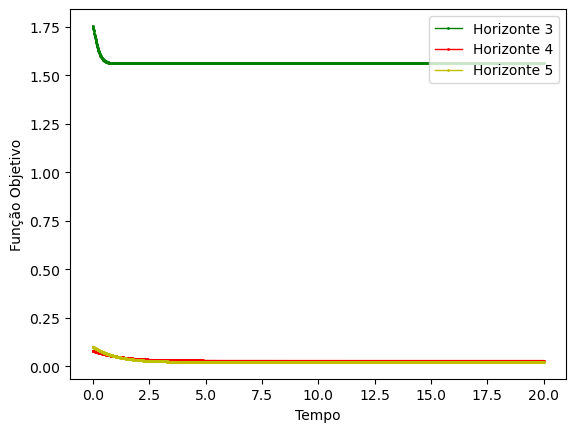

In [11]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.plot(ts, abs(valoresFuncaoObjetivo4[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 4")
plt.plot(ts, abs(valoresFuncaoObjetivo5[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo1.png', format='png')
plt.show()

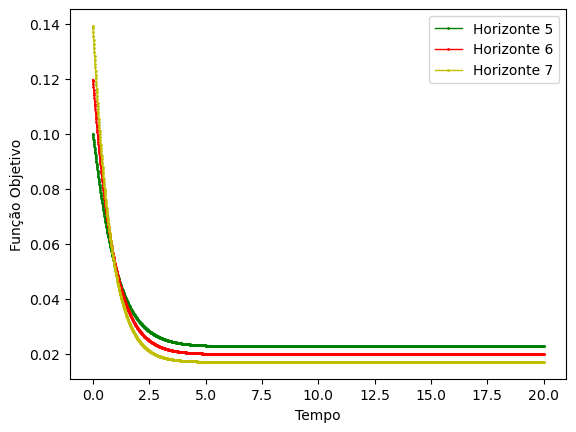

In [12]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo5[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 5")
plt.plot(ts, abs(valoresFuncaoObjetivo6[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 6")
plt.plot(ts, abs(valoresFuncaoObjetivo7[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo2.png', format='png')
plt.show()

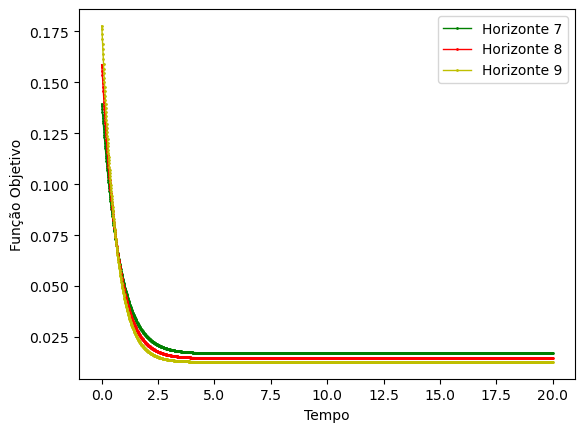

In [13]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo7[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 7")
plt.plot(ts, abs(valoresFuncaoObjetivo8[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 8")
plt.plot(ts, abs(valoresFuncaoObjetivo9[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo3.png', format='png')
plt.show()

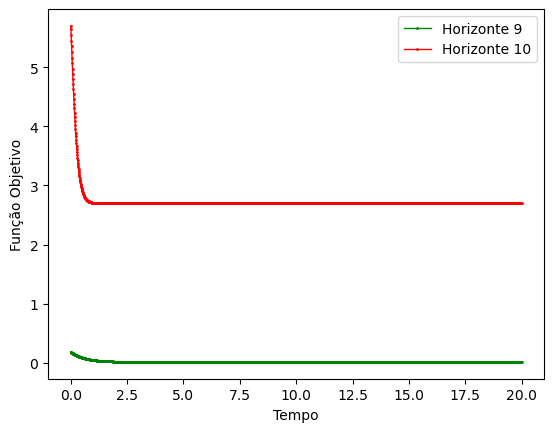

In [14]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo9[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 9")
plt.plot(ts, abs(valoresFuncaoObjetivo10[0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 10")
plt.legend(loc="upper right")
plt.savefig('valoresFuncaoObjetivo4.png', format='png')
plt.show()

### Avaliação das componentes

Um grande problemas dos métodos de minimização está concentrado no cálculo numérico. O cálculo númerico se trata de um processo de aproximação de forma que quanto pior é a manipulação das variáveis, pior ficará a aproximação. Nesse sistema se torna perceptível a melhoria do ajuste através da desafagem do ajuste.

Conforme o livro, introdução à computação clássica e quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na parte real quanto imaginária, além de realizar a diferença entre essas partes.

[447, 847, 1247, 1647, 1650]
[400, 800, 1200, 1600, 1999]


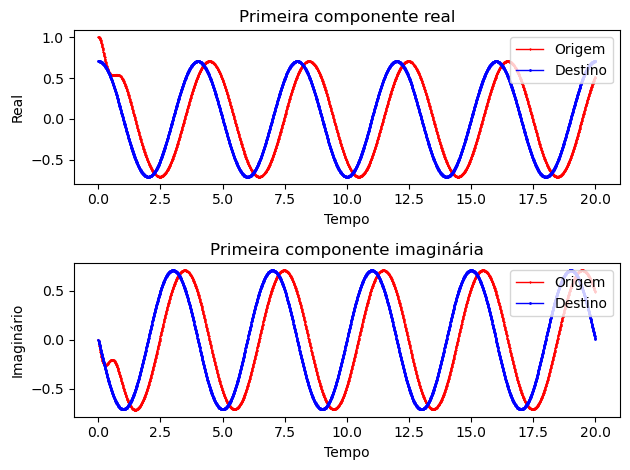

In [15]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

diferencaAbsoluta3 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    diferencaAbsoluta3[0][i] = ((abs(valoresOnda3[0][i]) - abs(evolucaoDestino[0][i])))
    diferencaAbsoluta3[1][i] = ((abs(valoresOnda3[1][i]) - abs(evolucaoDestino[1][i])))
    
    
teste = []
teste2 = []
for i in range(250, 2000, 350):
    maiores = []
    maiores2 = []
    for j in range(i, i+350):
        maiores.append(realObjetivoPrimeiraComponente[j])
        maiores2.append(realDestinoPrimeiraComponente[j])
    teste.append(np.max(maiores))
    teste2.append(np.max(maiores2))

tempo = []
i = 250
j = 0
while i < 2000 and j < len(teste):
    if (realObjetivoPrimeiraComponente[i] == teste[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)

tempo = []
i = 250
j = 0
while i < 2000 and j < len(teste2):
    if (realDestinoPrimeiraComponente[i] == teste2[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

[249, 251, 384, 518, 651, 784, 918, 1051, 1184, 1318, 1451, 1584, 1718, 1851, 1984]
[133, 267, 400, 533, 667, 800, 933, 1067, 1200, 1333, 1467, 1600, 1733, 1867, 1999]


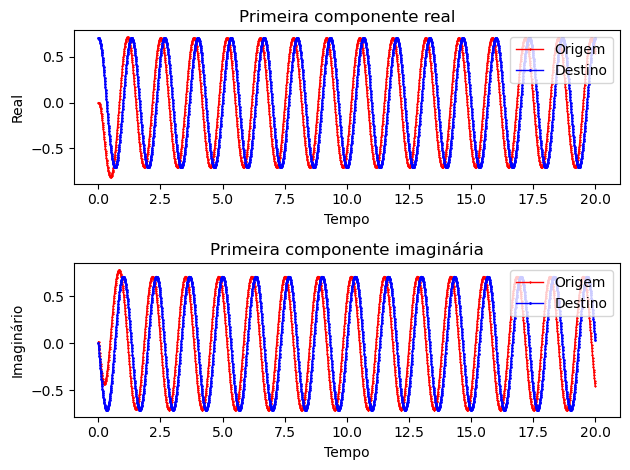

In [16]:
# Plotagem

teste = []
teste2 = []
for i in np.arange(125, 2000, 125):
    maiores = []
    maiores2 = []
    for j in np.arange(i, i+125):
        maiores.append(realObjetivoSegundaComponente[int(j)])
        maiores2.append(realDestinoSegundaComponente[int(j)])
    teste.append(np.max(maiores))
    teste2.append(np.max(maiores2))

tempo = []
i = 100
j = 0
while i < 2000 and j < len(teste):
    if (realObjetivoSegundaComponente[i] == teste[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)

tempo = []
i = 100
j = 0
while i < 2000 and j < len(teste2):
    if (realDestinoSegundaComponente[i] == teste2[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)


plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

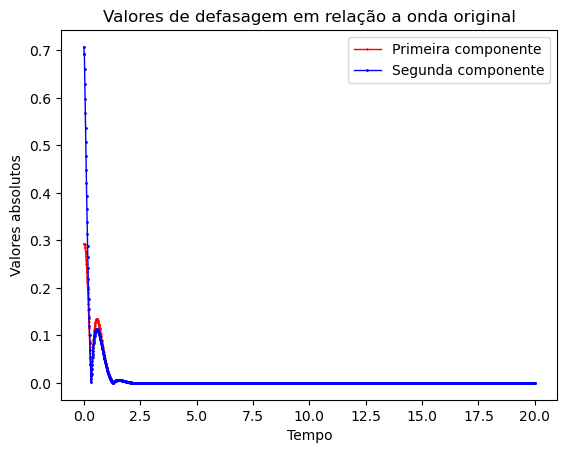

In [17]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(diferencaAbsoluta3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(diferencaAbsoluta3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

In [18]:
from scipy.integrate import trapz

# Processo de integração numérica usando o método dos trapézios

x=np.linspace(0,20,2000) # Espaçamento

Integral = trapz(diferencaAbsoluta3[0],x)

print(Integral)

Integral = trapz(diferencaAbsoluta3[1],x)

print(Integral)

(-0.0029067340195689656+0j)
(-0.04834286872832403+0j)


[433, 833, 1233, 1633, 1650]


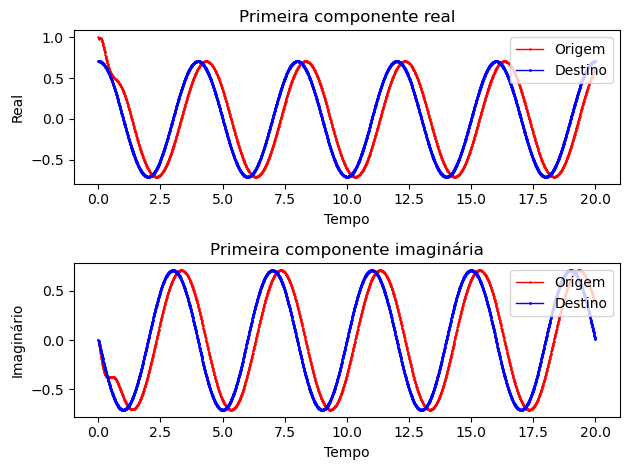

In [19]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda10[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda10[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda10[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda10[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

defasagem10 = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    defasagem10[0][i] = ((abs(valoresOnda10[0][i]) - abs(evolucaoDestino[0][i])))
    defasagem10[1][i] = ((abs(valoresOnda10[1][i]) - abs(evolucaoDestino[1][i])))
    
teste = []
teste2 = []
for i in range(250, 2000, 350):
    maiores = []
    maiores2 = []
    for j in range(i, i+350):
        maiores.append(realObjetivoPrimeiraComponente[j])
        maiores2.append(realDestinoPrimeiraComponente[j])
    teste.append(np.max(maiores))
    teste2.append(np.max(maiores2))

tempo = []
i = 250
j = 0
while i < 2000 and j < len(teste):
    if (realObjetivoPrimeiraComponente[i] == teste[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

[125, 256, 389, 522, 656, 789, 922, 1056, 1189, 1322, 1456, 1589, 1722, 1856, 1989]
[133, 267, 400, 533, 667, 800, 933, 1067, 1200, 1333, 1467, 1600, 1733, 1867, 1999]


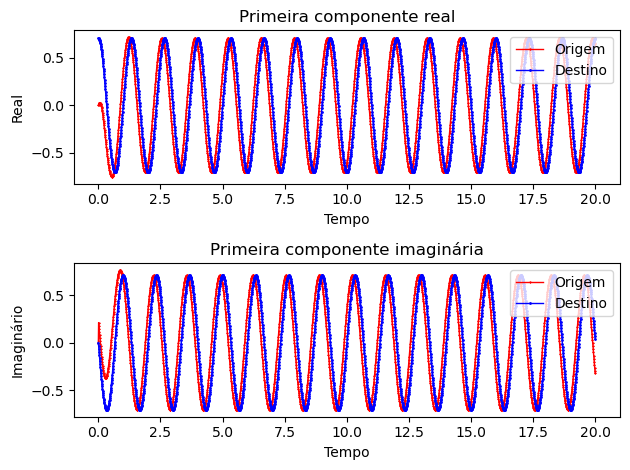

In [20]:
# Plotagem

teste = []
teste2 = []
for i in np.arange(125, 2000, 125):
    maiores = []
    maiores2 = []
    for j in np.arange(i, i+125):
        maiores.append(realObjetivoSegundaComponente[int(j)])
        maiores2.append(realDestinoSegundaComponente[int(j)])
    teste.append(np.max(maiores))
    teste2.append(np.max(maiores2))

tempo = []
i = 100
j = 0
while i < 2000 and j < len(teste):
    if (realObjetivoSegundaComponente[i] == teste[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)

tempo = []
i = 100
j = 0
while i < 2000 and j < len(teste2):
    if (realDestinoSegundaComponente[i] == teste2[j]):
        tempo.append(i)
        j+=1
    i+=1
        
print(tempo)


plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

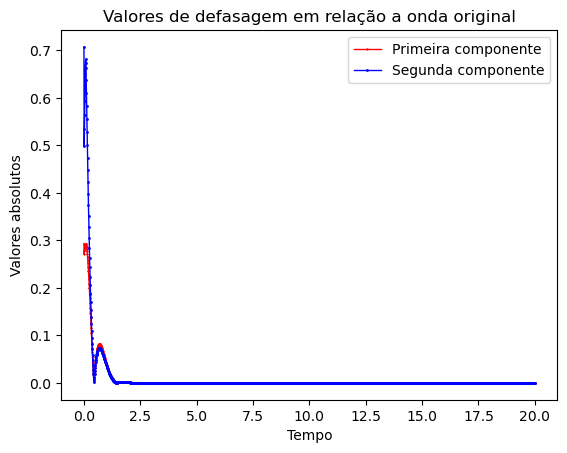

In [21]:
plt.ylabel('Valores absolutos') 
plt.xlabel('Tempo') 
plt.title('Valores de defasagem em relação a onda original')
plt.plot(ts, abs(defasagem10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(defasagem10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.legend(loc='upper right')

In [22]:
from scipy.integrate import trapz

# Processo de integração numérica usando o método dos trapézios

x=np.linspace(0,20,2000) # Espaçamento

Integral = trapz(defasagem10[0],x)

print(Integral)

Integral = trapz(defasagem10[1],x)

print(Integral)

(0.0446514434127767+0j)
(-0.1132304988172475+0j)


### Avaliação das constantes



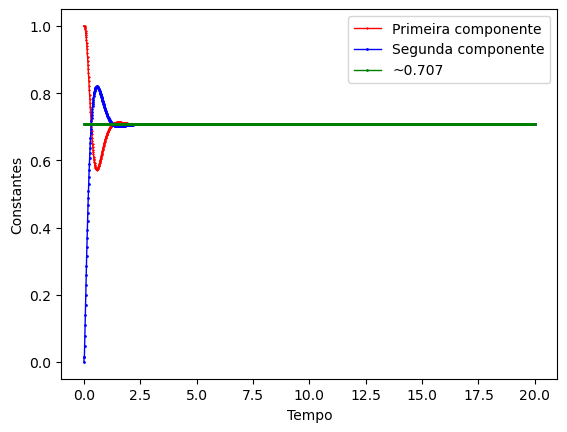

In [23]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

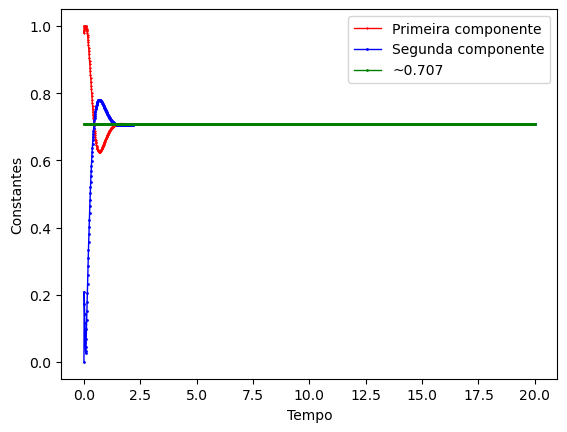

In [24]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

### Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

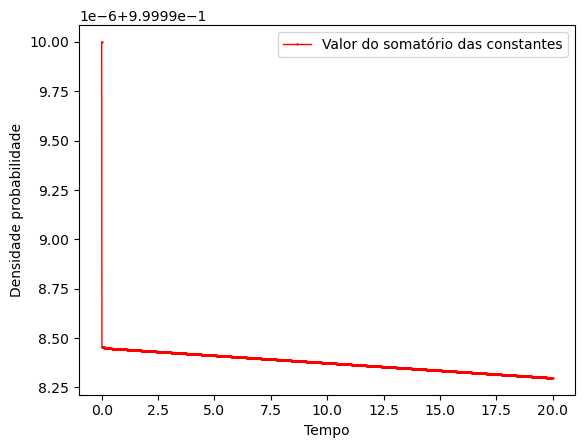

In [25]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(constantes10[0][i])**2+abs(constantes10[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
plt.legend(loc="upper right")
plt.savefig('dp.png', format='png')
plt.show()